In [1]:
    # prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.animation as animation
import matplotlib.pyplot as plt


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
bs = 120

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)
train1 = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
train0 = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
train2 = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)

a= 7 
b = 6 #biased controlled
c = 9
# idx = (train_dataset.targets==1) | (train_dataset.targets==0)
# train_dataset.targets = train_dataset.targets[idx]
# train_dataset.data = train_dataset.data[idx]
idx = train_dataset.targets == a
train1.targets = train_dataset.targets[idx]
train1.data = train_dataset.data[idx]

idx = train_dataset.targets == b   #variable
train0.targets = train_dataset.targets[idx]
train0.data = train_dataset.data[idx]

idx = train_dataset.targets == c
train2.targets = train_dataset.targets[idx]
train2.data = train_dataset.data[idx]
#take two datasets of 0's and 1's seperately . 
#create new #ther to training.
#

#CONTROL THE SIZE OF BATCHES, CHANGE THE DATALOADER1
# bs_var = 10
# bs_next = int((bs - bs_var)/2)
# dataloader0 = torch.utils.data.DataLoader(dataset=train0, batch_size=bs_var, drop_last=True, shuffle=True)
# dataloader1 =  torch.utils.data.DataLoader(dataset=train1, batch_size=bs_next, drop_last=True, shuffle=True)
# dataloader3 =   torch.utils.data.DataLoader(dataset=train2, batch_size=bs_next, drop_last=True, shuffle=True)



# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

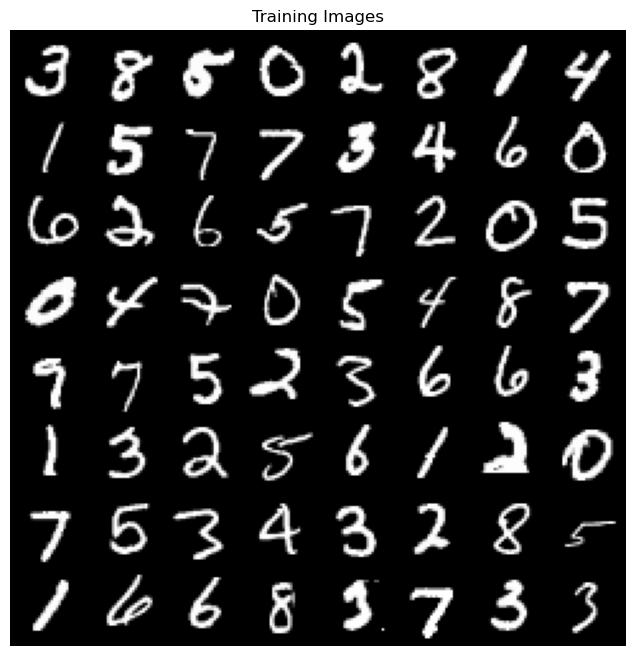

In [17]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [18]:
def customdata(d1,d2,d3):
    dataset = []
    tensor_data = []
    for i, ((x,a),(y,b),(q,c)) in enumerate(zip(d1,d2,d3)):

            
        r = torch.cat((x,y,q),0)
        tensor_data.append(r)
        
    return tensor_data
    

In [33]:
ds = customdata(dataloader0,dataloader1,dataloader3)

In [34]:
ds[-1].shape

torch.Size([120, 1, 28, 28])

In [26]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [27]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

In [28]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [29]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [30]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = Variable(torch.randn(bs, z_dim).to(device))  #
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device)) #can be the not random for other study evaluation to visually inspect if case
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [40]:
n_epoch = 200
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, x in enumerate(ds):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))
        if batch_idx ==99:
            
            break
        

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/200]: loss_d: 0.919, loss_g: 1.456
[2/200]: loss_d: 1.028, loss_g: 3.557
[3/200]: loss_d: 0.296, loss_g: 5.498
[4/200]: loss_d: 0.540, loss_g: 4.819
[5/200]: loss_d: 0.963, loss_g: 4.043
[6/200]: loss_d: 0.961, loss_g: 2.424
[7/200]: loss_d: 0.910, loss_g: 2.367
[8/200]: loss_d: 0.713, loss_g: 3.701
[9/200]: loss_d: 0.851, loss_g: 2.478
[10/200]: loss_d: 0.982, loss_g: 2.222
[11/200]: loss_d: 1.028, loss_g: 1.671
[12/200]: loss_d: 0.579, loss_g: 2.072
[13/200]: loss_d: 0.644, loss_g: 2.610
[14/200]: loss_d: 0.783, loss_g: 3.530
[15/200]: loss_d: 0.764, loss_g: 2.199
[16/200]: loss_d: 0.662, loss_g: 2.821
[17/200]: loss_d: 1.053, loss_g: 1.507
[18/200]: loss_d: 0.971, loss_g: 1.754
[19/200]: loss_d: 1.090, loss_g: 1.316
[20/200]: loss_d: 0.583, loss_g: 2.281
[21/200]: loss_d: 0.586, loss_g: 3.001
[22/200]: loss_d: 0.637, loss_g: 2.794
[23/200]: loss_d: 0.456, loss_g: 2.949
[24/200]: loss_d: 0.548, loss_g: 3.033
[25/200]: loss_d: 0.458, loss_g: 2.736
[26/200]: loss_d: 0.548, loss_g: 2

In [24]:
def gan_experiment(ds):
    
    
    n_epoch = 200
    for epoch in range(1, n_epoch+1):           
        D_losses, G_losses = [], []
        for batch_idx, x in enumerate(ds):
            D_losses.append(D_train(x))
            G_losses.append(G_train(x))
            if batch_idx ==99:

                break


        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
                (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    with torch.no_grad():
        test_z = Variable(torch.randn(bs, z_dim).to(device))
    
    
    predictions = G(test_z).detach().cpu()

    predictions_gen = predictions.reshape(bs,28,28,1)

    for i in range(predictions_gen.shape[0]):
        if i < 16:
            plt.subplot(4, 4, i+1)
        plt.imshow(predictions_gen[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        # plt.imsave('samples01/image{:04d}-{}.png'.format(1, i), predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')

        plt.axis('off')

    gen_images= torch.chunk(predictions_gen,bs,dim=0)
    generated = predictions_gen.reshape(bs,1,28,28)
    cnn.eval()
    with torch.no_grad():
        test_output, last_layer = cnn(generated)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
    gen_c1 = 0
    gen_c0 =0
    gen_c3 = 0
    for i in pred_y:
        if i == b: 
            gen_c0 += 1
        if i == a:
            gen_c1 += 1
        if i ==c:
            gen_c3 +=1

    list= [gen_c0,gen_c1,gen_c3]

    gen1.append(gen_c0) #variable
    gen2.append(gen_c1) 
    gen3.append(gen_c3)
    
        
    

[1/200]: loss_d: 1.003, loss_g: 1.149
[2/200]: loss_d: 1.240, loss_g: 2.739
[3/200]: loss_d: 0.732, loss_g: 3.130
[4/200]: loss_d: 0.080, loss_g: 5.448
[5/200]: loss_d: 0.010, loss_g: 8.250
[6/200]: loss_d: 0.009, loss_g: 7.351
[7/200]: loss_d: 0.010, loss_g: 9.917
[8/200]: loss_d: 0.003, loss_g: 9.407
[9/200]: loss_d: 0.013, loss_g: 9.811
[10/200]: loss_d: 0.001, loss_g: 13.279
[11/200]: loss_d: 0.000, loss_g: 14.884
[12/200]: loss_d: 0.000, loss_g: 17.139
[13/200]: loss_d: 0.000, loss_g: 16.269
[14/200]: loss_d: 0.000, loss_g: 16.982
[15/200]: loss_d: 0.000, loss_g: 18.462
[16/200]: loss_d: 0.000, loss_g: 16.615
[17/200]: loss_d: 0.000, loss_g: 18.161
[18/200]: loss_d: 0.000, loss_g: 20.080
[19/200]: loss_d: 0.000, loss_g: 20.570
[20/200]: loss_d: 0.000, loss_g: 20.217
[21/200]: loss_d: 0.000, loss_g: 19.735
[22/200]: loss_d: 0.000, loss_g: 20.070
[23/200]: loss_d: 0.000, loss_g: 19.855
[24/200]: loss_d: 0.000, loss_g: 18.892
[25/200]: loss_d: 0.000, loss_g: 19.024
[26/200]: loss_d: 

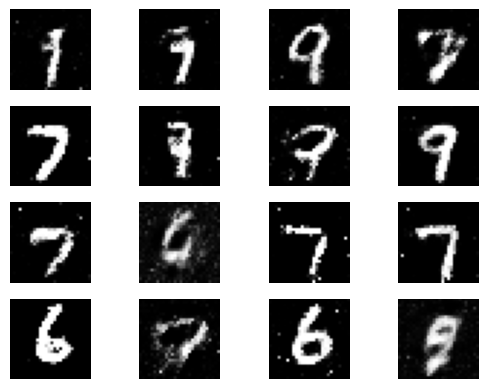

In [31]:

gen1 = []
gen2 =[]
gen3 = []
for i in range(5):
    bs_var = 10 + 10*i
    bs_next = int((bs - bs_var)/2)
    dataloader0 = torch.utils.data.DataLoader(dataset=train0, batch_size=bs_var, drop_last=True, shuffle=True)
    dataloader1 =  torch.utils.data.DataLoader(dataset=train1, batch_size=bs_next, drop_last=True, shuffle=True)
    dataloader3 =   torch.utils.data.DataLoader(dataset=train2, batch_size=bs_next, drop_last=True, shuffle=True)
    ds = customdata(dataloader0,dataloader1,dataloader3)
    for i in range(5):
        z_dim = 100
        mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

        G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
        D = Discriminator(mnist_dim).to(device)
        criterion = nn.BCELoss() 

        # optimizer
        lr = 0.0002 
        G_optimizer = optim.Adam(G.parameters(), lr = lr)
        D_optimizer = optim.Adam(D.parameters(), lr = lr)
        gan_experiment(ds)

In [34]:
gen1

[0,
 0,
 1,
 1,
 0,
 5,
 3,
 0,
 0,
 4,
 0,
 19,
 9,
 5,
 7,
 21,
 23,
 28,
 21,
 17,
 31,
 35,
 40,
 33,
 36]

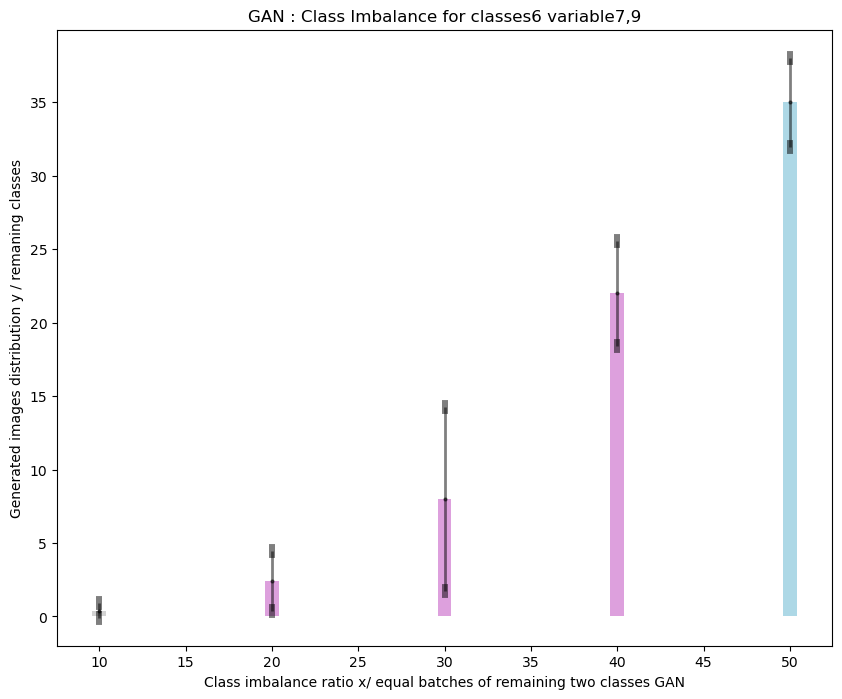

In [35]:
stat_gan = []
mean_stat_gan=[]
std_stat_gan = []
for i in range(len(gen1)):
    stat_gan.append(gen1[i])

    if (i+1)%5== 0 and i != 0:
        mean_stat_gan.append(np.mean(stat_gan))
        var = np.var(stat_gan)
        std_stat_gan.append(var ** 0.5)
        stat_gan= []

x=[10,20,30,40,50]
y= mean_stat_gan
yerr=std_stat_gan
width = 10
height = 8
plt.figure(figsize=(width, height))
plt.bar(x, y, color=['lightgray','plum','plum','plum','lightblue','lightblue','lightblue','palegreen','palegreen','palegreen', 'khaki', 'khaki', 'khaki'])
plt.title('GAN : Class Imbalance for classes'+ str(b) +' variable'+str(a)+','+str(c))
plt.xlabel('Class imbalance ratio x/ equal batches of remaining two classes GAN')
plt.ylabel('Generated images distribution y / remaning classes')
plt.errorbar(x, y, yerr, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
plt.savefig('figureGAN.png', dpi=400, transparent=True)
plt.show()

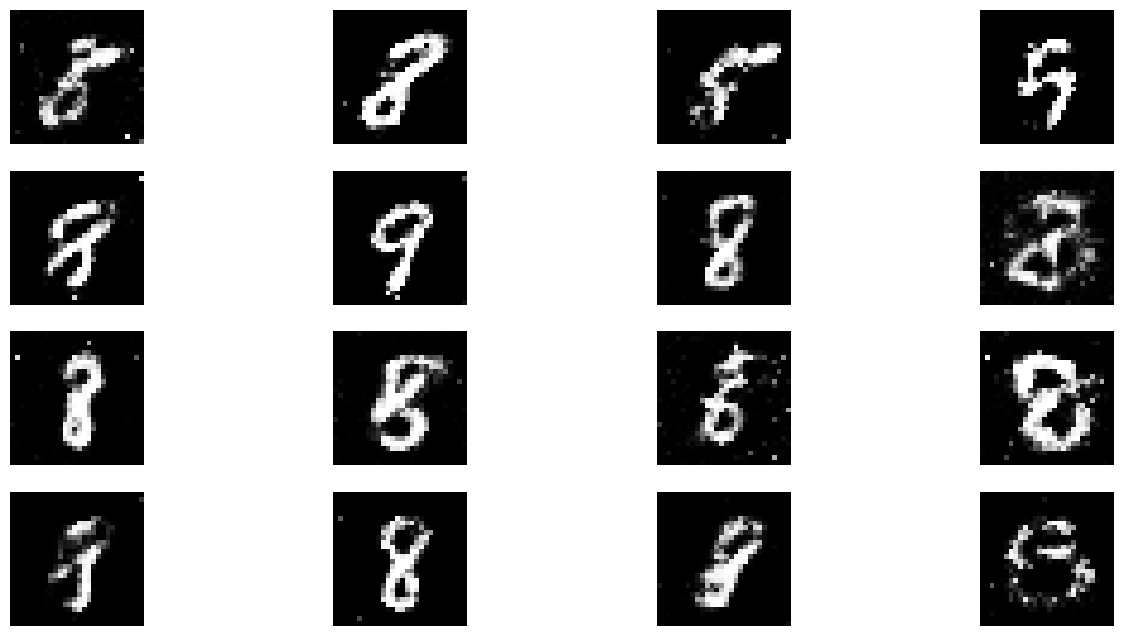

In [1481]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    
    
predictions = G(test_z).detach().cpu()

predictions_gen = predictions.reshape(bs,28,28,1)

for i in range(predictions_gen.shape[0]):
    if i < 16:
        plt.subplot(4, 4, i+1)
    plt.imshow(predictions_gen[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    # plt.imsave('samples01/image{:04d}-{}.png'.format(1, i), predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')

    plt.axis('off')
        
gen_images= torch.chunk(predictions_gen,bs,dim=0)

# plt.savefig('image_at_epoch_{:04d}.png'.format(303))


In [1482]:
generated = predictions_gen.reshape(bs,1,28,28)

In [1483]:
cnn.eval()
with torch.no_grad():
    test_output, last_layer = cnn(generated)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()

In [1484]:
pred_y

tensor([3, 8, 5, 9, 9, 9, 8, 2, 8, 8, 6, 8, 9, 8, 9, 3, 8, 3, 8, 3, 8, 8, 3, 2,
        8, 9, 8, 8, 8, 5, 8, 8, 8, 8, 9, 5, 7, 8, 5, 5, 7, 5, 8, 5, 5, 8, 3, 7,
        5, 8, 8, 8, 7, 8, 5, 8, 9, 8, 5, 8, 8, 8, 8, 9, 8, 5, 5, 1, 9, 8, 8, 8,
        5, 8, 9, 8, 5, 5, 8, 9, 8, 8, 3, 8, 5, 8, 8, 8, 9, 8, 5, 9, 5, 8, 5, 8,
        5, 8, 5, 9, 5, 8, 8, 8, 5, 9, 8, 9, 8, 9, 8, 4, 2, 5, 0, 8, 8, 9, 3, 7])

In [1485]:

# gen1 = []
# gen2 =[]
# gen3 = []

In [1486]:
c

9

In [1487]:
gen_c1 = 0
gen_c0 =0
gen_c3 = 0
for i in pred_y:
    if i == b: 
        gen_c0 += 1
    if i == a:
        gen_c1 += 1
    if i ==c:
        gen_c3 +=1
        
list= [gen_c0,gen_c1,gen_c3]

gen1.append(gen_c0) #variable
gen2.append(gen_c1) 
gen3.append(gen_c3)
        

In [1488]:
if len(gen1)%5 ==0:
    print("change batch size")
len(gen1)


change batch size


30

In [1489]:
gen1

[2,
 4,
 6,
 3,
 1,
 10,
 13,
 13,
 8,
 9,
 22,
 14,
 24,
 16,
 26,
 26,
 22,
 37,
 19,
 33,
 19,
 43,
 33,
 40,
 37,
 48,
 54,
 45,
 49,
 56]

In [1490]:
stat = []
mean_stat=[]
std_stat = []
for i in range(len(gen1)):
    stat.append(gen1[i])
    
    if (i+1)%5== 0 and i != 0:
        mean_stat.append(np.mean(stat))
        var = np.var(stat)
        std_stat.append(var ** 0.5)
        stat = []
        
        

In [1491]:
std_stat

[1.7204650534085253,
 2.0591260281974,
 4.63033476111609,
 6.711184694225007,
 8.380930735902785,
 4.029888335921977]

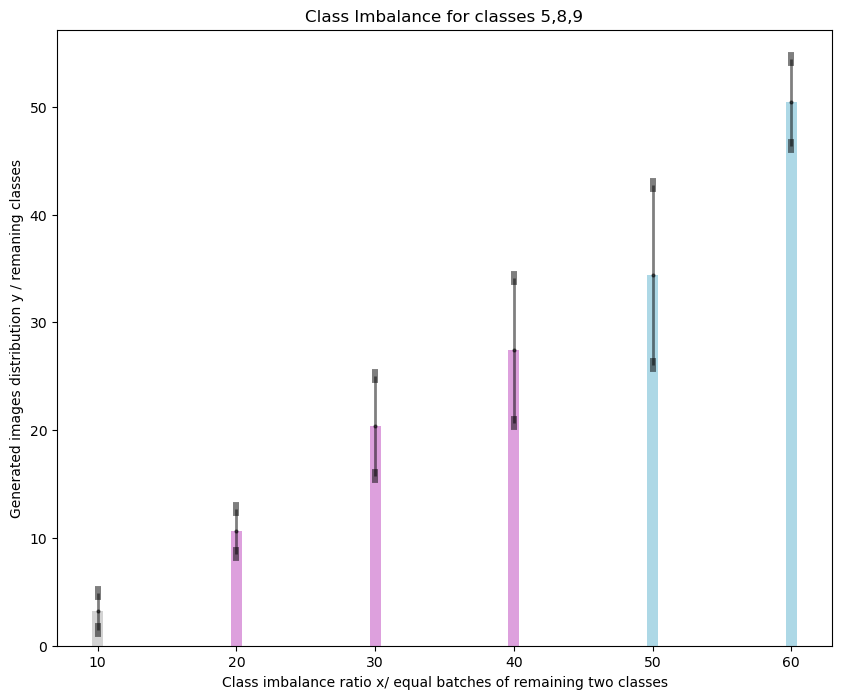

In [1493]:
import matplotlib.pyplot as plt 
x=[10,20,30,40,50,60]
y= mean_stat
yerr=std_stat
width = 10
height = 8
plt.figure(figsize=(width, height))
plt.bar(x, y, color=['lightgray','plum','plum','plum','lightblue','lightblue','lightblue','palegreen','palegreen','palegreen', 'khaki', 'khaki', 'khaki'])
plt.title('Class Imbalance for classes 5,8,9')
plt.xlabel('Class imbalance ratio x/ equal batches of remaining two classes')
plt.ylabel('Generated images distribution y / remaning classes')
plt.errorbar(x, y, yerr, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
plt.savefig('figure.png', dpi=400, transparent=True)
plt.show()

#Performing Classification of the Generated Images 

In [42]:
#dont run below cell

bs = 120

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)
train1 = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
train0 = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
train2 = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)

a= 5 
b = 8 #biased controlled
c = 9
# idx = (train_dataset.targets==1) | (train_dataset.targets==0)
# train_dataset.targets = train_dataset.targets[idx]
# train_dataset.data = train_dataset.data[idx]
idx = train_dataset.targets == a
train1.targets = train_dataset.targets[idx]
train1.data = train_dataset.data[idx]

idx = train_dataset.targets == b   #variable
train0.targets = train_dataset.targets[idx]
train0.data = train_dataset.data[idx]

idx = train_dataset.targets == c
train2.targets = train_dataset.targets[idx]
train2.data = train_dataset.data[idx]
#take two datasets of 0's and 1's seperately . 
#create new #ther to training.
#

#CONTROL THE SIZE OF BATCHES, CHANGE THE DATALOADER1
bs_var = 40
bs_next = int((bs - bs_var)/2)
dataloader0 = torch.utils.data.DataLoader(dataset=train0, batch_size=bs_var, drop_last=True, shuffle=True)
dataloader1 =  torch.utils.data.DataLoader(dataset=train1, batch_size=bs_next, drop_last=True, shuffle=True)
dataloader3 =   torch.utils.data.DataLoader(dataset=train2, batch_size=bs_next, drop_last=True, shuffle=True)



# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [36]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
   

    def __init__(self, im_chan=1, output_chan=32, hidden_dim=16):
        super(Encoder, self).__init__()
        self.z_dim = output_chan
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, output_chan * 2, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        
        disc_pred = self.disc(image)
        encoding = disc_pred.view(len(disc_pred), -1)
        # The stddev output is treated as the log of the variance of the normal 
        # distribution by convention and for numerical stability
        return encoding[:, :self.z_dim], encoding[:, self.z_dim:].exp()

class Decoder(nn.Module):
    
    
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
       
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Sigmoid(),
            )

    def forward(self, noise):
       
    
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

In [37]:
from torch.distributions.normal import Normal

class VAE(nn.Module):
   
    
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encode = Encoder(im_chan, z_dim)
        self.decode = Decoder(z_dim, im_chan)

    def forward(self, images):
        
        q_mean, q_stddev = self.encode(images)
        q_dist = Normal(q_mean, q_stddev)
        z_sample = q_dist.rsample() # Sample once from each distribution, using the `rsample` notation
        decoding = self.decode(z_sample)
        return decoding, q_dist

In [38]:
reconstruction_loss = nn.BCELoss(reduction='sum')

In [39]:
from torch.distributions.kl import kl_divergence
def kl_divergence_loss(q_dist):
    return kl_divergence(
        q_dist, Normal(torch.zeros_like(q_dist.mean), torch.ones_like(q_dist.stddev))
    ).sum(-1)

Epoch 0


100%|██████████| 108/108 [00:01<00:00, 67.16it/s] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


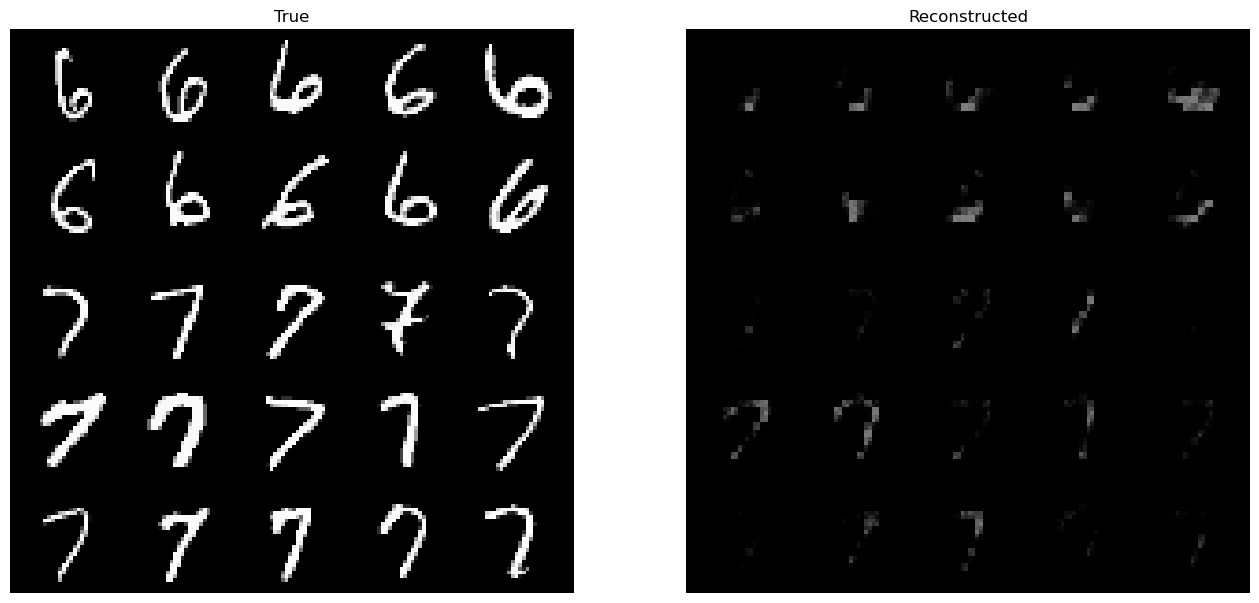

Epoch 1


100%|██████████| 108/108 [00:00<00:00, 167.98it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


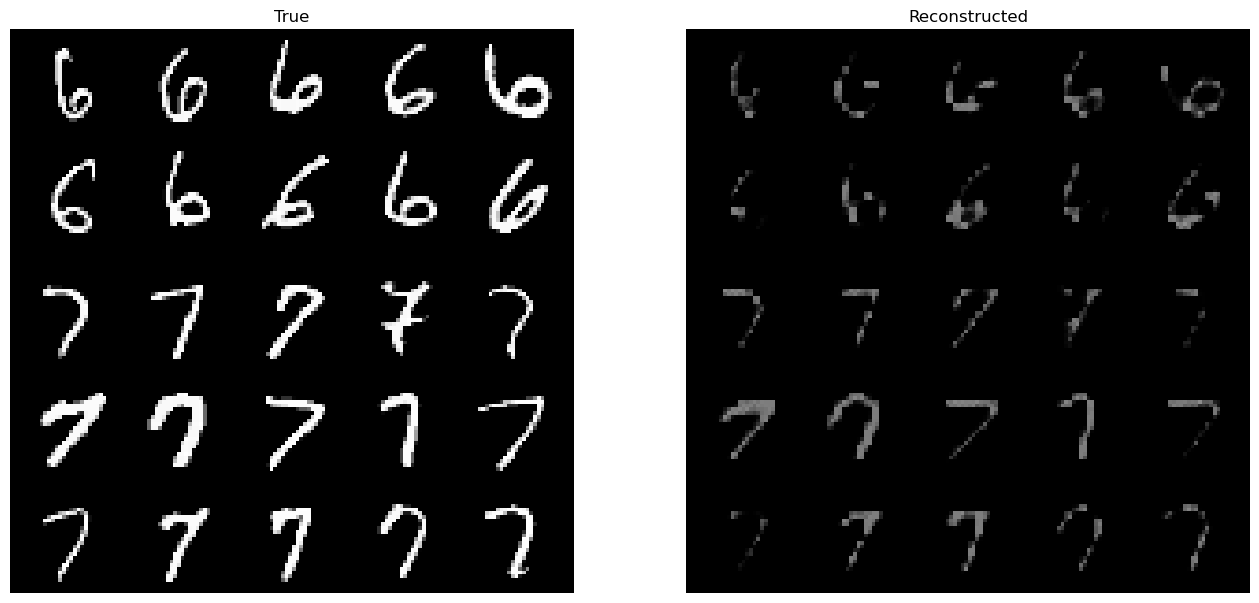

Epoch 2


100%|██████████| 108/108 [00:00<00:00, 173.14it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


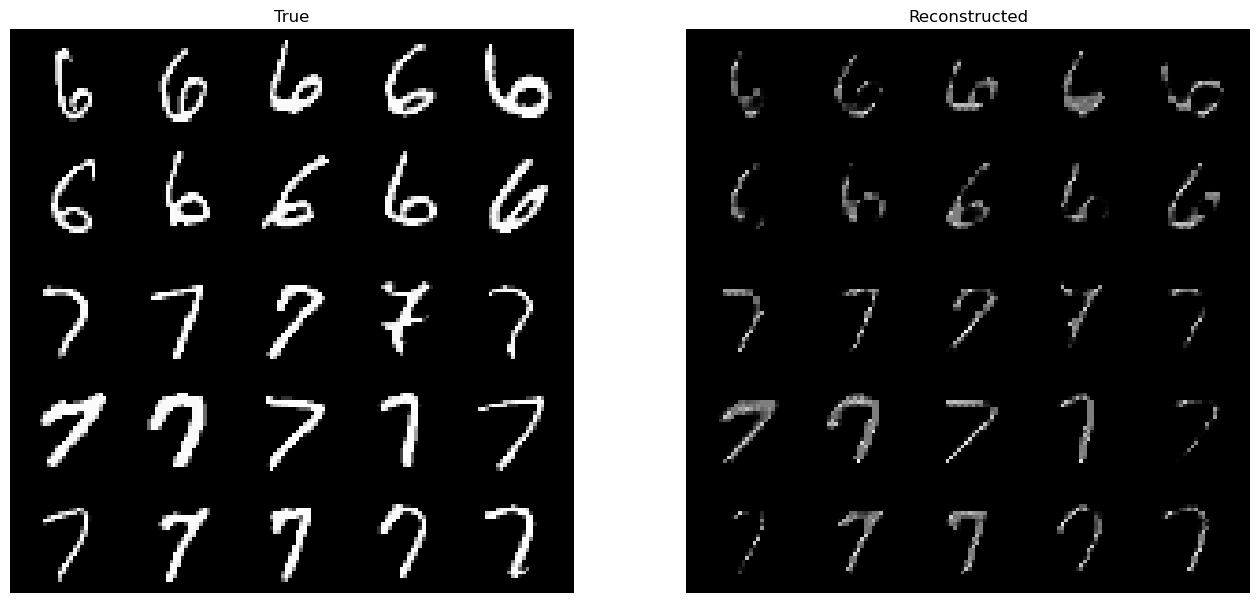

Epoch 3


100%|██████████| 108/108 [00:00<00:00, 174.80it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


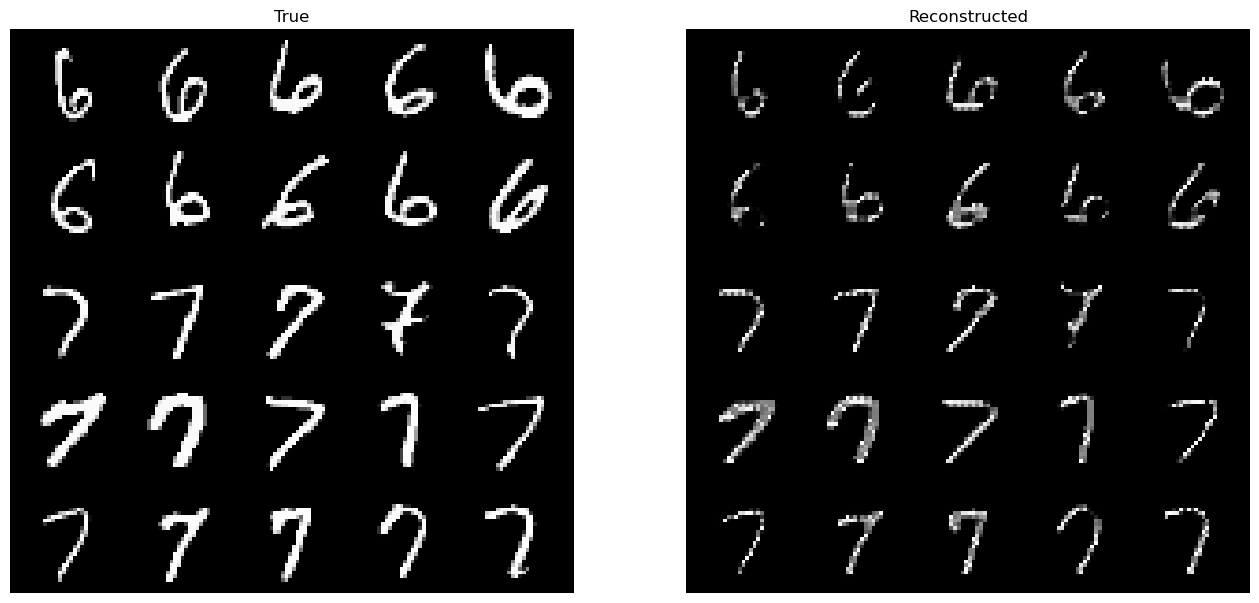

Epoch 4


100%|██████████| 108/108 [00:00<00:00, 174.50it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


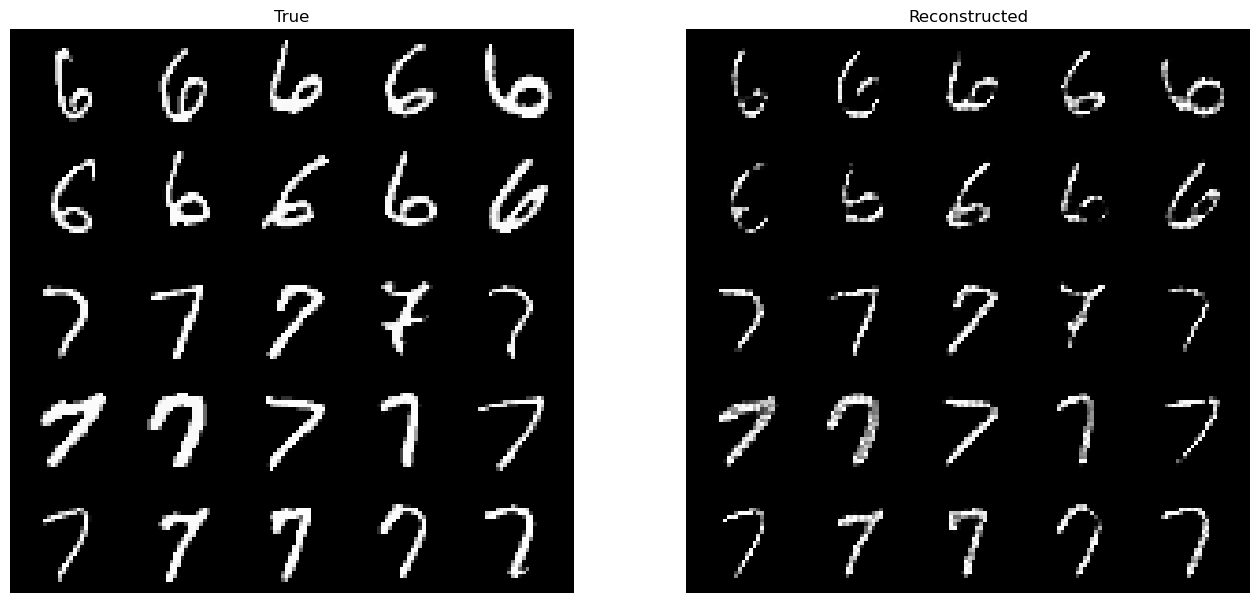

Epoch 5


100%|██████████| 108/108 [00:00<00:00, 174.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


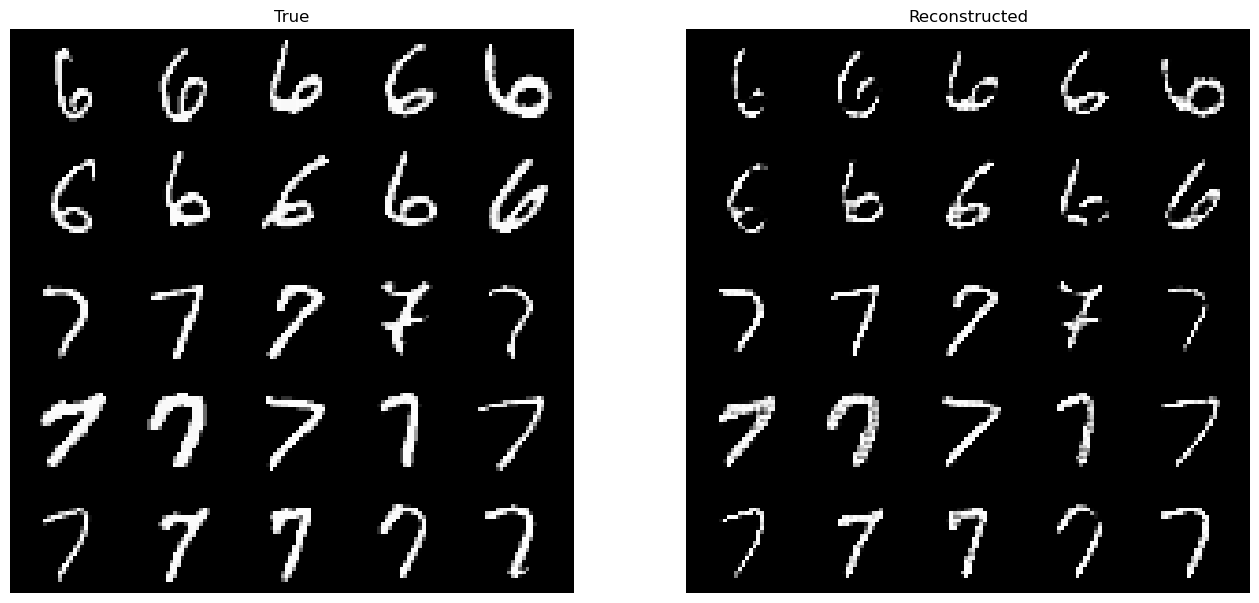

Epoch 6


100%|██████████| 108/108 [00:00<00:00, 175.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


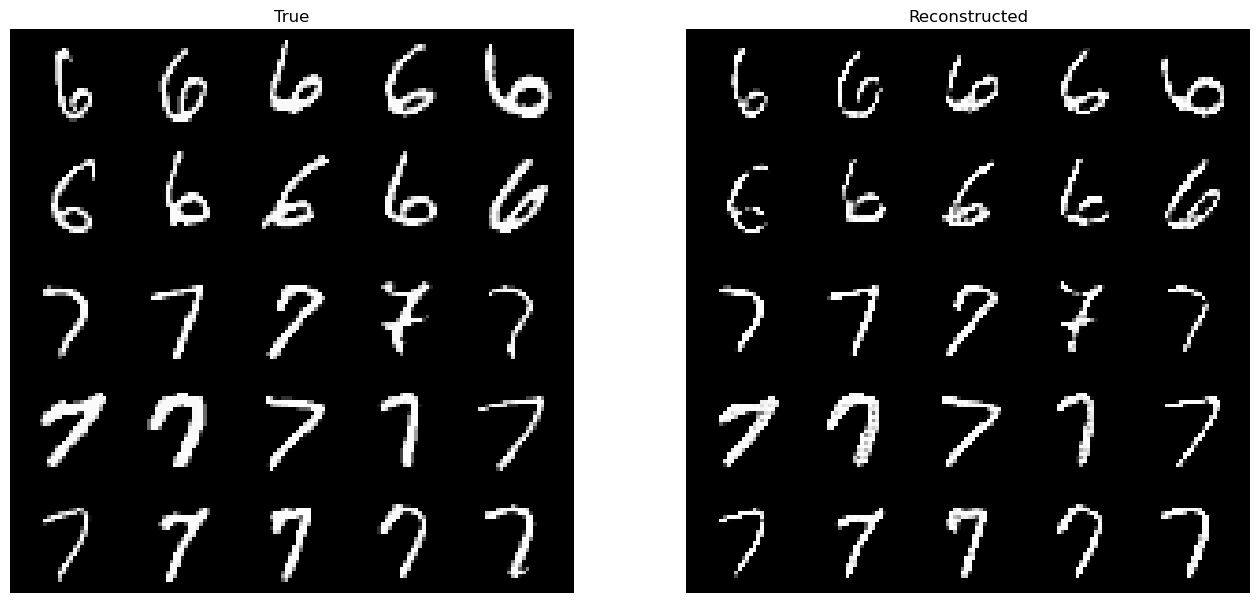

Epoch 7


100%|██████████| 108/108 [00:00<00:00, 172.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


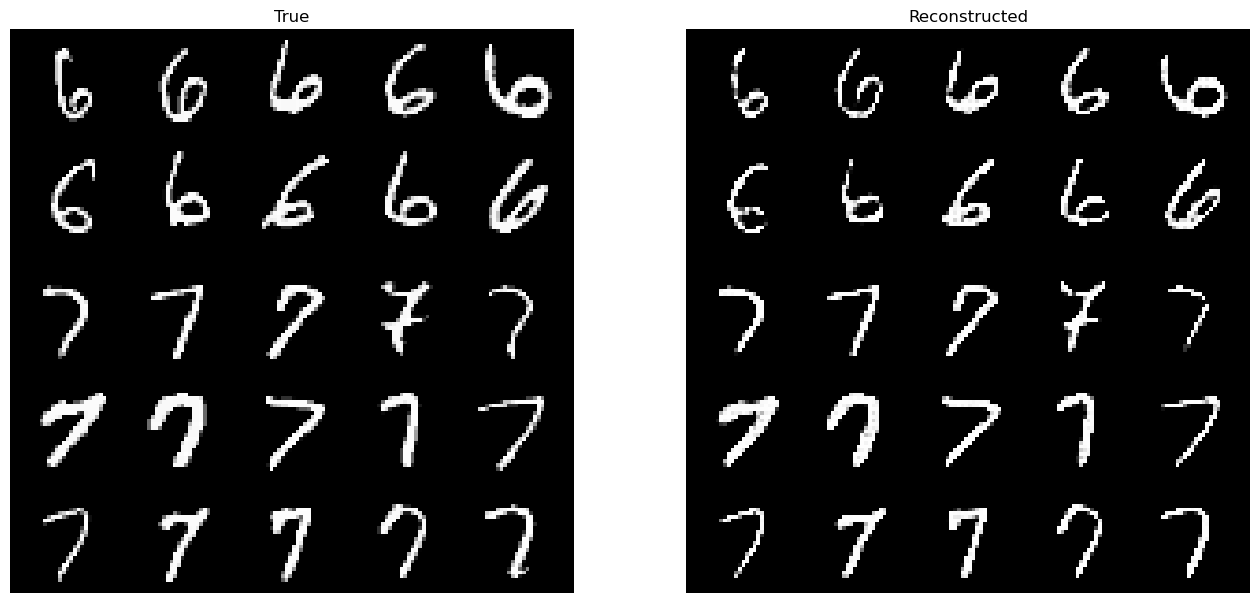

Epoch 8


100%|██████████| 108/108 [00:00<00:00, 174.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


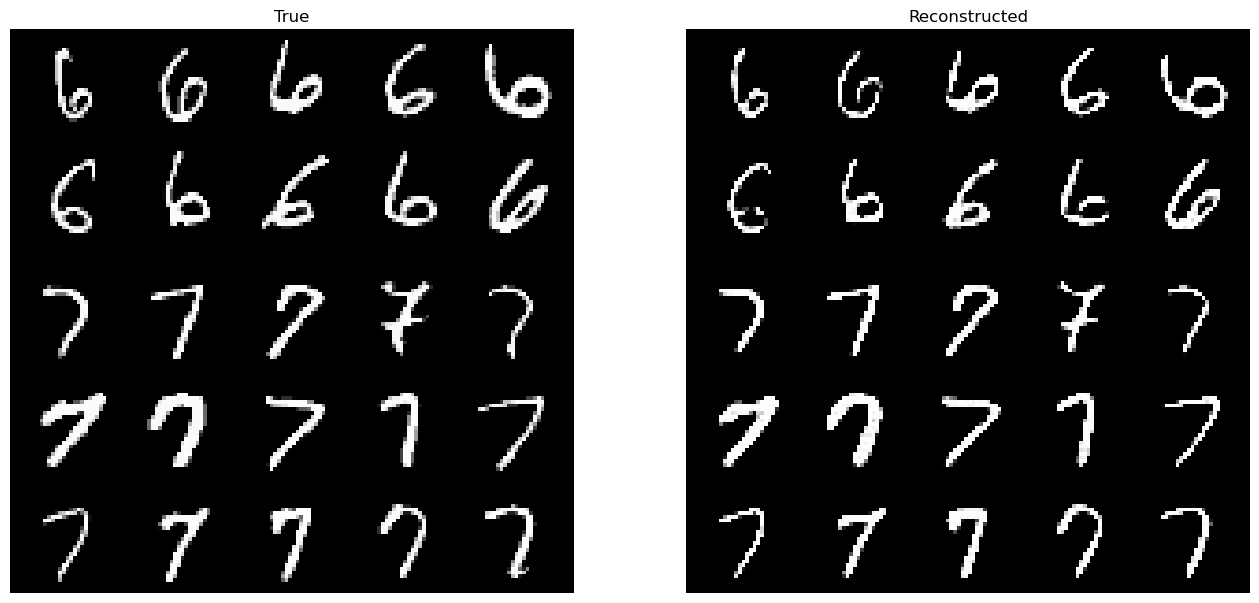

Epoch 9


100%|██████████| 108/108 [00:00<00:00, 174.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


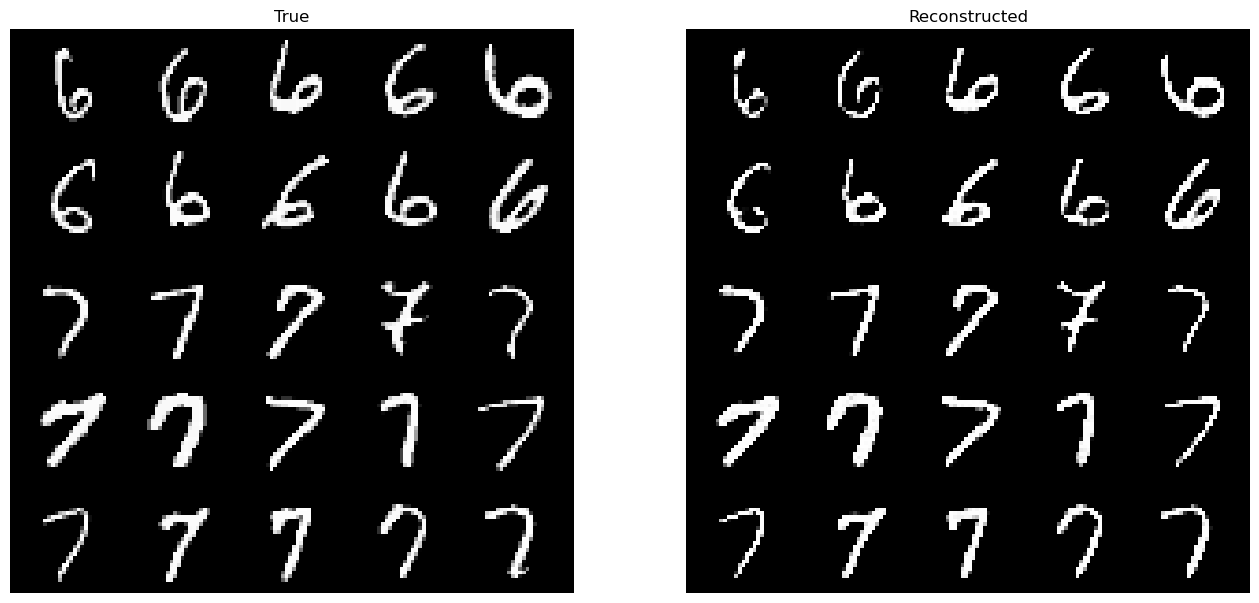

Epoch 0


100%|██████████| 108/108 [00:00<00:00, 174.62it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


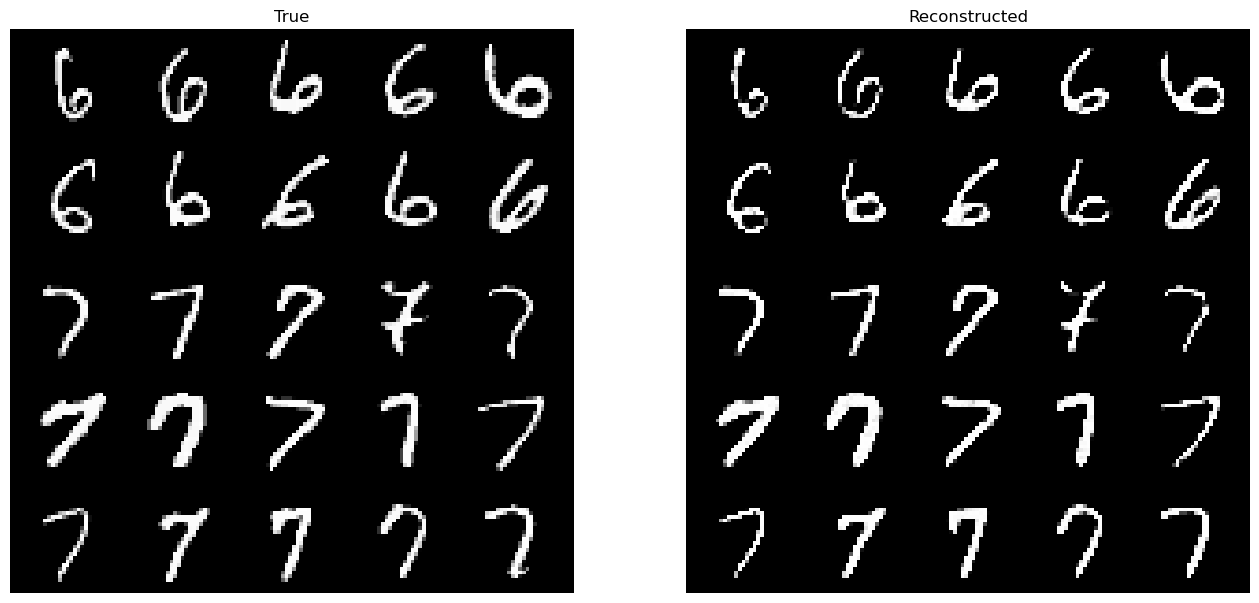

Epoch 1


100%|██████████| 108/108 [00:00<00:00, 154.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


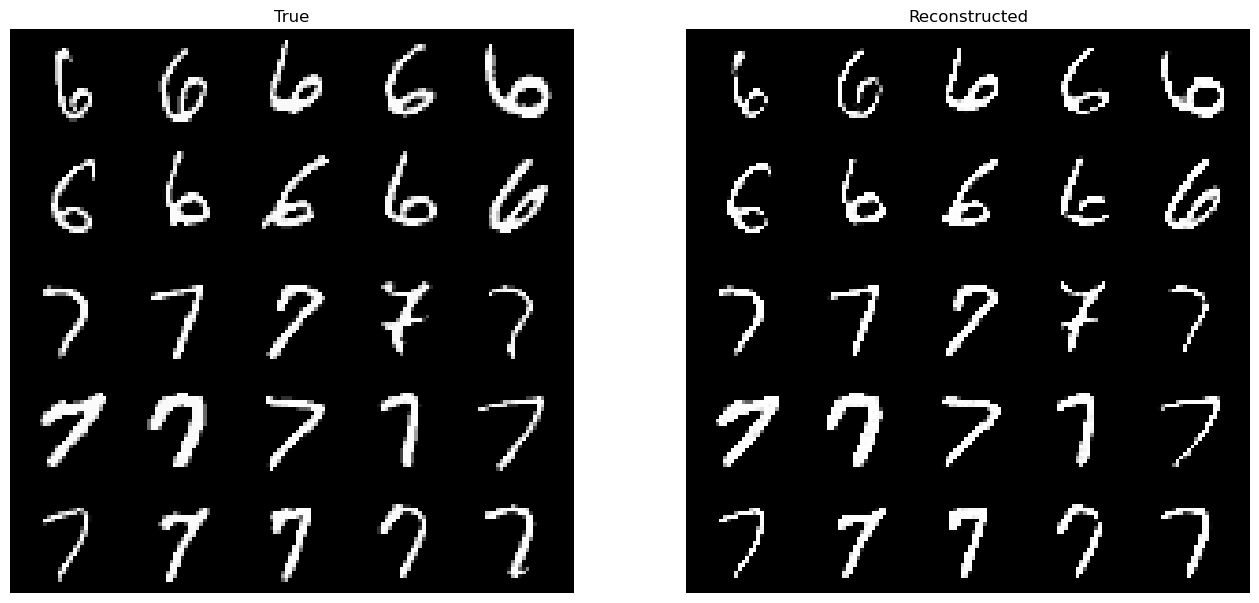

Epoch 2


100%|██████████| 108/108 [00:00<00:00, 176.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


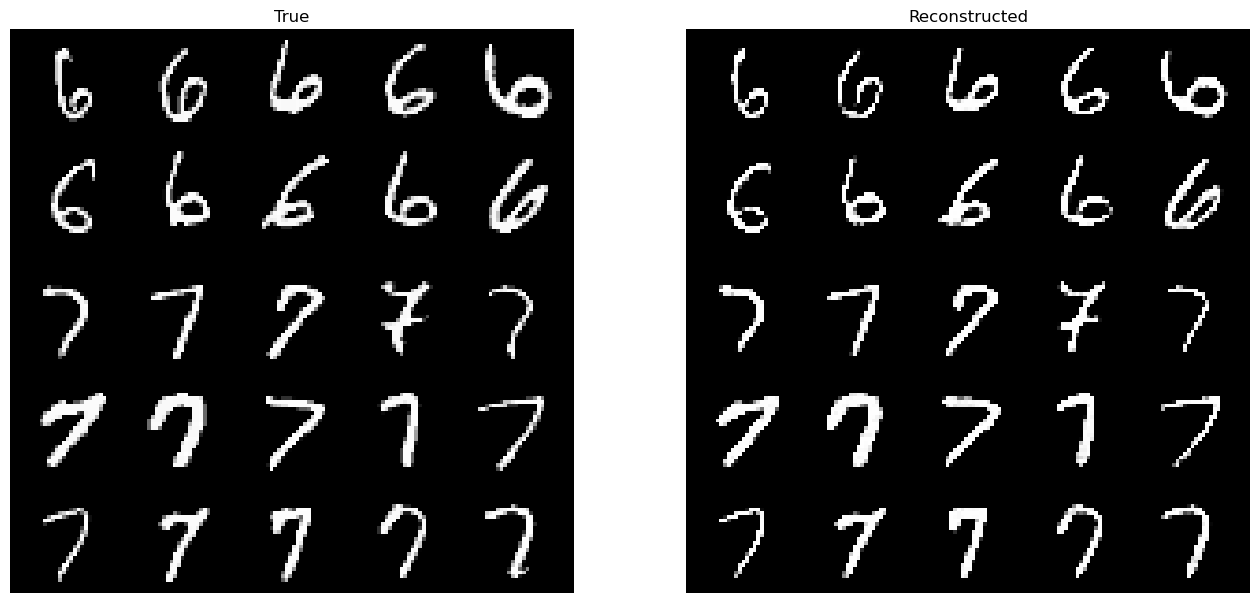

Epoch 3


100%|██████████| 108/108 [00:00<00:00, 175.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


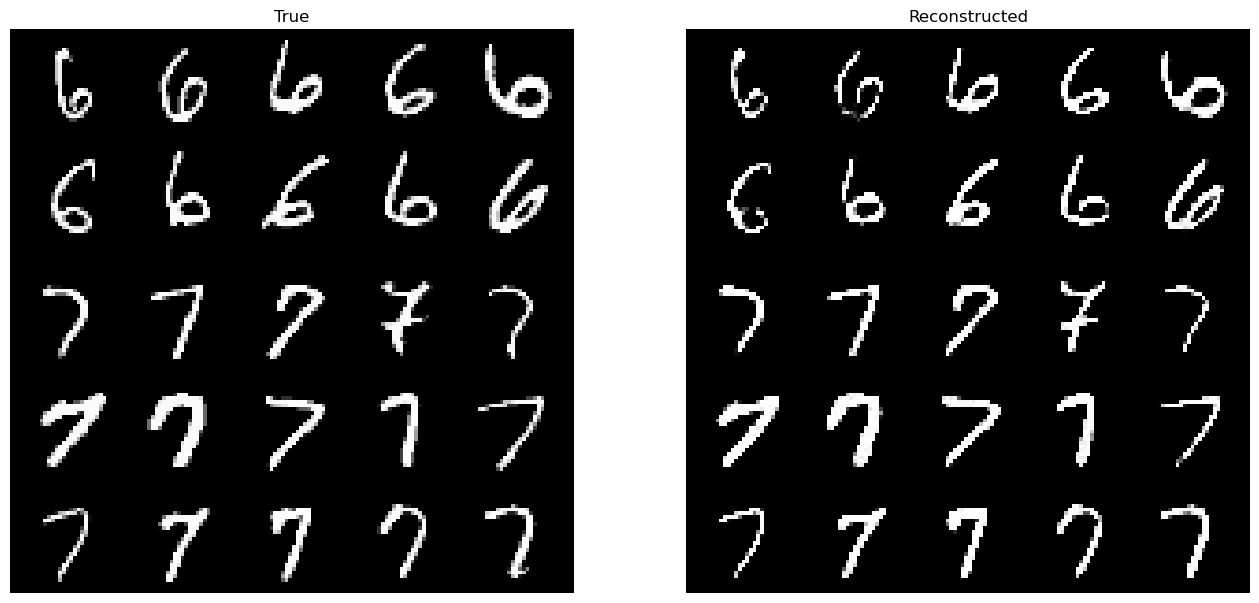

Epoch 4


100%|██████████| 108/108 [00:00<00:00, 176.08it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


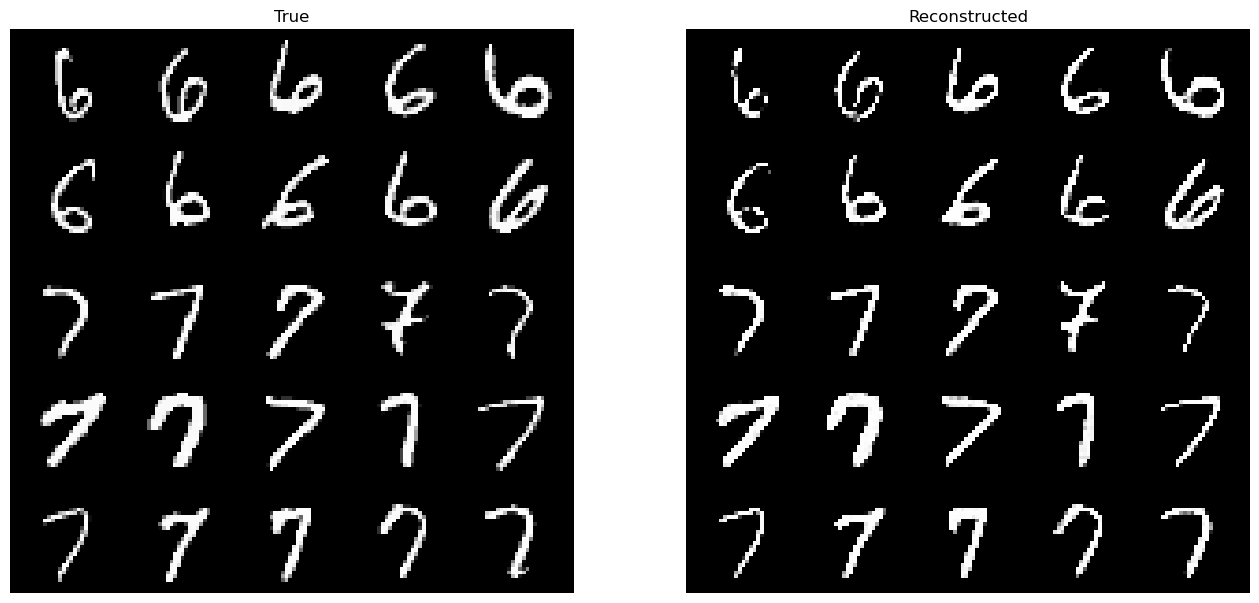

Epoch 5


100%|██████████| 108/108 [00:00<00:00, 171.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


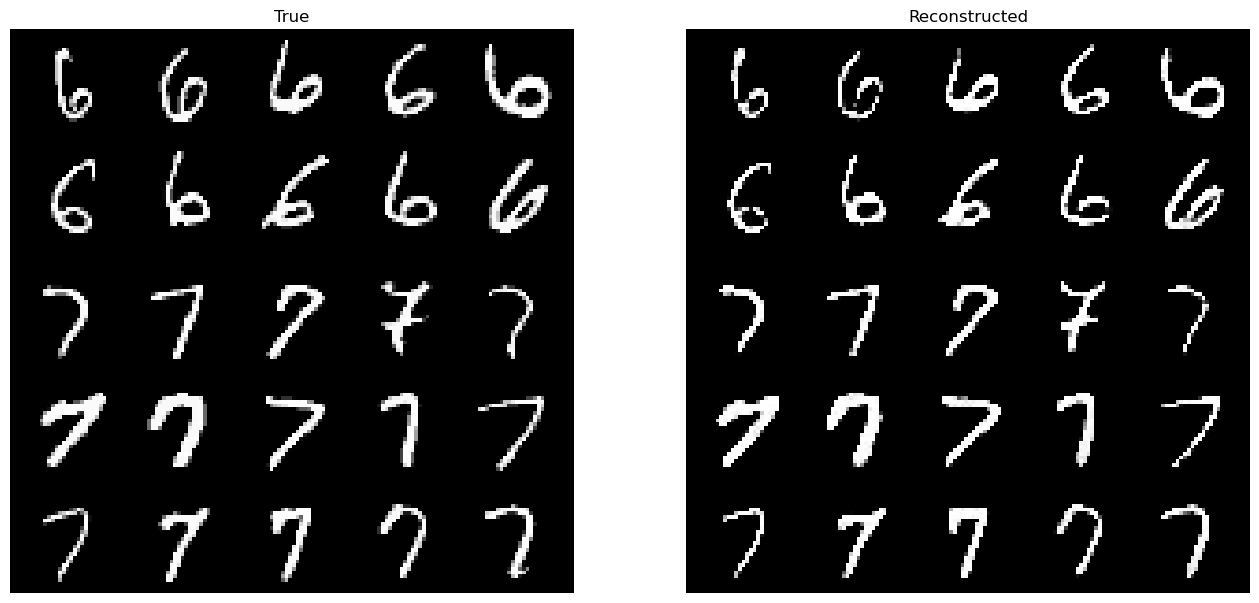

Epoch 6


100%|██████████| 108/108 [00:00<00:00, 174.98it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


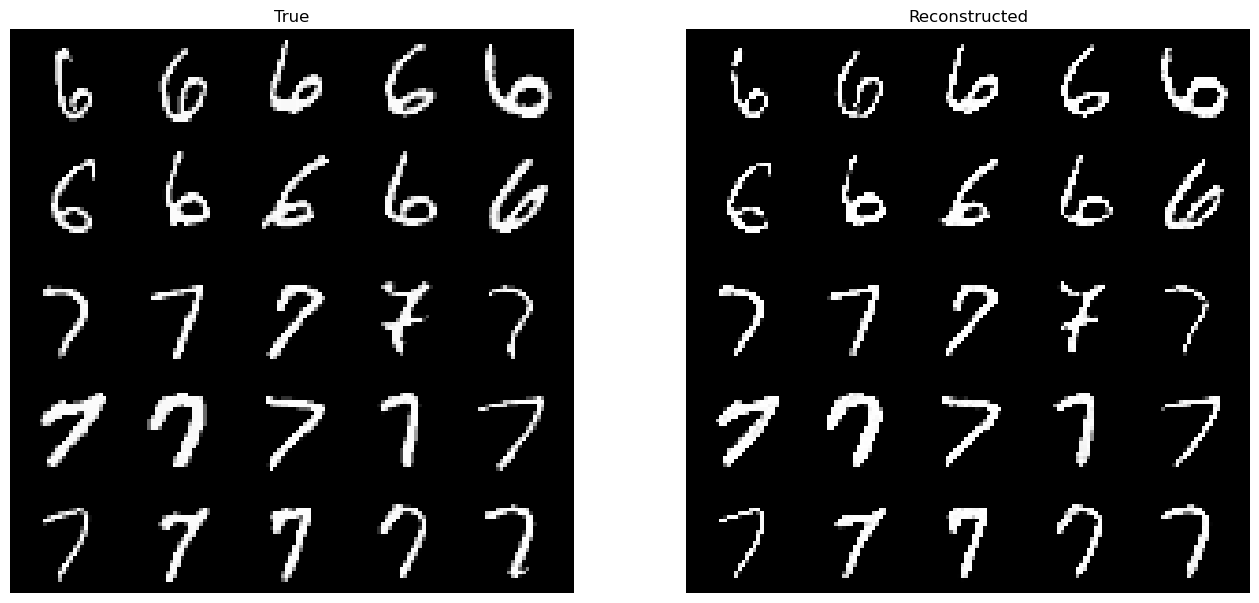

Epoch 7


100%|██████████| 108/108 [00:00<00:00, 152.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


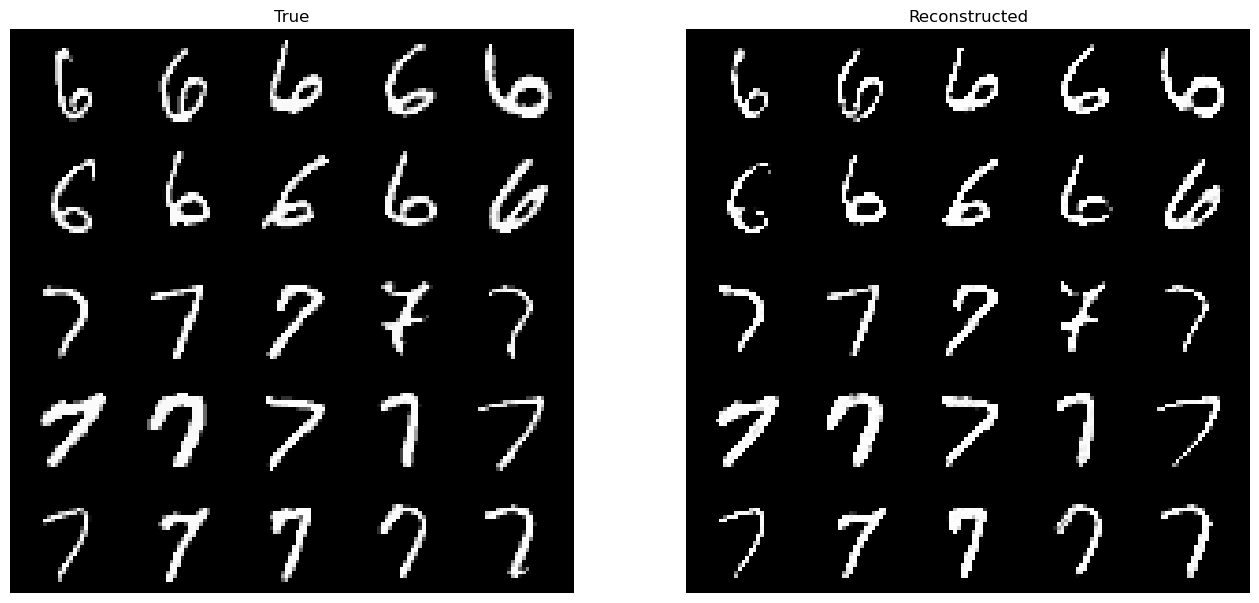

Epoch 8


100%|██████████| 108/108 [00:00<00:00, 174.58it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


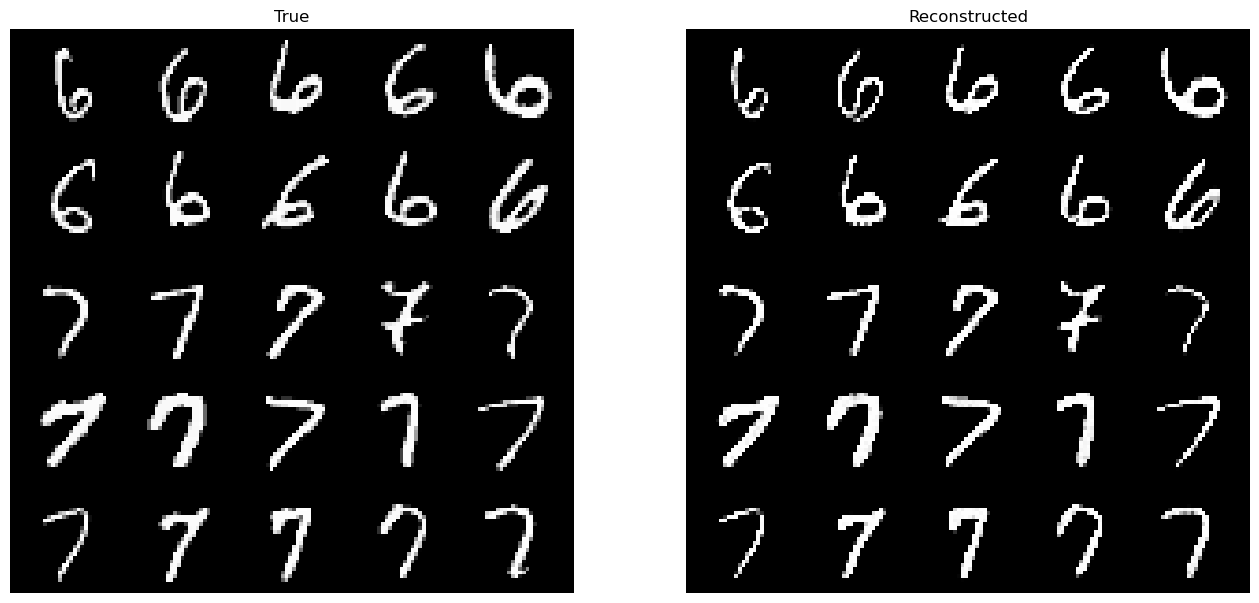

Epoch 9


100%|██████████| 108/108 [00:00<00:00, 174.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


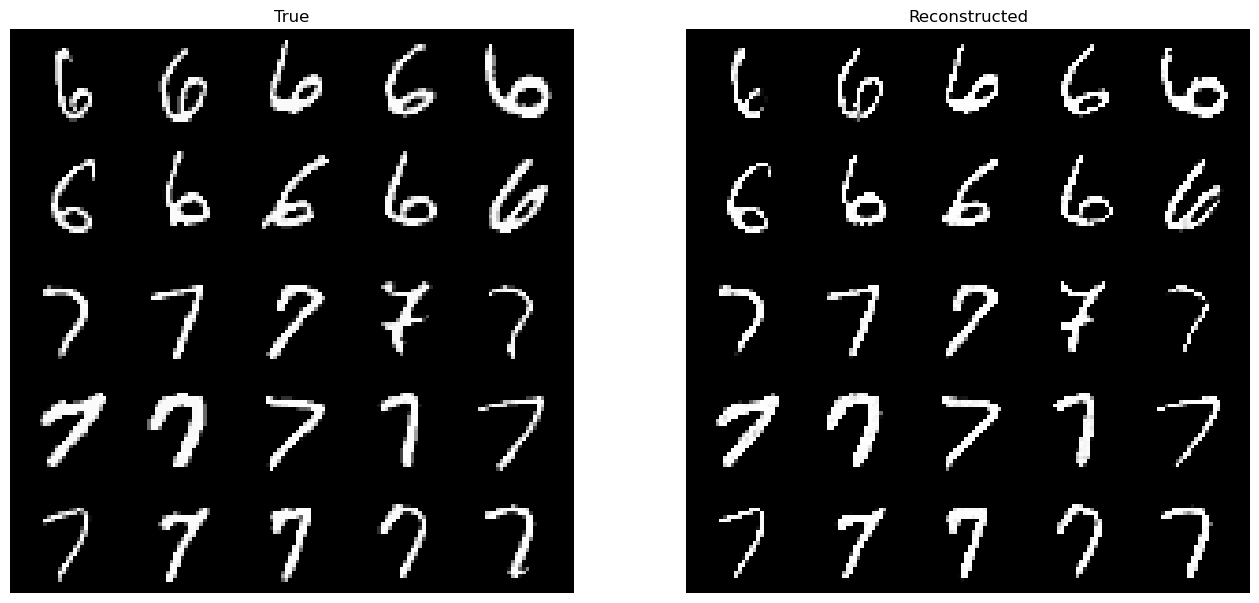

Epoch 0


100%|██████████| 108/108 [00:00<00:00, 165.00it/s]


Epoch 1


100%|██████████| 108/108 [00:00<00:00, 165.04it/s]


Epoch 2


100%|██████████| 108/108 [00:00<00:00, 172.88it/s]


Epoch 3


100%|██████████| 108/108 [00:00<00:00, 175.18it/s]


Epoch 4


100%|██████████| 108/108 [00:00<00:00, 175.26it/s]


Epoch 5


100%|██████████| 108/108 [00:00<00:00, 175.01it/s]


Epoch 6


100%|██████████| 108/108 [00:00<00:00, 175.03it/s]


Epoch 7


100%|██████████| 108/108 [00:00<00:00, 174.91it/s]


Epoch 8


100%|██████████| 108/108 [00:00<00:00, 174.94it/s]


Epoch 9


100%|██████████| 108/108 [00:00<00:00, 171.00it/s]


Epoch 0


100%|██████████| 108/108 [00:00<00:00, 175.19it/s]


Epoch 1


100%|██████████| 108/108 [00:00<00:00, 174.73it/s]


Epoch 2


100%|██████████| 108/108 [00:00<00:00, 174.50it/s]


Epoch 3


100%|██████████| 108/108 [00:00<00:00, 174.69it/s]


Epoch 4


100%|██████████| 108/108 [00:00<00:00, 158.17it/s]


Epoch 5


100%|██████████| 108/108 [00:00<00:00, 176.24it/s]


Epoch 6


100%|██████████| 108/108 [00:00<00:00, 173.80it/s]


Epoch 7


100%|██████████| 108/108 [00:00<00:00, 168.44it/s]


Epoch 8


100%|██████████| 108/108 [00:00<00:00, 168.22it/s]


Epoch 9


100%|██████████| 108/108 [00:00<00:00, 173.59it/s]


Epoch 0


100%|██████████| 108/108 [00:00<00:00, 173.05it/s]


Epoch 1


100%|██████████| 108/108 [00:00<00:00, 173.24it/s]


Epoch 2


100%|██████████| 108/108 [00:00<00:00, 173.43it/s]


Epoch 3


100%|██████████| 108/108 [00:00<00:00, 173.67it/s]


Epoch 4


100%|██████████| 108/108 [00:00<00:00, 172.99it/s]


Epoch 5


100%|██████████| 108/108 [00:00<00:00, 170.71it/s]


Epoch 6


100%|██████████| 108/108 [00:00<00:00, 139.88it/s]


Epoch 7


100%|██████████| 108/108 [00:00<00:00, 156.41it/s]


Epoch 8


100%|██████████| 108/108 [00:00<00:00, 159.66it/s]


Epoch 9


100%|██████████| 108/108 [00:00<00:00, 143.90it/s]


Epoch 0


100%|██████████| 118/118 [00:00<00:00, 173.89it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


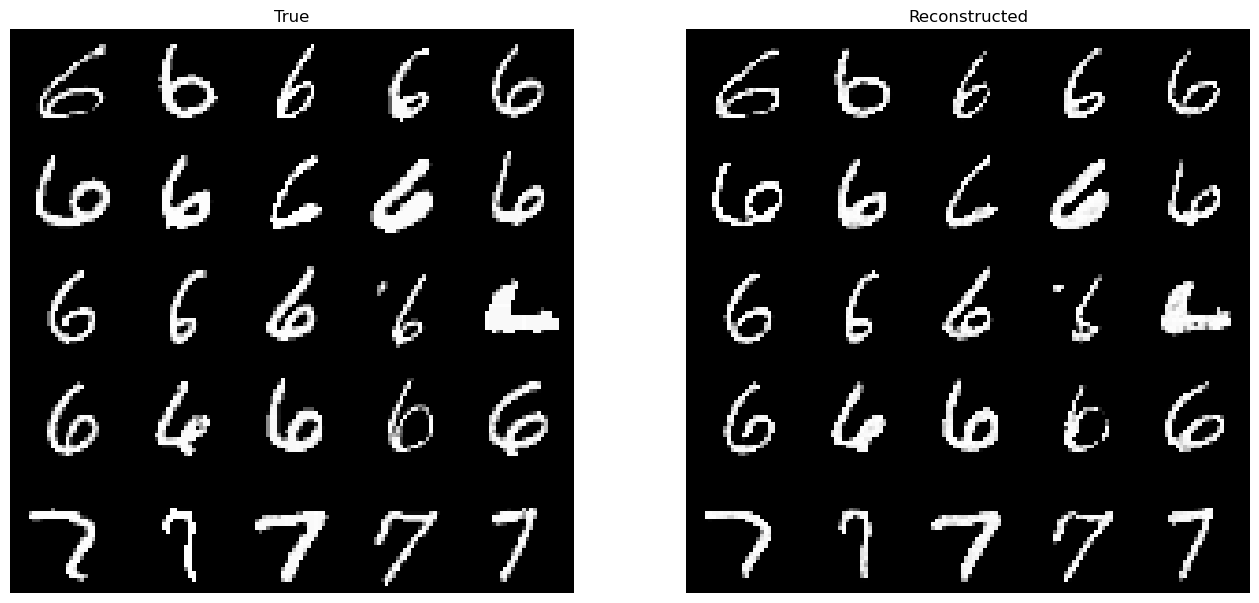

Epoch 1


100%|██████████| 118/118 [00:00<00:00, 164.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


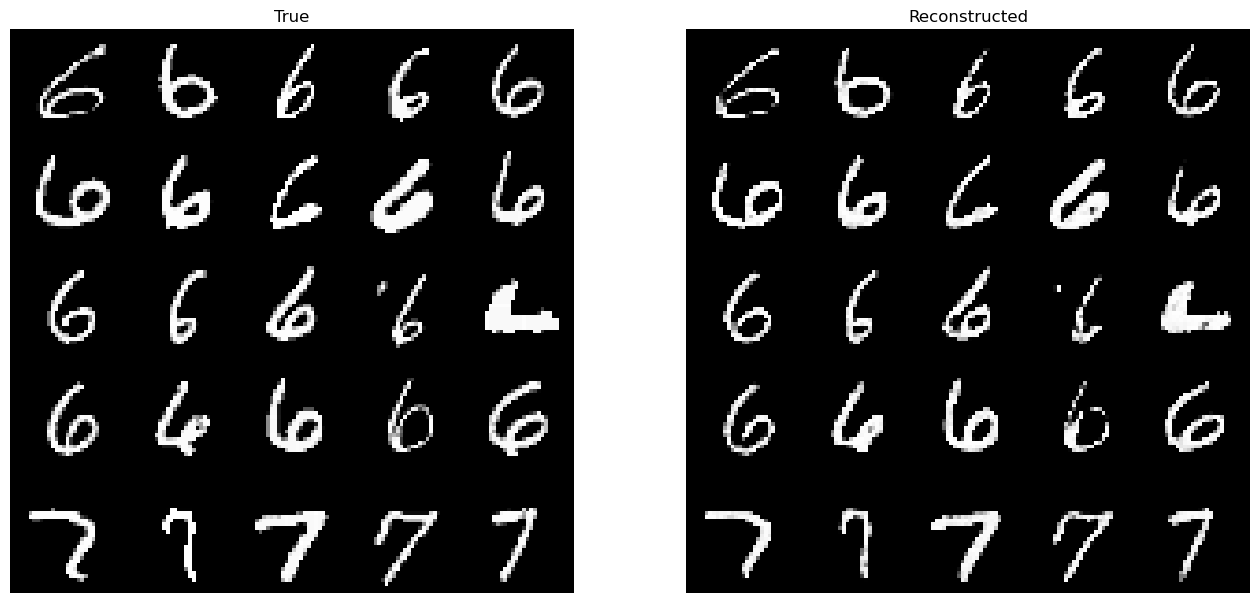

Epoch 2


100%|██████████| 118/118 [00:00<00:00, 174.61it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


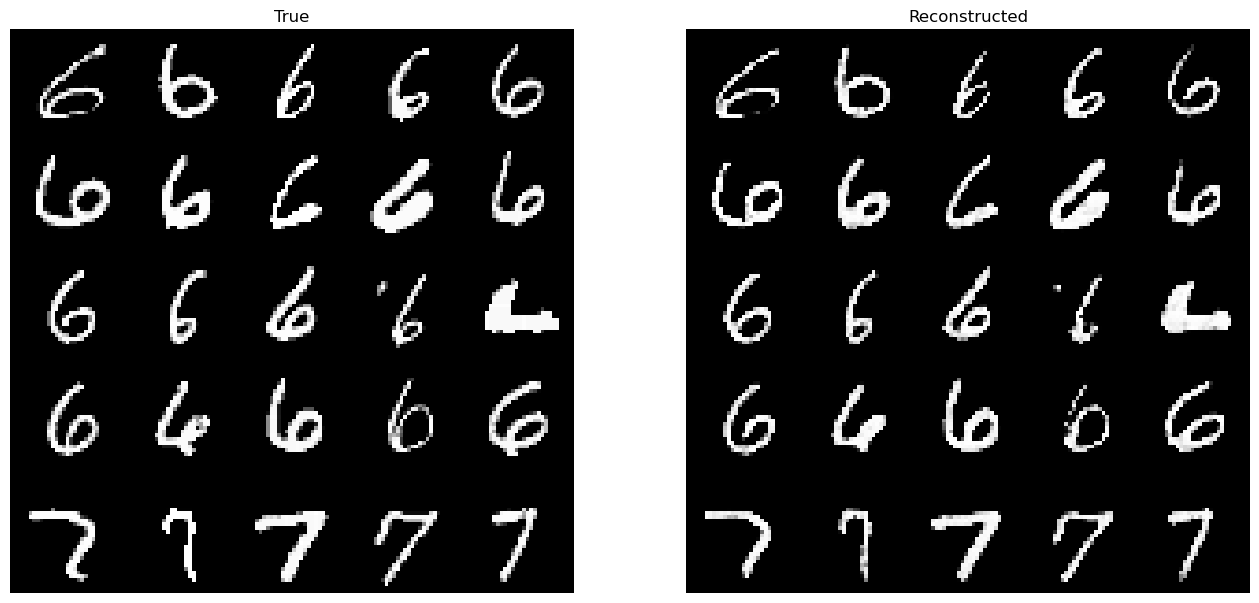

Epoch 3


100%|██████████| 118/118 [00:00<00:00, 174.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


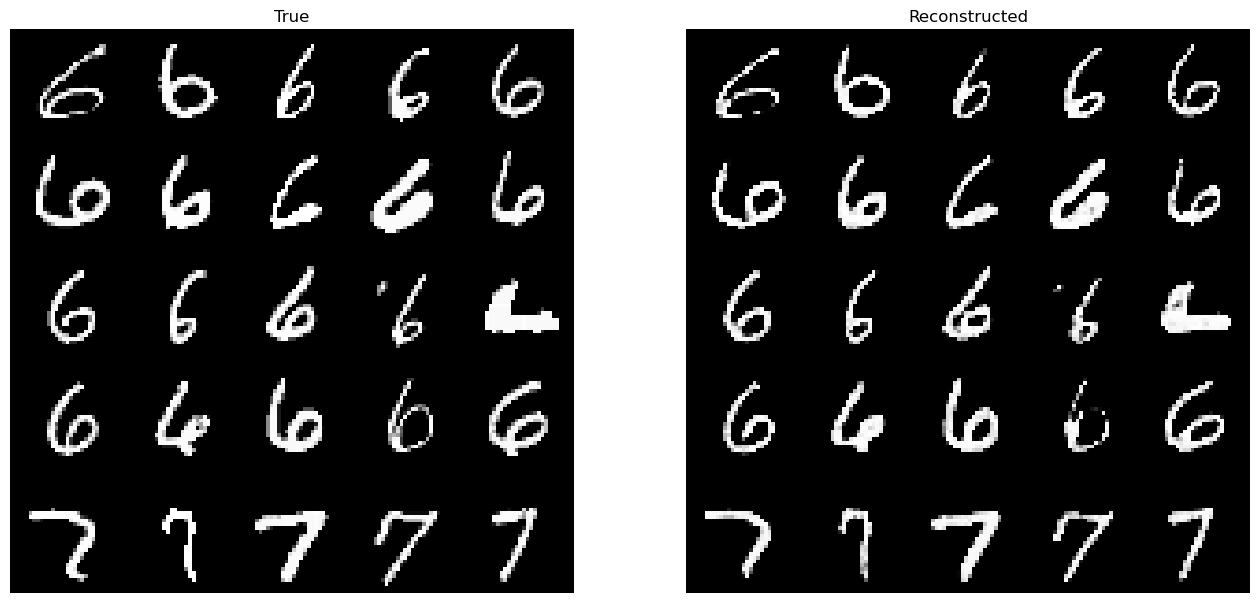

Epoch 4


100%|██████████| 118/118 [00:00<00:00, 175.99it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


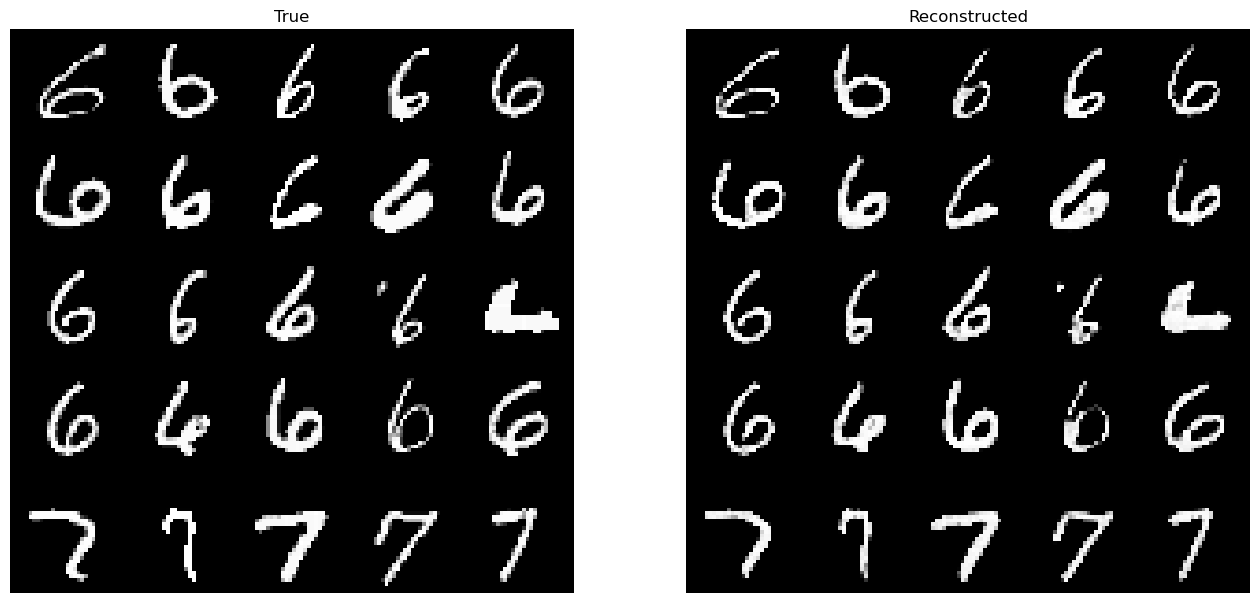

Epoch 5


100%|██████████| 118/118 [00:00<00:00, 175.87it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


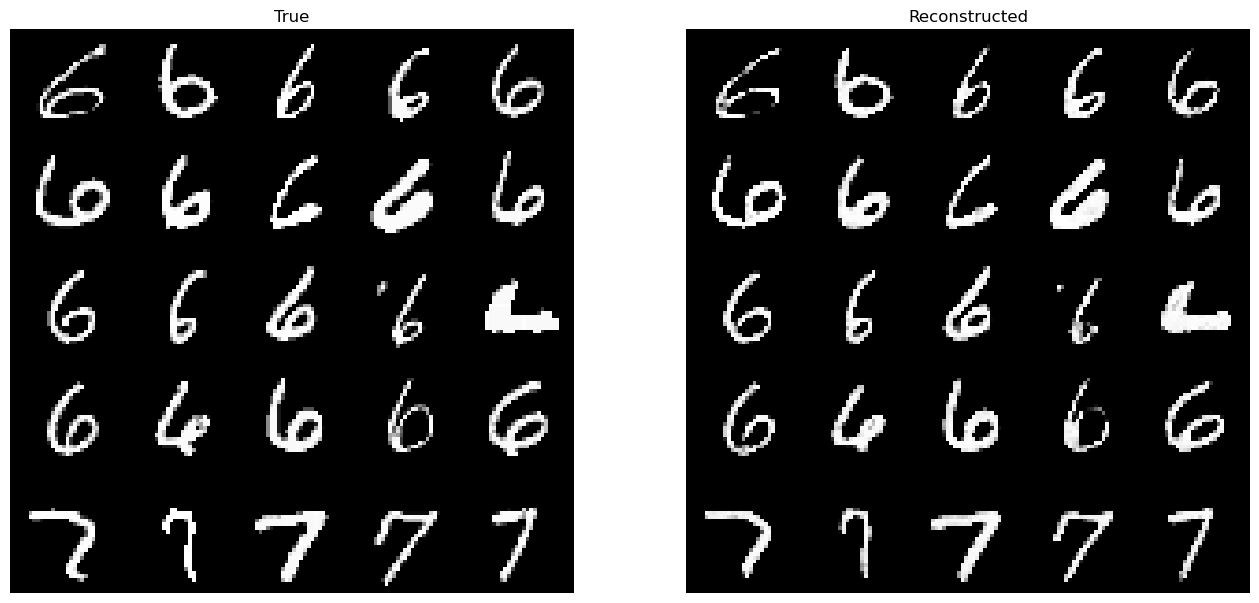

Epoch 6


100%|██████████| 118/118 [00:00<00:00, 176.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


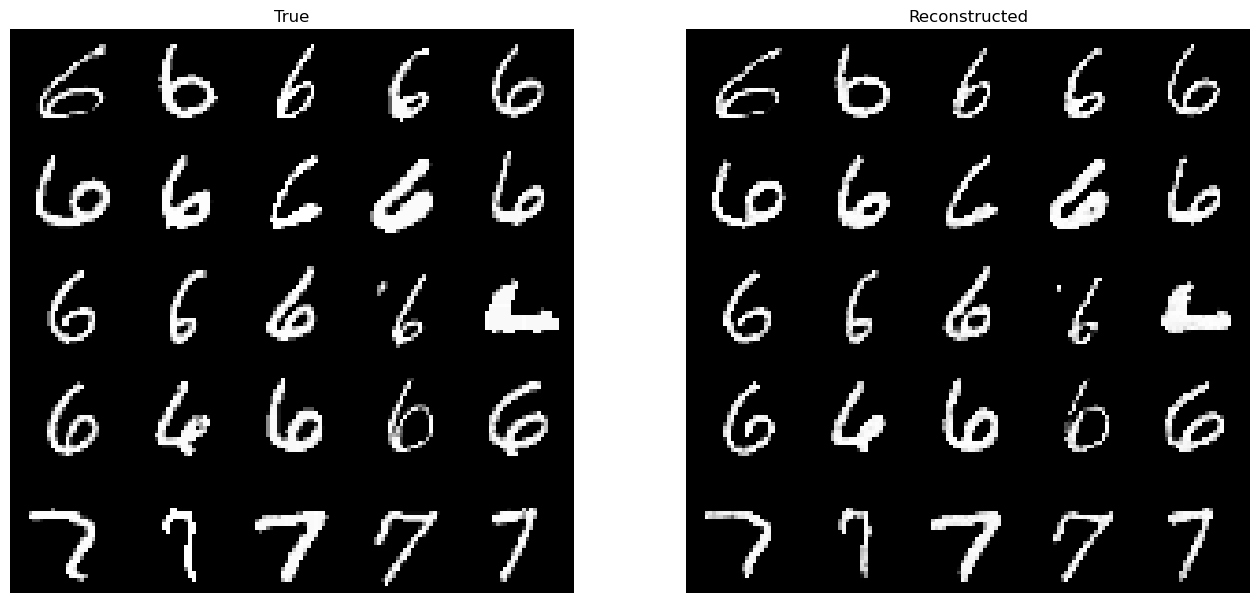

Epoch 7


100%|██████████| 118/118 [00:00<00:00, 174.42it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


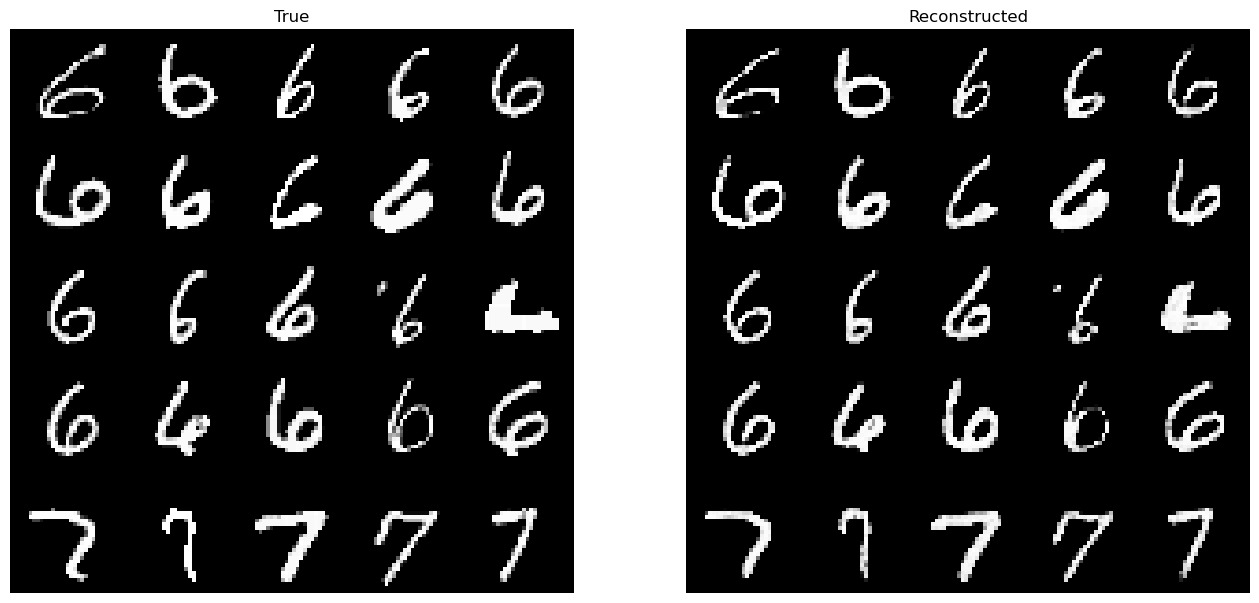

Epoch 8


100%|██████████| 118/118 [00:00<00:00, 176.25it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


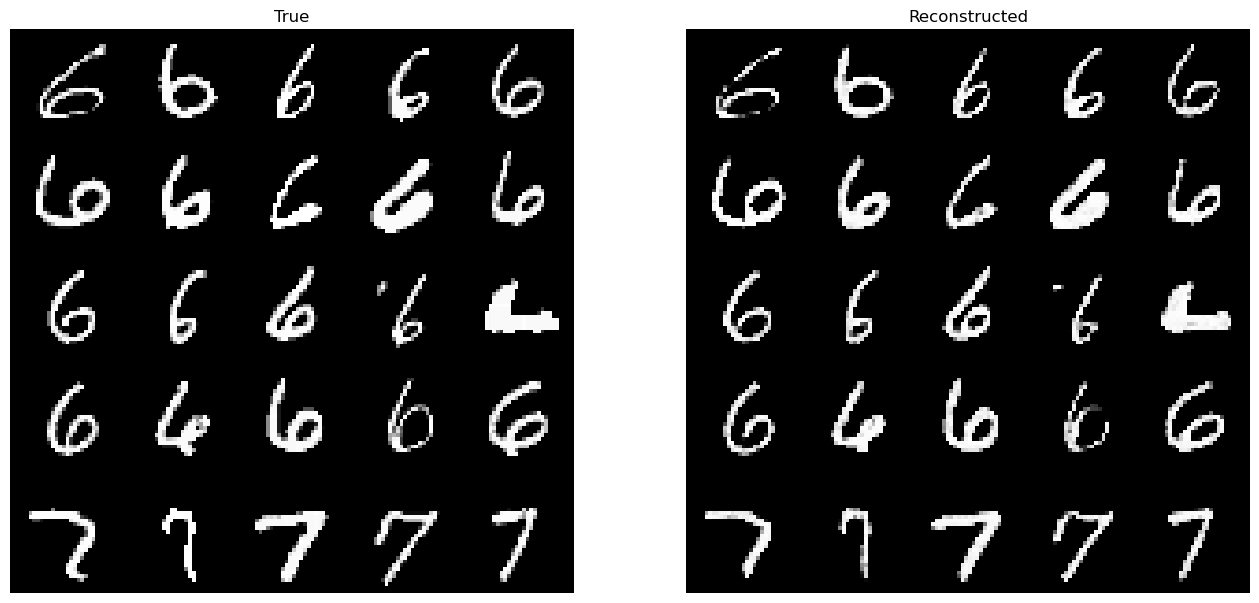

Epoch 9


100%|██████████| 118/118 [00:00<00:00, 175.30it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


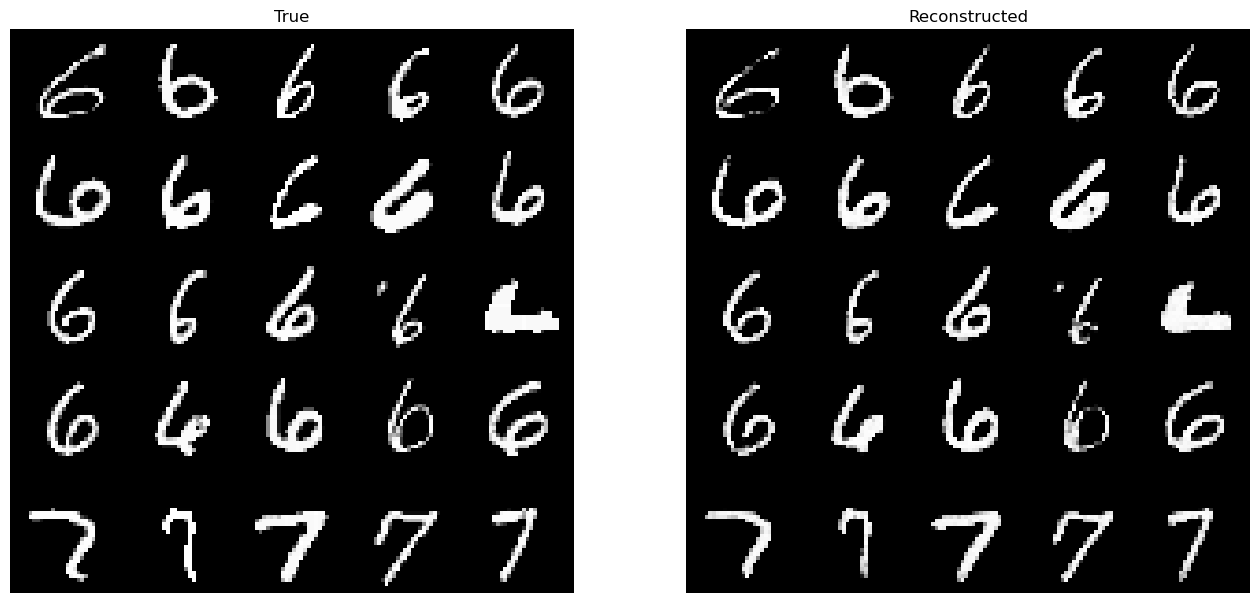

Epoch 0


100%|██████████| 118/118 [00:00<00:00, 176.22it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


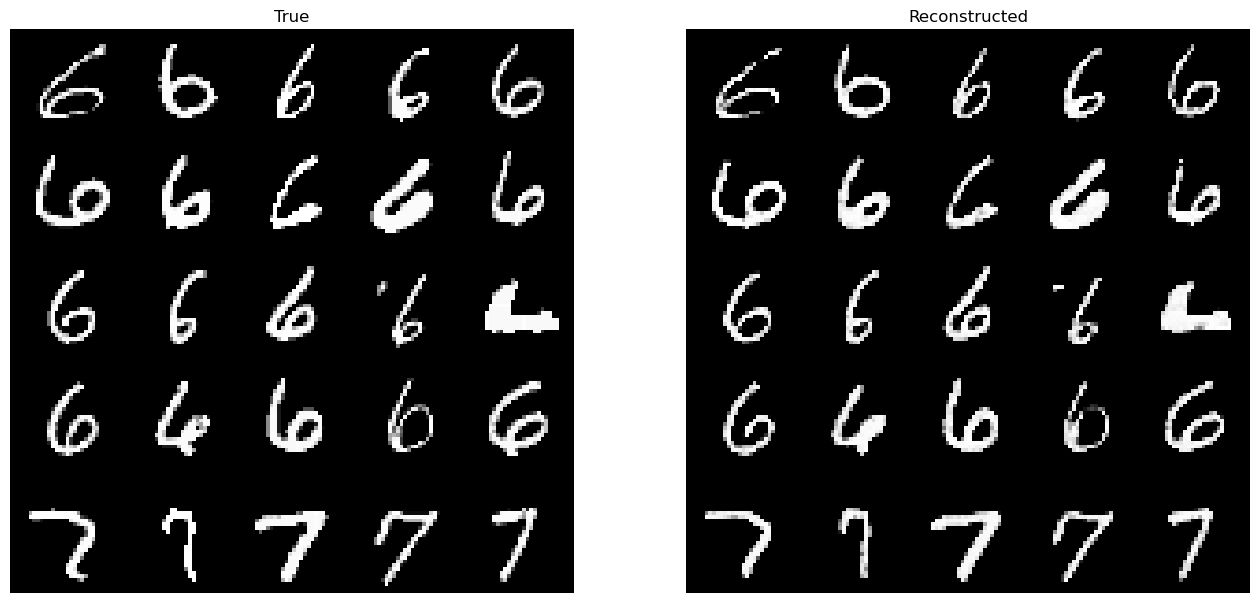

Epoch 1


100%|██████████| 118/118 [00:00<00:00, 175.71it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


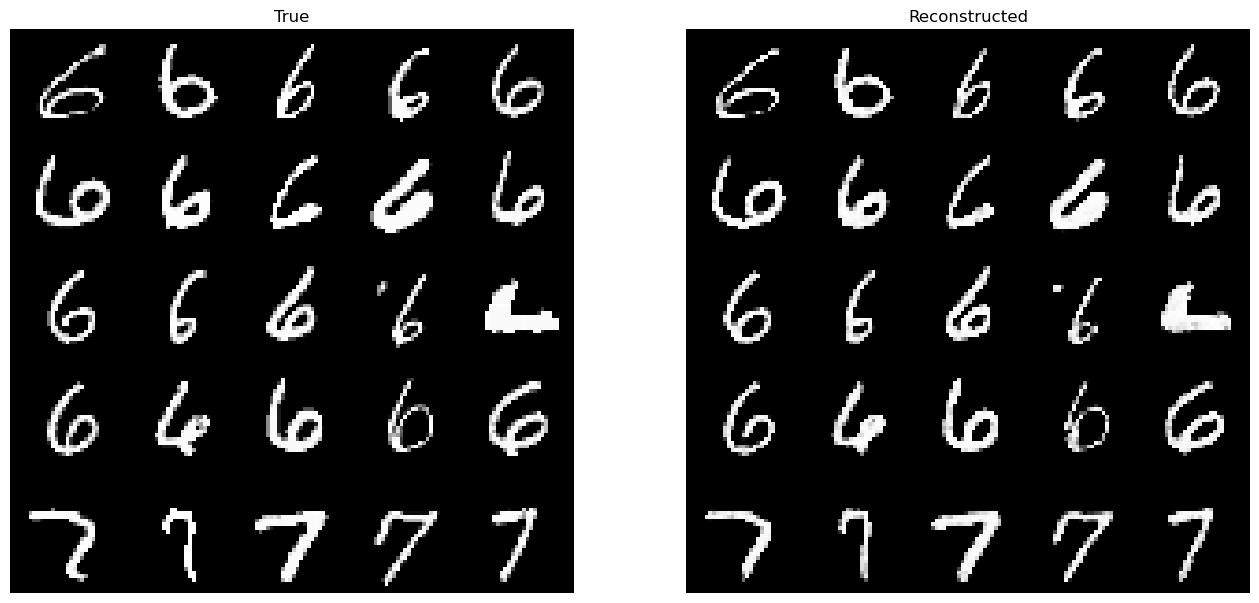

Epoch 2


100%|██████████| 118/118 [00:00<00:00, 176.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


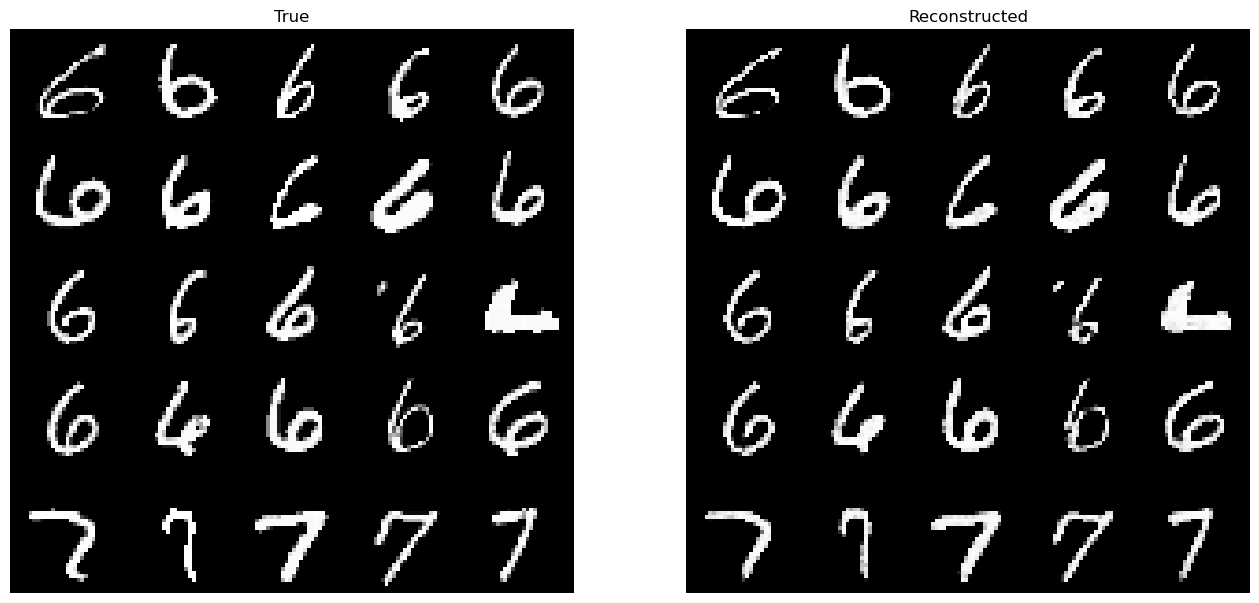

Epoch 3


100%|██████████| 118/118 [00:00<00:00, 176.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


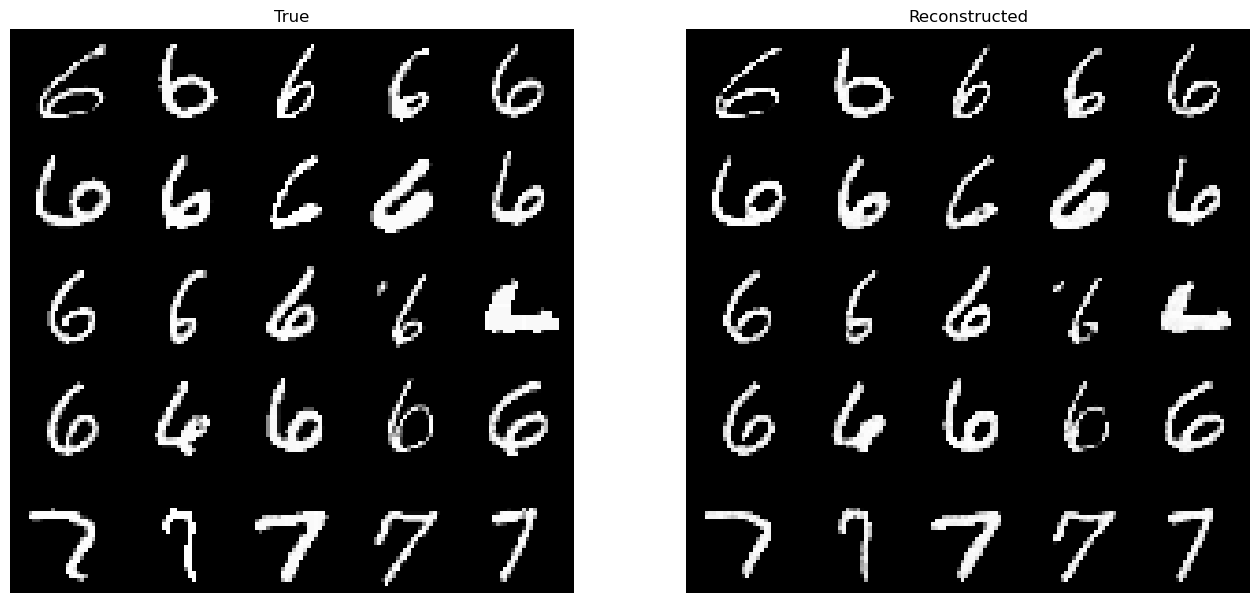

Epoch 4


100%|██████████| 118/118 [00:00<00:00, 176.02it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


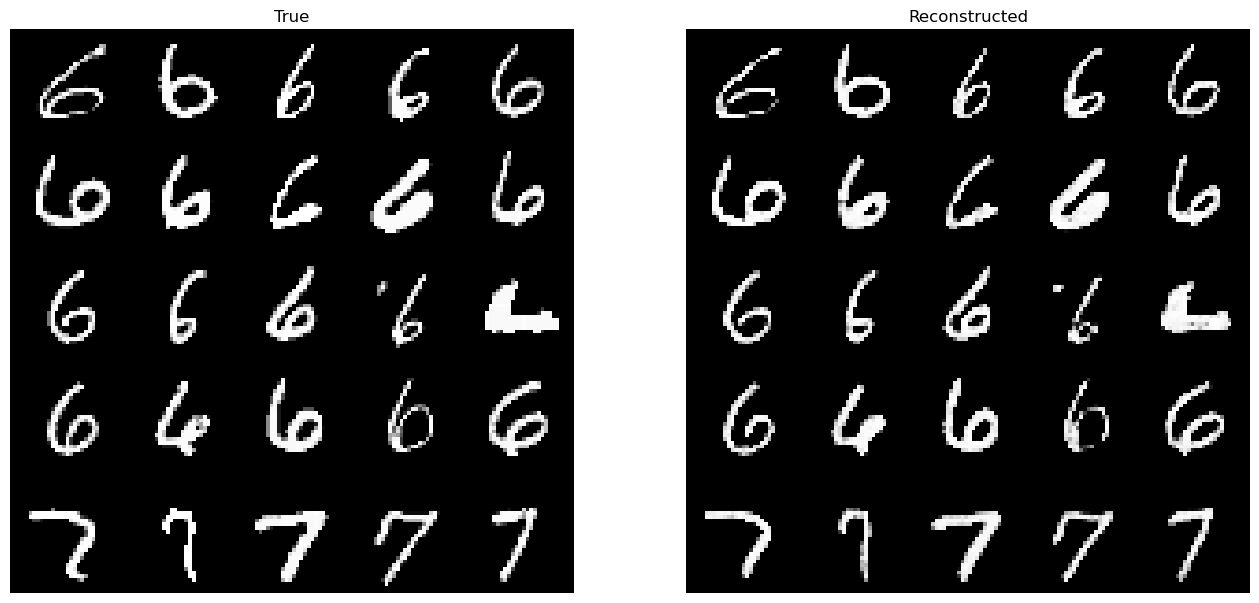

Epoch 5


100%|██████████| 118/118 [00:00<00:00, 174.98it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


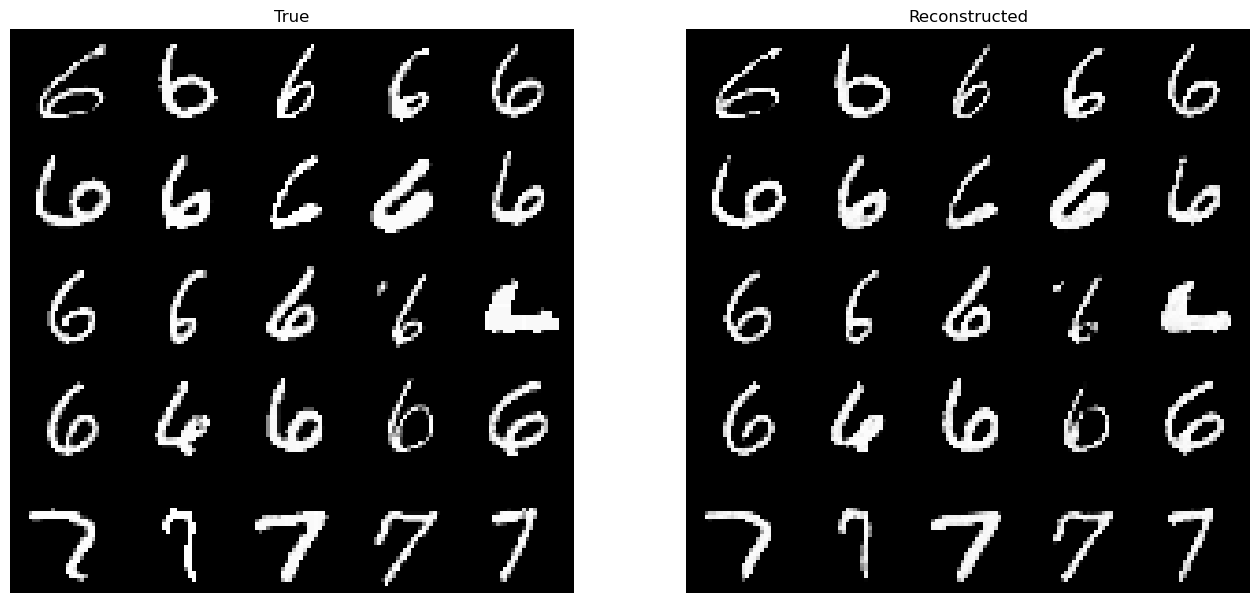

Epoch 6


100%|██████████| 118/118 [00:00<00:00, 176.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


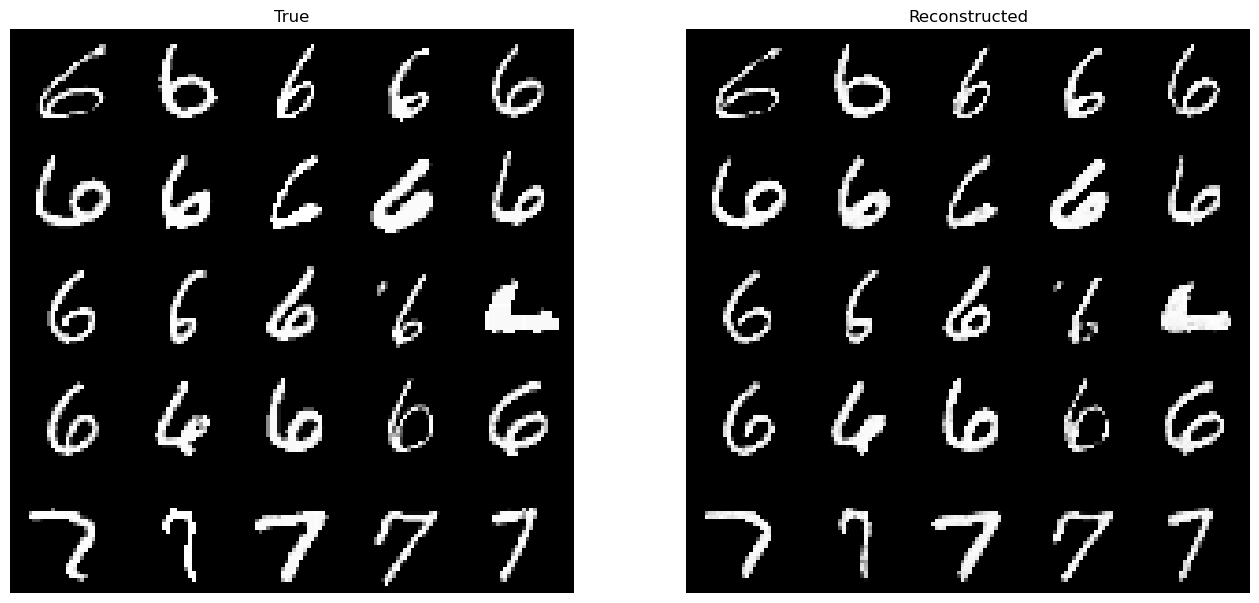

Epoch 7


100%|██████████| 118/118 [00:00<00:00, 168.22it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


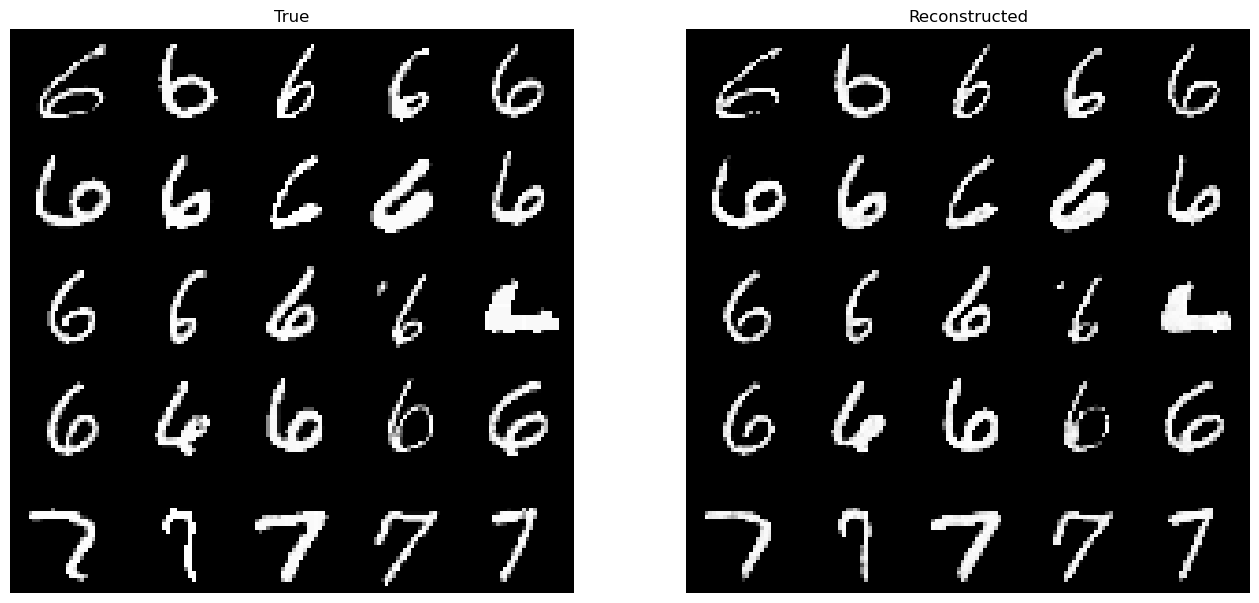

Epoch 8


100%|██████████| 118/118 [00:00<00:00, 154.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


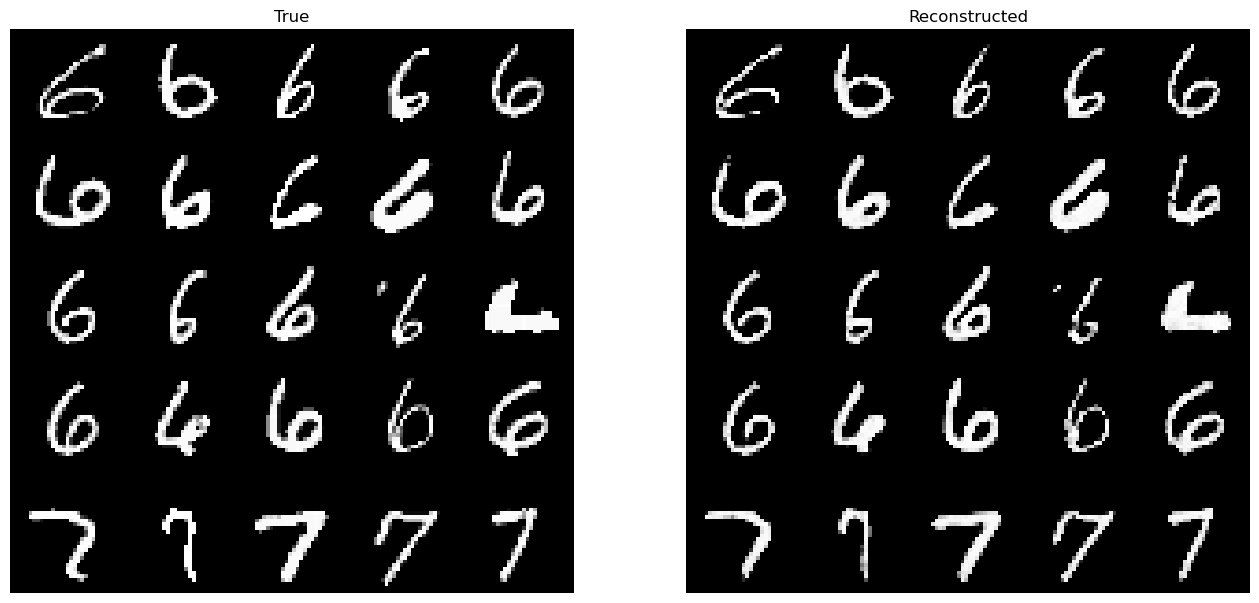

Epoch 9


100%|██████████| 118/118 [00:00<00:00, 174.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


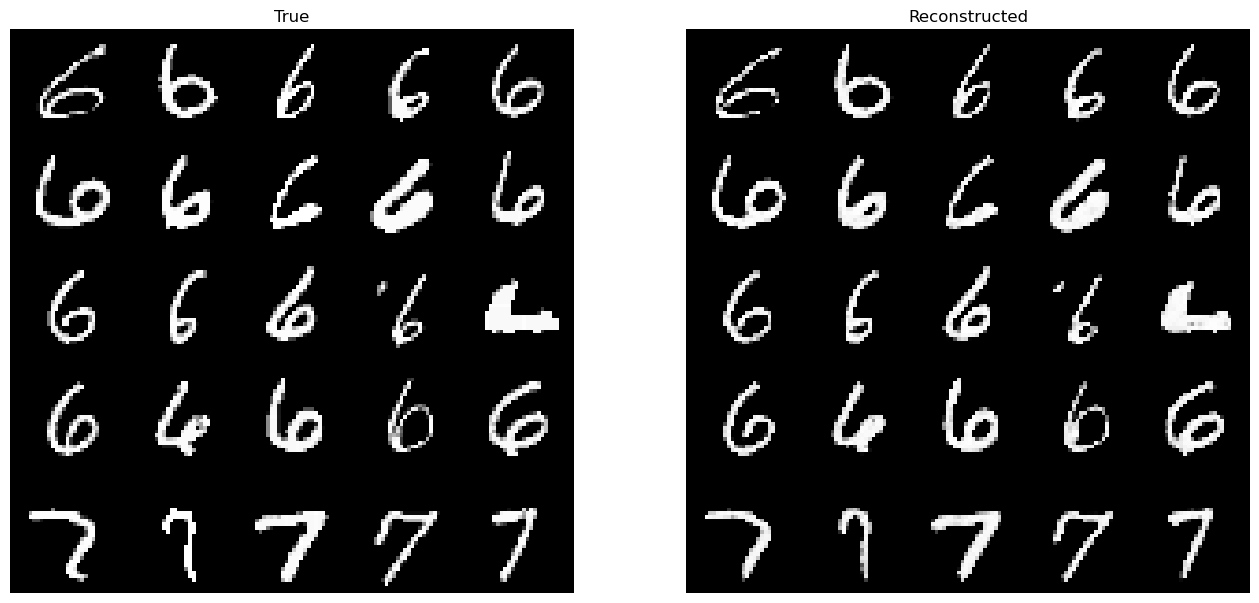

Epoch 0


100%|██████████| 118/118 [00:00<00:00, 174.28it/s]


Epoch 1


100%|██████████| 118/118 [00:00<00:00, 151.52it/s]


Epoch 2


100%|██████████| 118/118 [00:00<00:00, 175.30it/s]


Epoch 3


100%|██████████| 118/118 [00:00<00:00, 176.23it/s]


Epoch 4


100%|██████████| 118/118 [00:00<00:00, 176.18it/s]


Epoch 5


100%|██████████| 118/118 [00:00<00:00, 175.21it/s]


Epoch 6


100%|██████████| 118/118 [00:00<00:00, 174.09it/s]


Epoch 7


100%|██████████| 118/118 [00:00<00:00, 170.42it/s]


Epoch 8


100%|██████████| 118/118 [00:00<00:00, 159.20it/s]


Epoch 9


100%|██████████| 118/118 [00:00<00:00, 174.28it/s]


Epoch 0


100%|██████████| 118/118 [00:00<00:00, 161.04it/s]


Epoch 1


100%|██████████| 118/118 [00:00<00:00, 173.96it/s]


Epoch 2


100%|██████████| 118/118 [00:00<00:00, 174.45it/s]


Epoch 3


100%|██████████| 118/118 [00:00<00:00, 156.70it/s]


Epoch 4


100%|██████████| 118/118 [00:00<00:00, 174.91it/s]


Epoch 5


100%|██████████| 118/118 [00:00<00:00, 175.19it/s]


Epoch 6


100%|██████████| 118/118 [00:00<00:00, 176.17it/s]


Epoch 7


100%|██████████| 118/118 [00:00<00:00, 175.68it/s]


Epoch 8


100%|██████████| 118/118 [00:00<00:00, 175.56it/s]


Epoch 9


100%|██████████| 118/118 [00:00<00:00, 175.90it/s]


Epoch 0


100%|██████████| 118/118 [00:00<00:00, 175.41it/s]


Epoch 1


100%|██████████| 118/118 [00:00<00:00, 158.06it/s]


Epoch 2


100%|██████████| 118/118 [00:00<00:00, 174.28it/s]


Epoch 3


100%|██████████| 118/118 [00:00<00:00, 174.30it/s]


Epoch 4


100%|██████████| 118/118 [00:00<00:00, 174.11it/s]


Epoch 5


100%|██████████| 118/118 [00:00<00:00, 175.28it/s]


Epoch 6


100%|██████████| 118/118 [00:00<00:00, 174.57it/s]


Epoch 7


100%|██████████| 118/118 [00:00<00:00, 173.43it/s]


Epoch 8


100%|██████████| 118/118 [00:00<00:00, 171.67it/s]


Epoch 9


100%|██████████| 118/118 [00:00<00:00, 175.28it/s]


Epoch 0


100%|██████████| 132/132 [00:00<00:00, 171.02it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


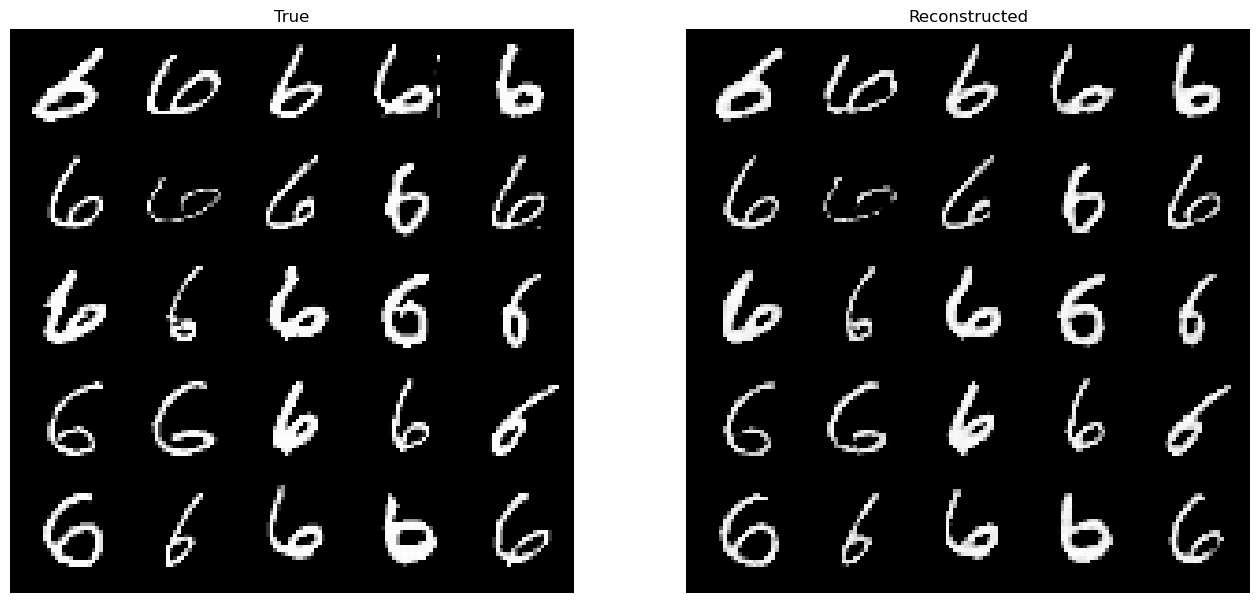

Epoch 1


100%|██████████| 132/132 [00:00<00:00, 171.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


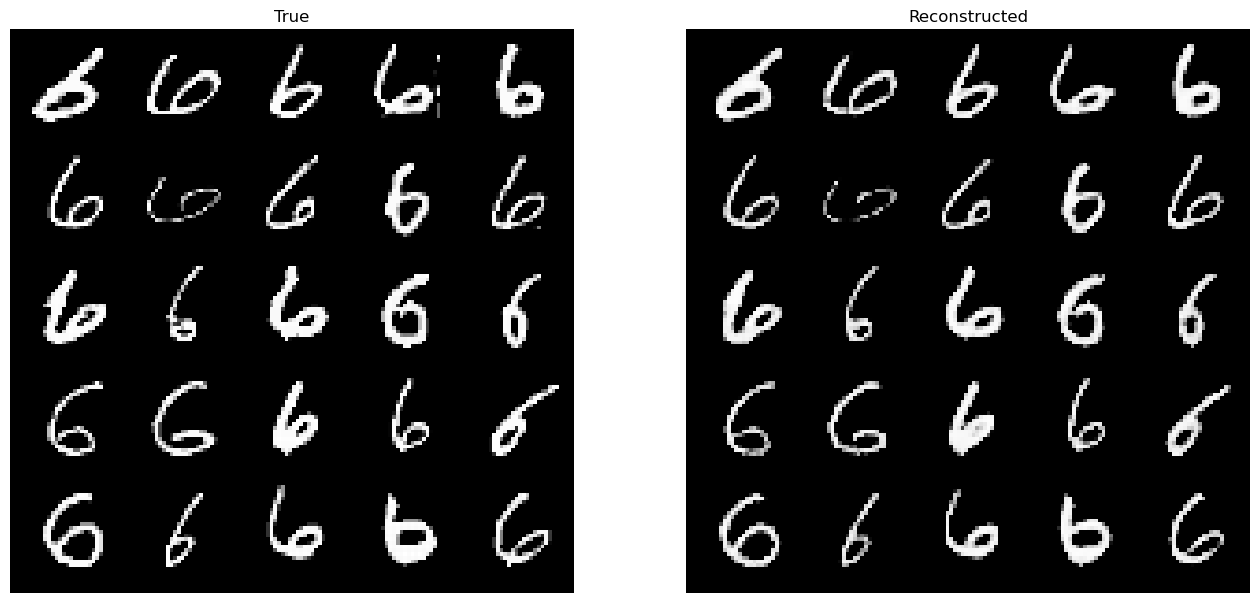

Epoch 2


100%|██████████| 132/132 [00:00<00:00, 156.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


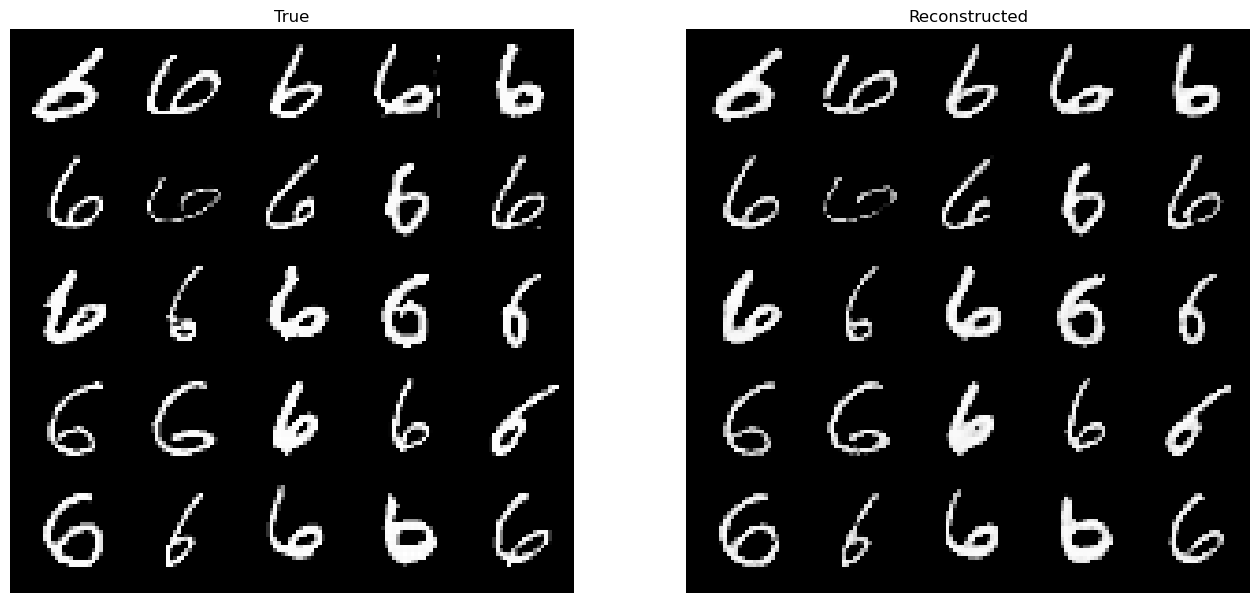

Epoch 3


100%|██████████| 132/132 [00:00<00:00, 160.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


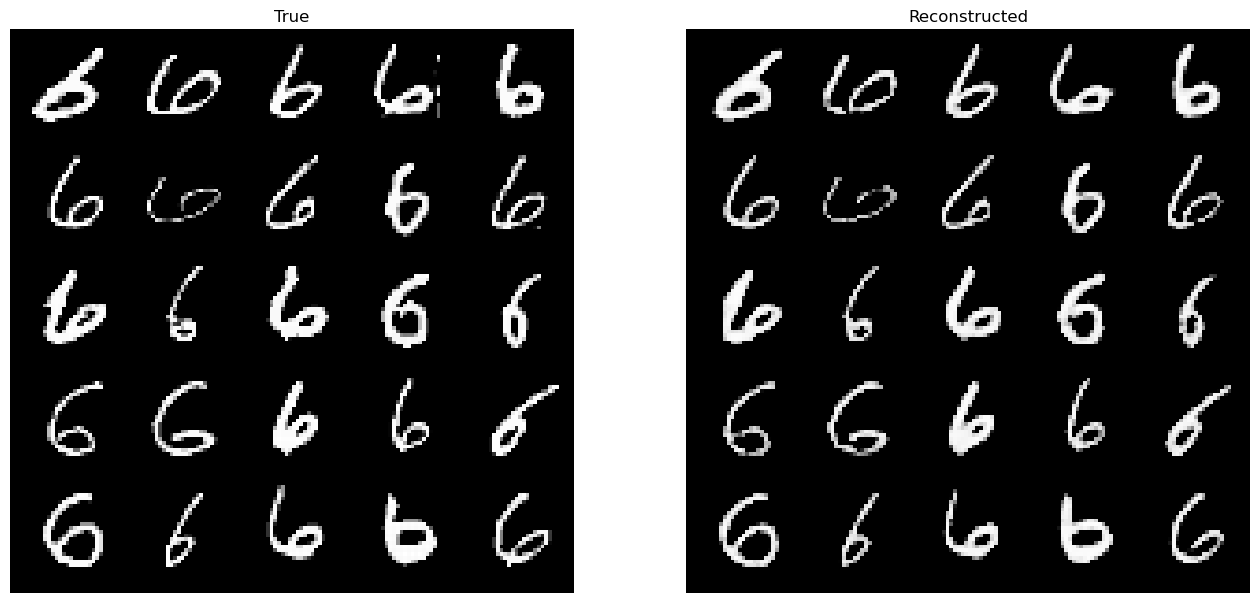

Epoch 4


100%|██████████| 132/132 [00:00<00:00, 160.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


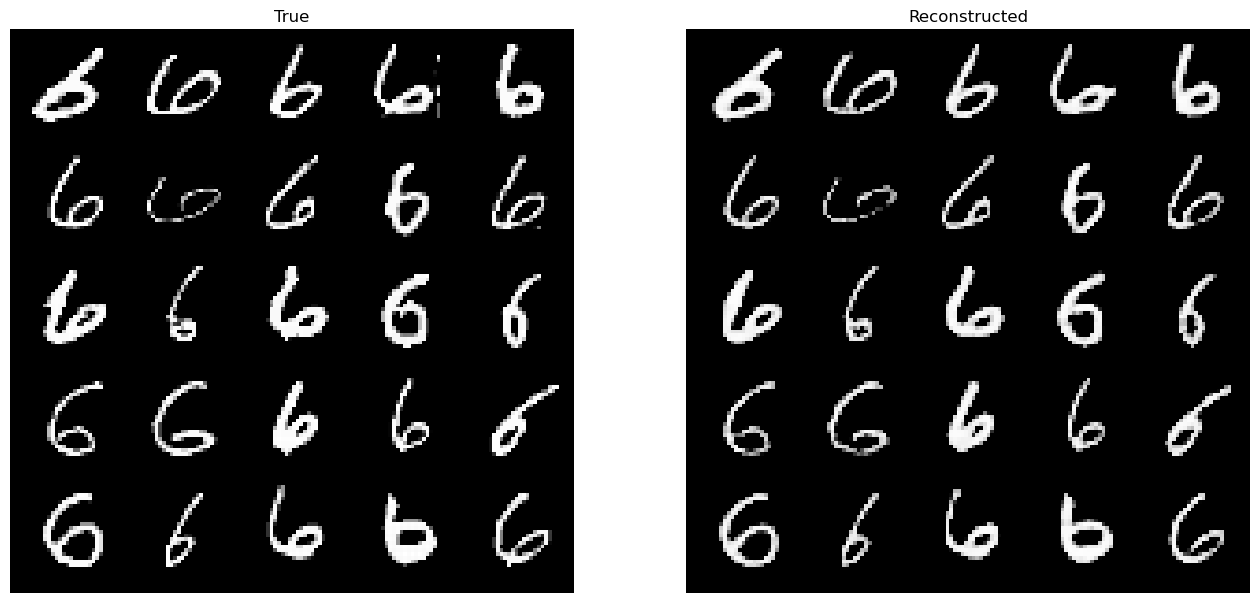

Epoch 5


100%|██████████| 132/132 [00:00<00:00, 173.48it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


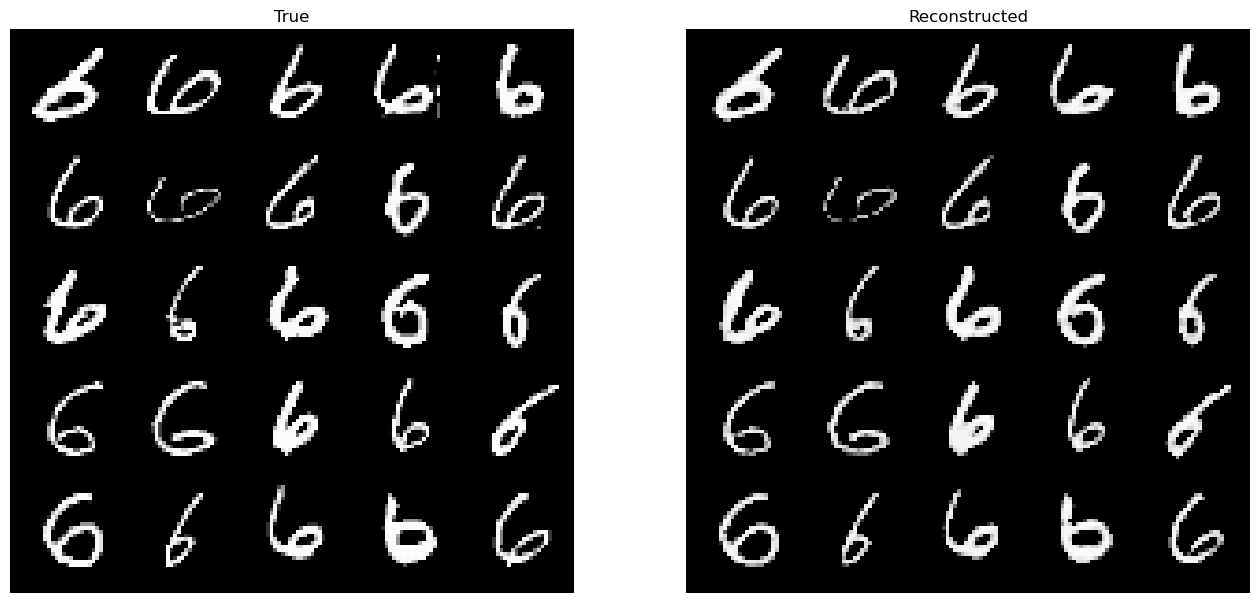

Epoch 6


100%|██████████| 132/132 [00:00<00:00, 168.32it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


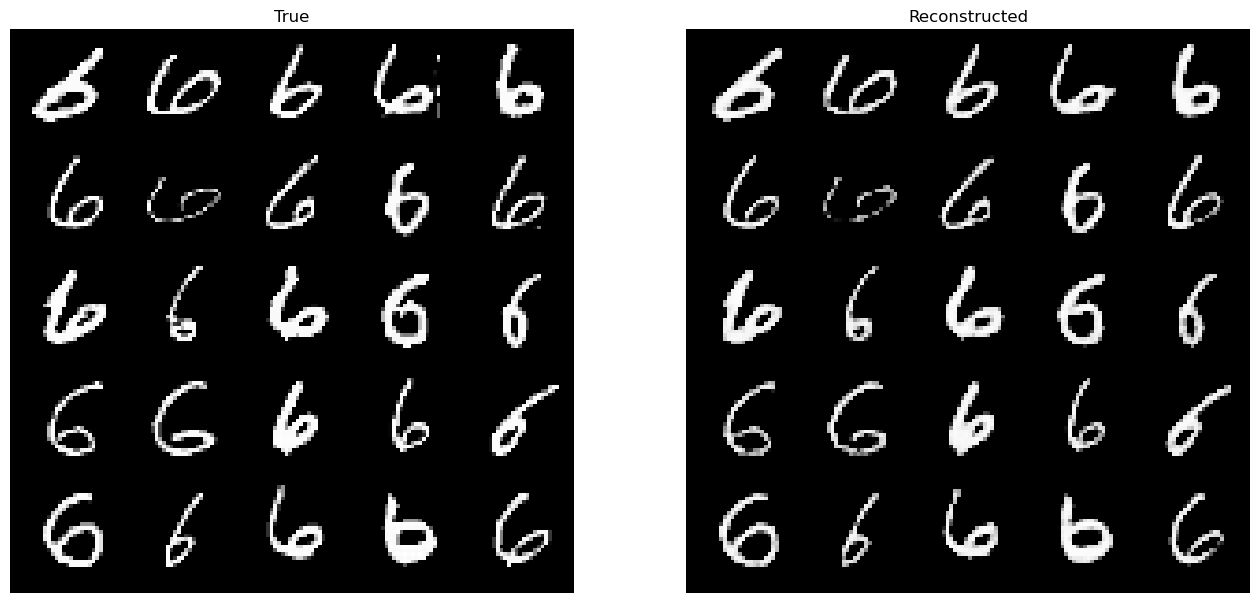

Epoch 7


100%|██████████| 132/132 [00:00<00:00, 176.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


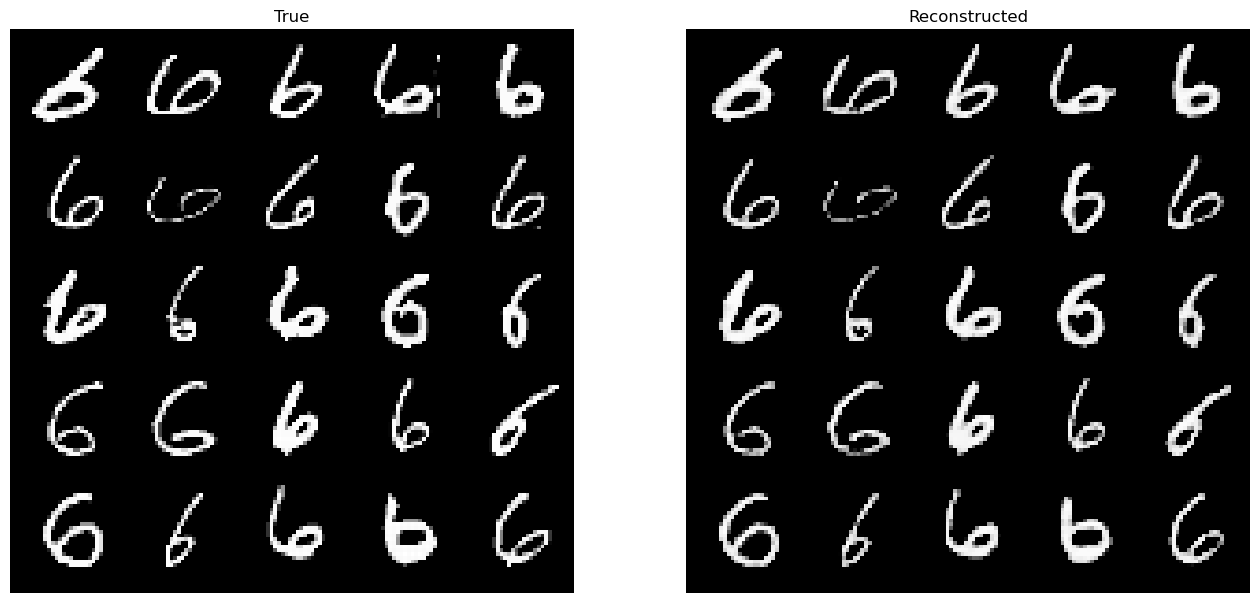

Epoch 8


100%|██████████| 132/132 [00:00<00:00, 176.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


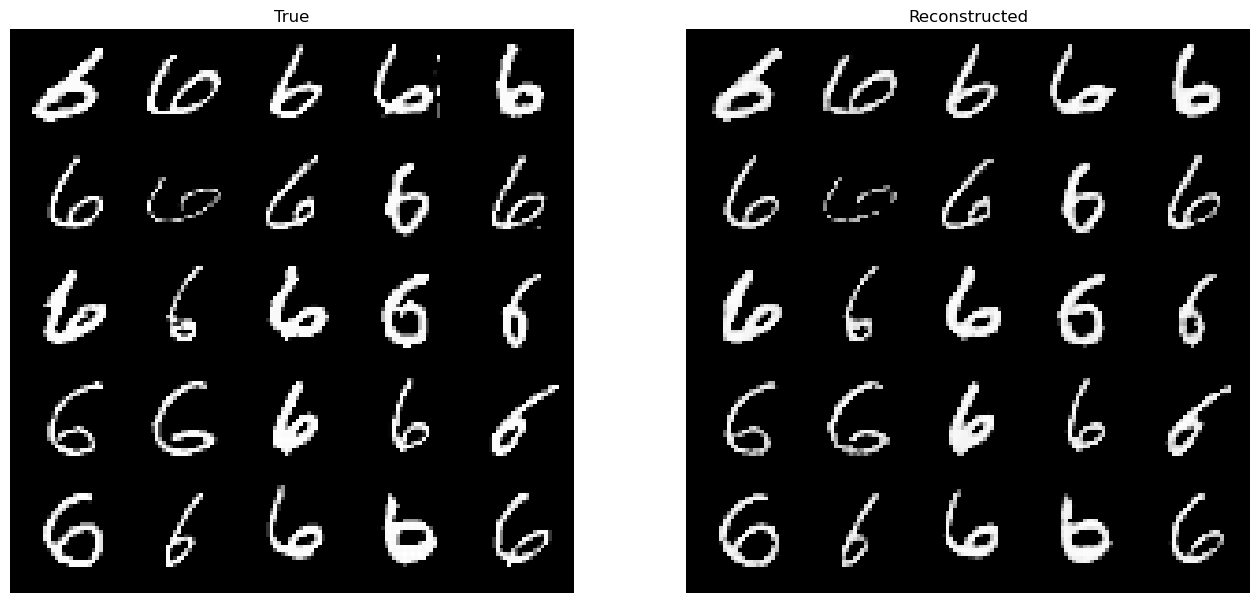

Epoch 9


100%|██████████| 132/132 [00:00<00:00, 176.53it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


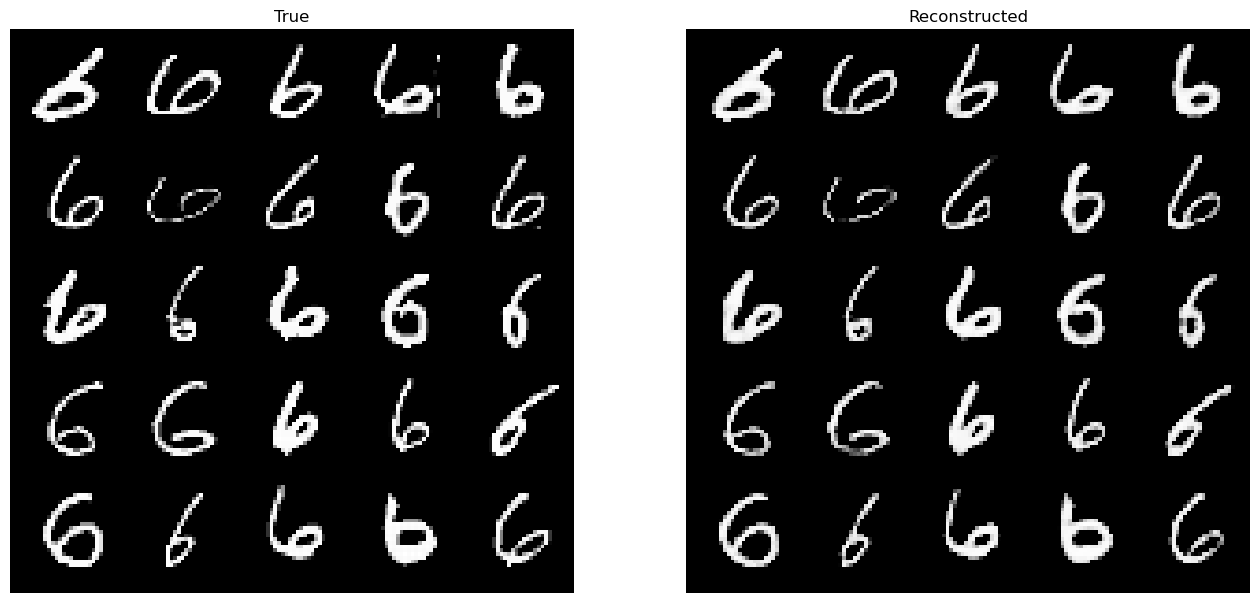

Epoch 0


100%|██████████| 132/132 [00:00<00:00, 171.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


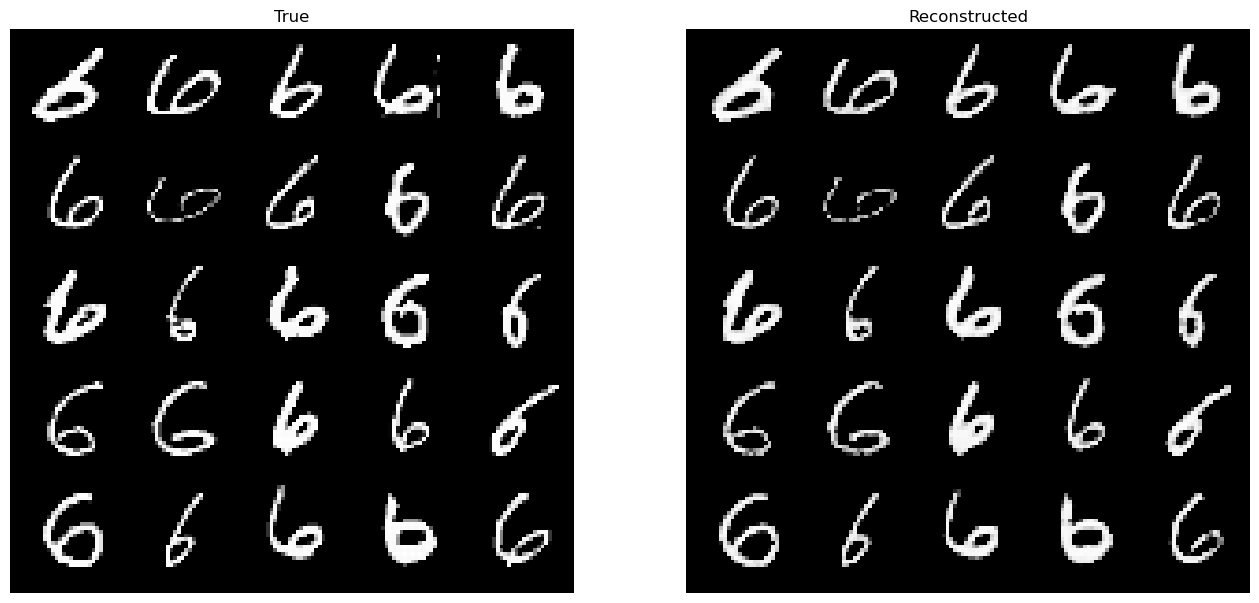

Epoch 1


100%|██████████| 132/132 [00:00<00:00, 171.59it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


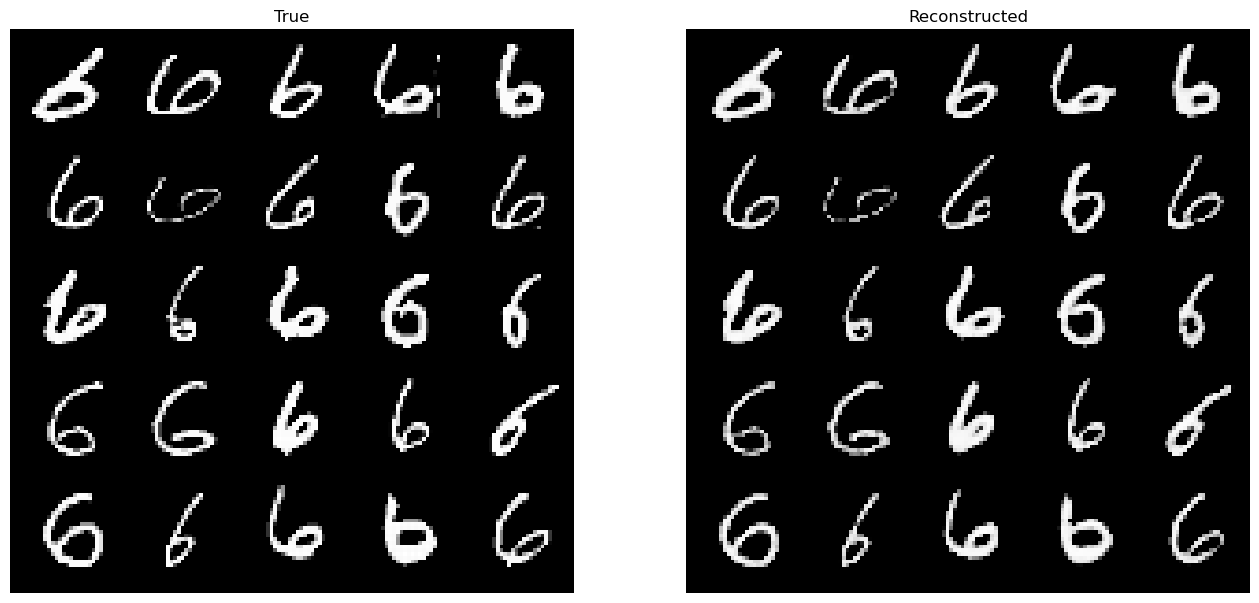

Epoch 2


100%|██████████| 132/132 [00:00<00:00, 156.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


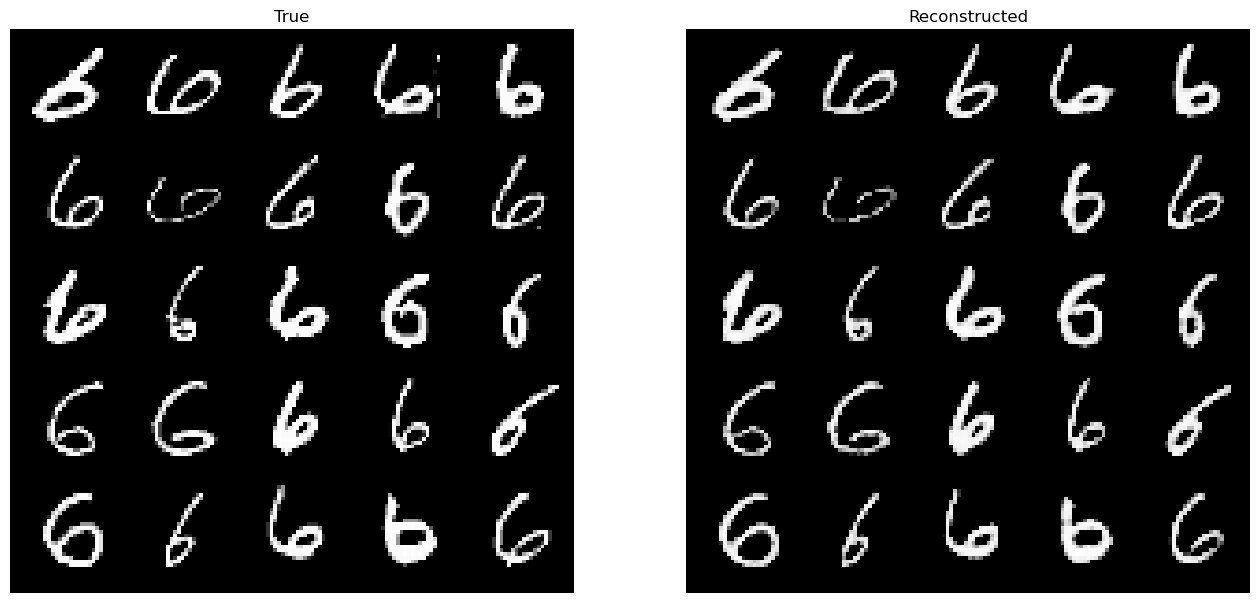

Epoch 3


100%|██████████| 132/132 [00:00<00:00, 155.84it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


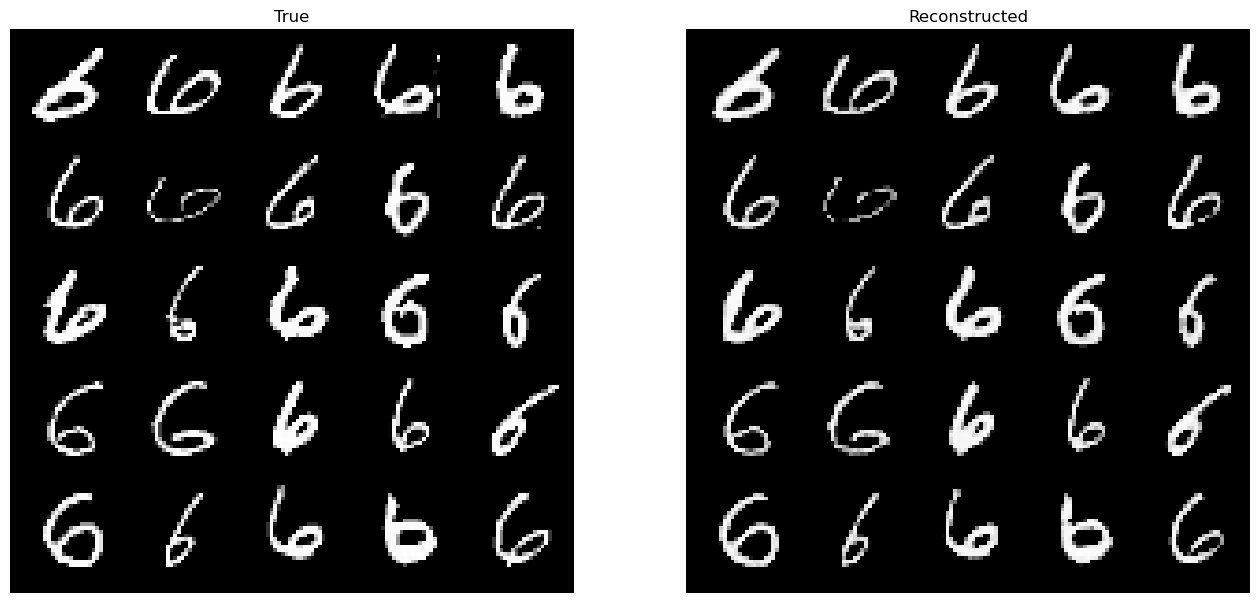

Epoch 4


100%|██████████| 132/132 [00:00<00:00, 169.84it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


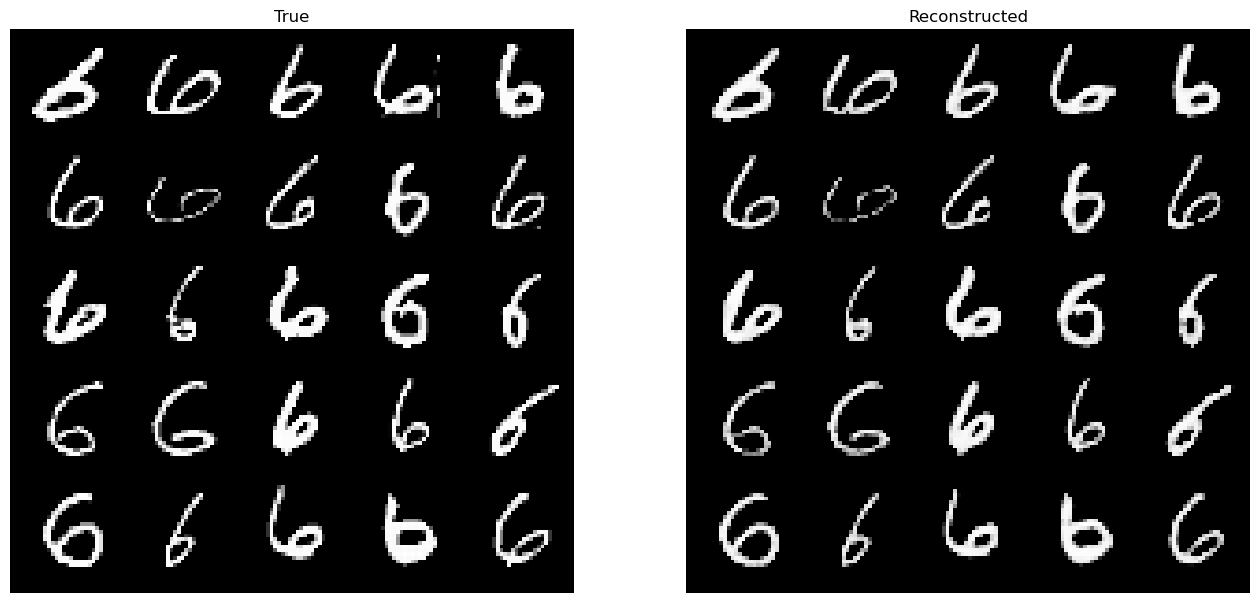

Epoch 5


100%|██████████| 132/132 [00:00<00:00, 174.84it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


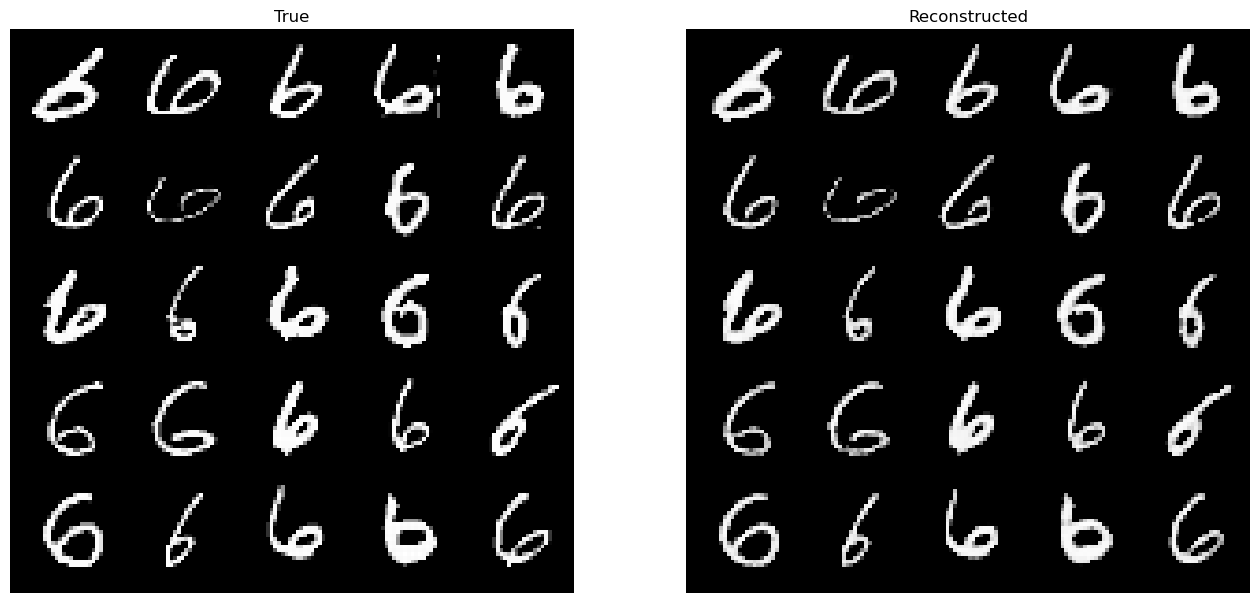

Epoch 6


100%|██████████| 132/132 [00:00<00:00, 175.15it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


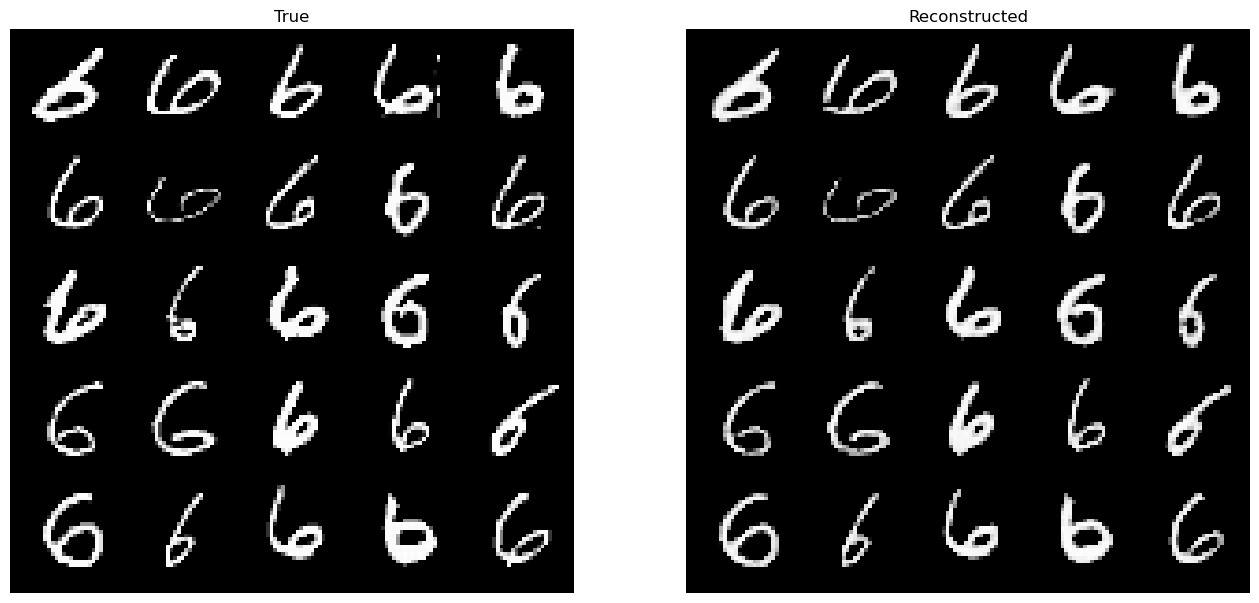

Epoch 7


100%|██████████| 132/132 [00:00<00:00, 172.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


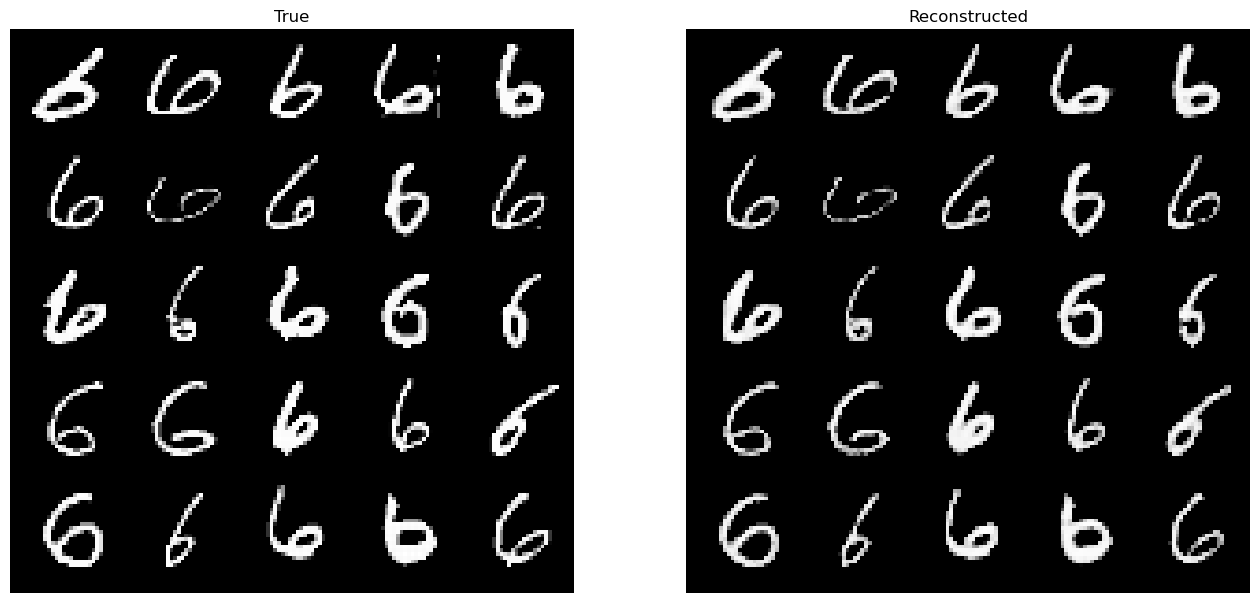

Epoch 8


100%|██████████| 132/132 [00:00<00:00, 174.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


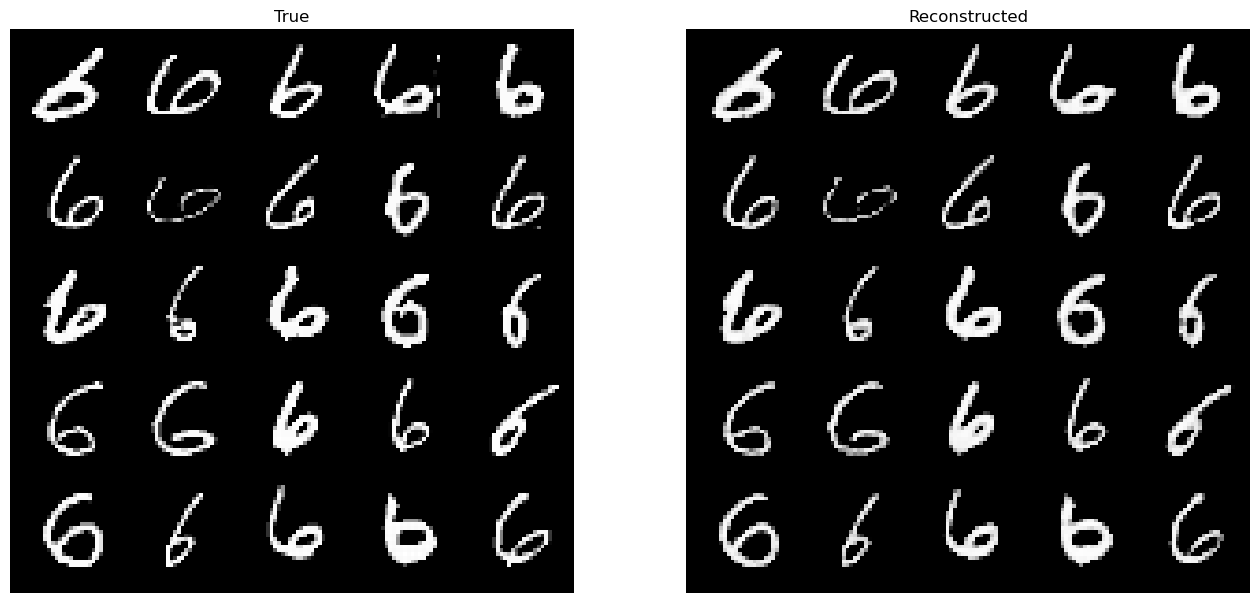

Epoch 9


100%|██████████| 132/132 [00:00<00:00, 175.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


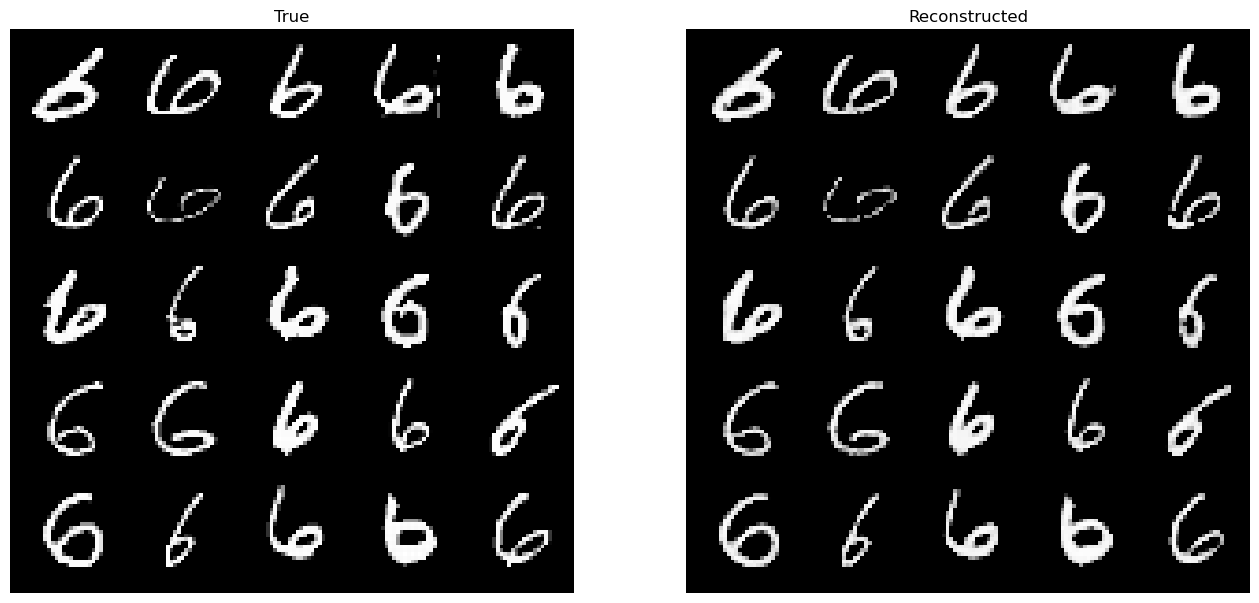

Epoch 0


100%|██████████| 132/132 [00:00<00:00, 174.82it/s]


Epoch 1


100%|██████████| 132/132 [00:00<00:00, 165.42it/s]


Epoch 2


100%|██████████| 132/132 [00:00<00:00, 156.78it/s]


Epoch 3


100%|██████████| 132/132 [00:00<00:00, 173.44it/s]


Epoch 4


100%|██████████| 132/132 [00:00<00:00, 174.21it/s]


Epoch 5


100%|██████████| 132/132 [00:00<00:00, 173.14it/s]


Epoch 6


100%|██████████| 132/132 [00:00<00:00, 167.04it/s]


Epoch 7


100%|██████████| 132/132 [00:00<00:00, 170.48it/s]


Epoch 8


100%|██████████| 132/132 [00:00<00:00, 153.63it/s]


Epoch 9


100%|██████████| 132/132 [00:00<00:00, 168.64it/s]


Epoch 0


100%|██████████| 132/132 [00:00<00:00, 174.88it/s]


Epoch 1


100%|██████████| 132/132 [00:00<00:00, 173.94it/s]


Epoch 2


100%|██████████| 132/132 [00:00<00:00, 171.79it/s]


Epoch 3


100%|██████████| 132/132 [00:00<00:00, 154.17it/s]


Epoch 4


100%|██████████| 132/132 [00:00<00:00, 174.80it/s]


Epoch 5


100%|██████████| 132/132 [00:00<00:00, 174.00it/s]


Epoch 6


100%|██████████| 132/132 [00:00<00:00, 175.16it/s]


Epoch 7


100%|██████████| 132/132 [00:00<00:00, 175.01it/s]


Epoch 8


100%|██████████| 132/132 [00:00<00:00, 175.42it/s]


Epoch 9


100%|██████████| 132/132 [00:00<00:00, 168.09it/s]


Epoch 0


100%|██████████| 132/132 [00:00<00:00, 174.10it/s]


Epoch 1


100%|██████████| 132/132 [00:00<00:00, 171.42it/s]


Epoch 2


100%|██████████| 132/132 [00:00<00:00, 173.25it/s]


Epoch 3


100%|██████████| 132/132 [00:00<00:00, 175.02it/s]


Epoch 4


100%|██████████| 132/132 [00:00<00:00, 159.01it/s]


Epoch 5


100%|██████████| 132/132 [00:00<00:00, 166.42it/s]


Epoch 6


100%|██████████| 132/132 [00:00<00:00, 174.70it/s]


Epoch 7


100%|██████████| 132/132 [00:00<00:00, 169.36it/s]


Epoch 8


100%|██████████| 132/132 [00:00<00:00, 172.63it/s]


Epoch 9


100%|██████████| 132/132 [00:00<00:00, 174.45it/s]


Epoch 0


100%|██████████| 147/147 [00:00<00:00, 174.48it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


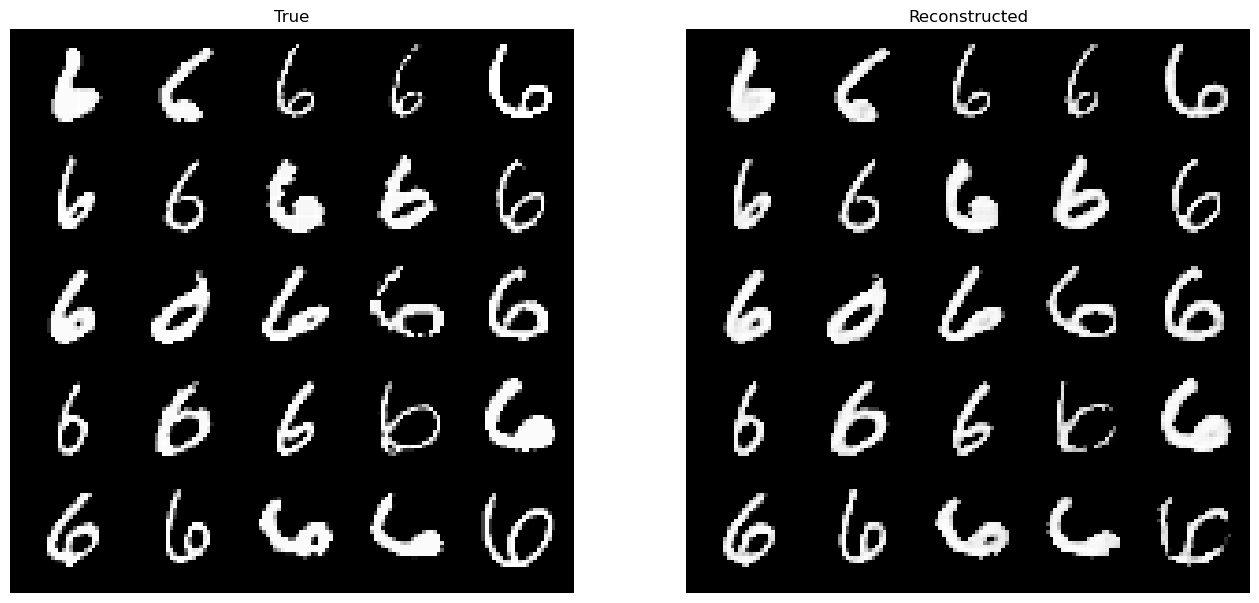

Epoch 1


100%|██████████| 147/147 [00:00<00:00, 169.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


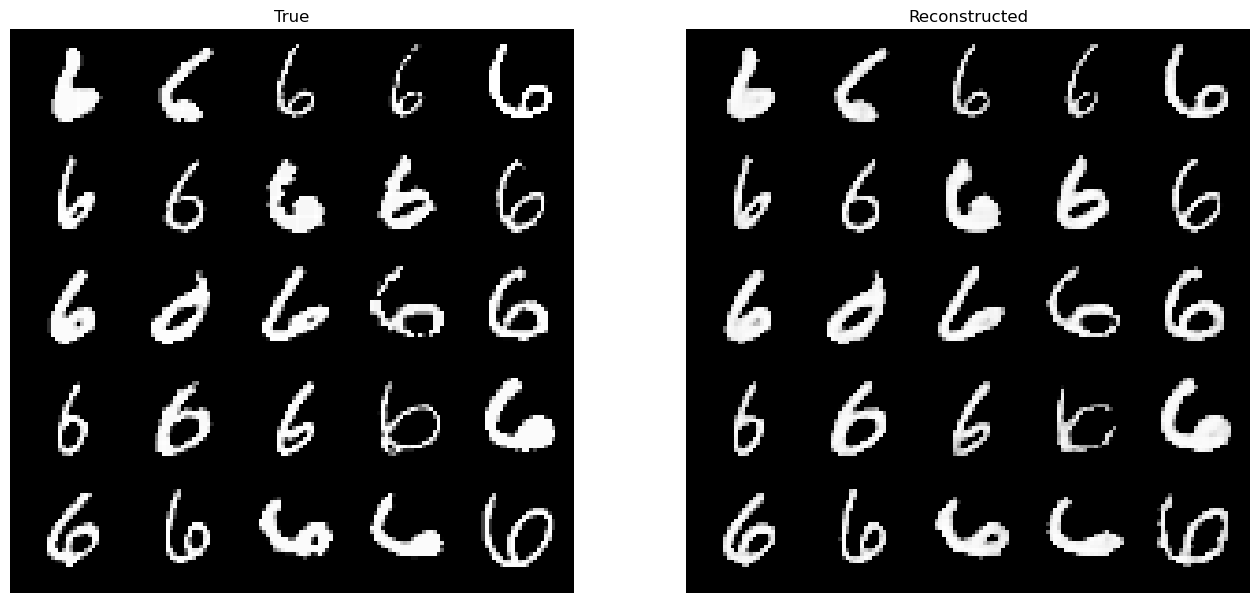

Epoch 2


100%|██████████| 147/147 [00:00<00:00, 169.80it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


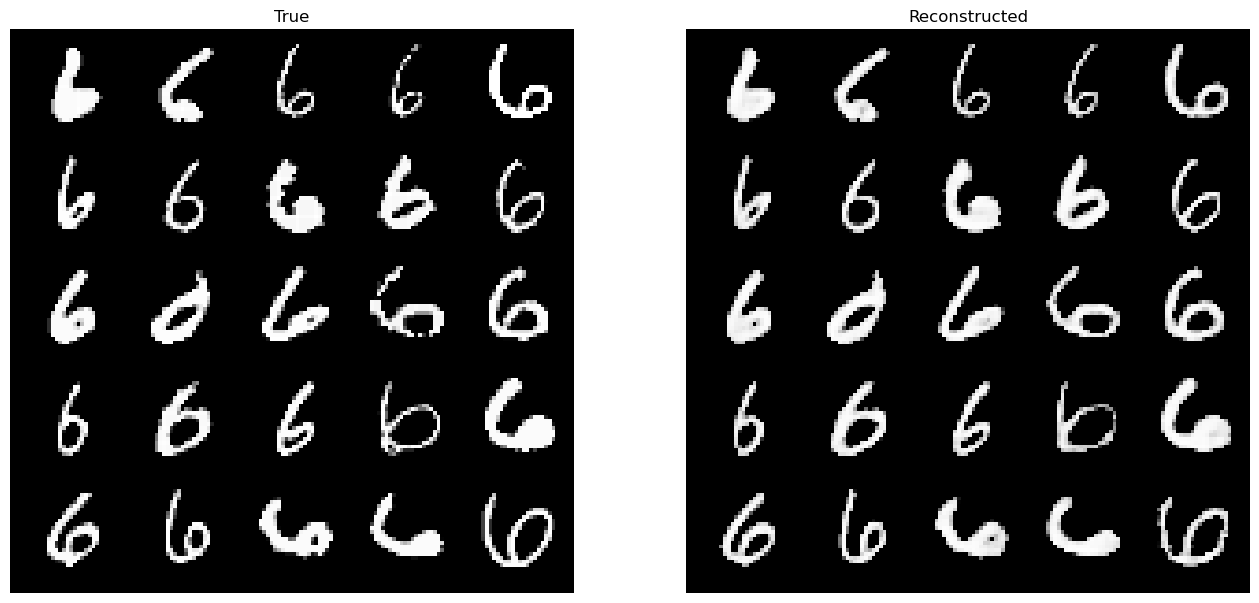

Epoch 3


100%|██████████| 147/147 [00:00<00:00, 154.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


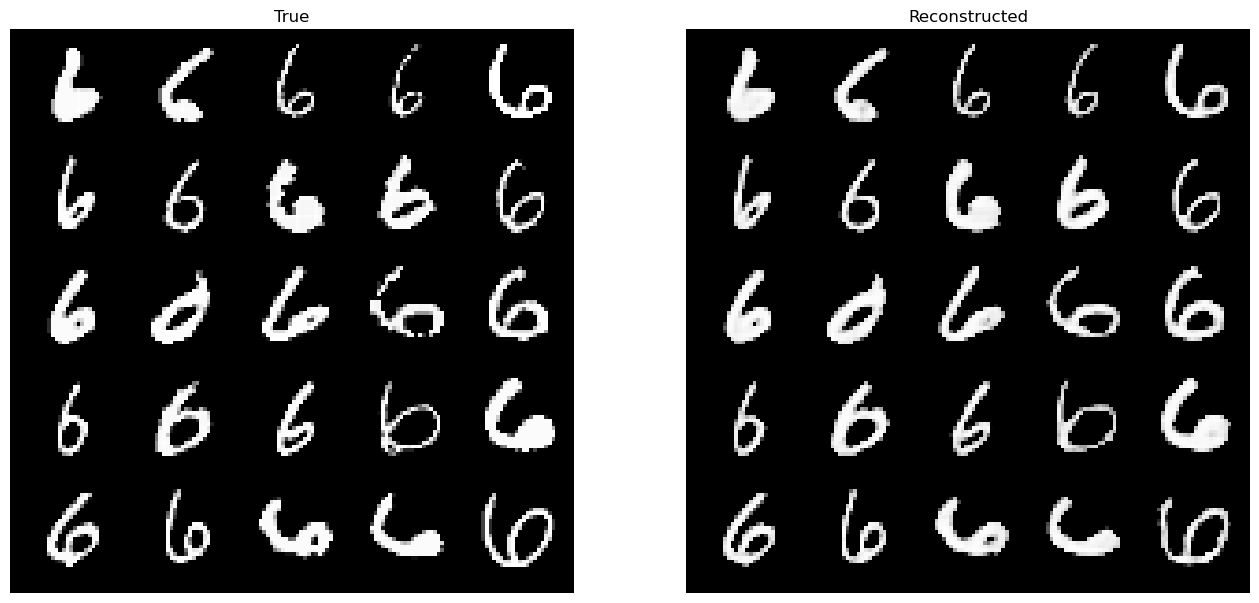

Epoch 4


100%|██████████| 147/147 [00:00<00:00, 157.32it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


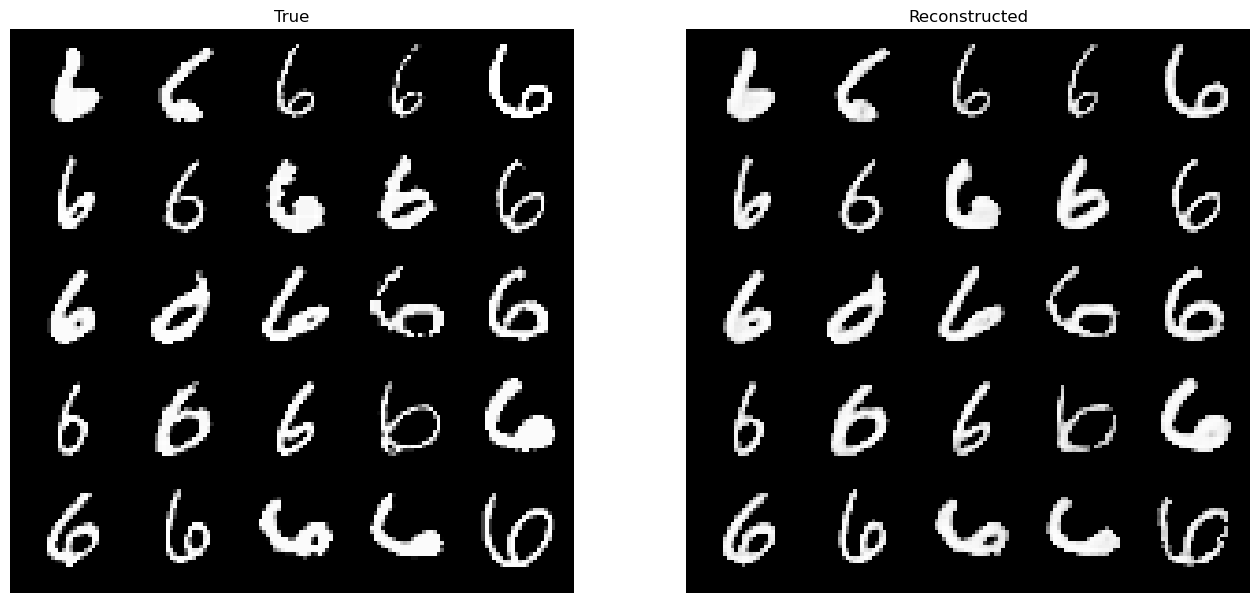

Epoch 5


100%|██████████| 147/147 [00:00<00:00, 174.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


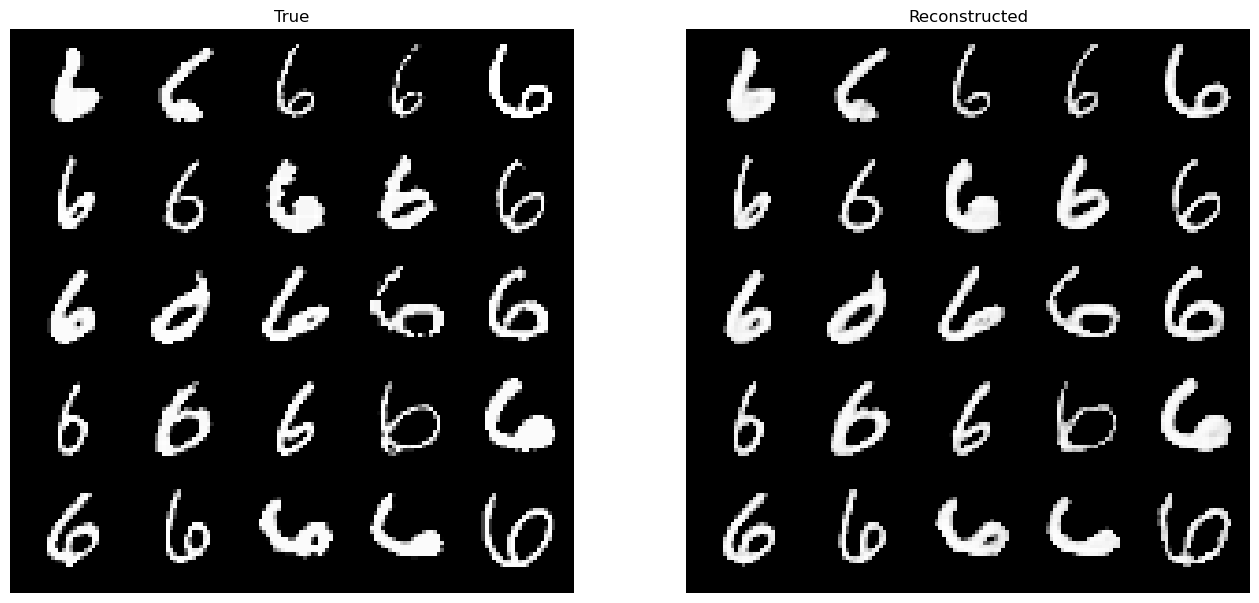

Epoch 6


100%|██████████| 147/147 [00:00<00:00, 173.89it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


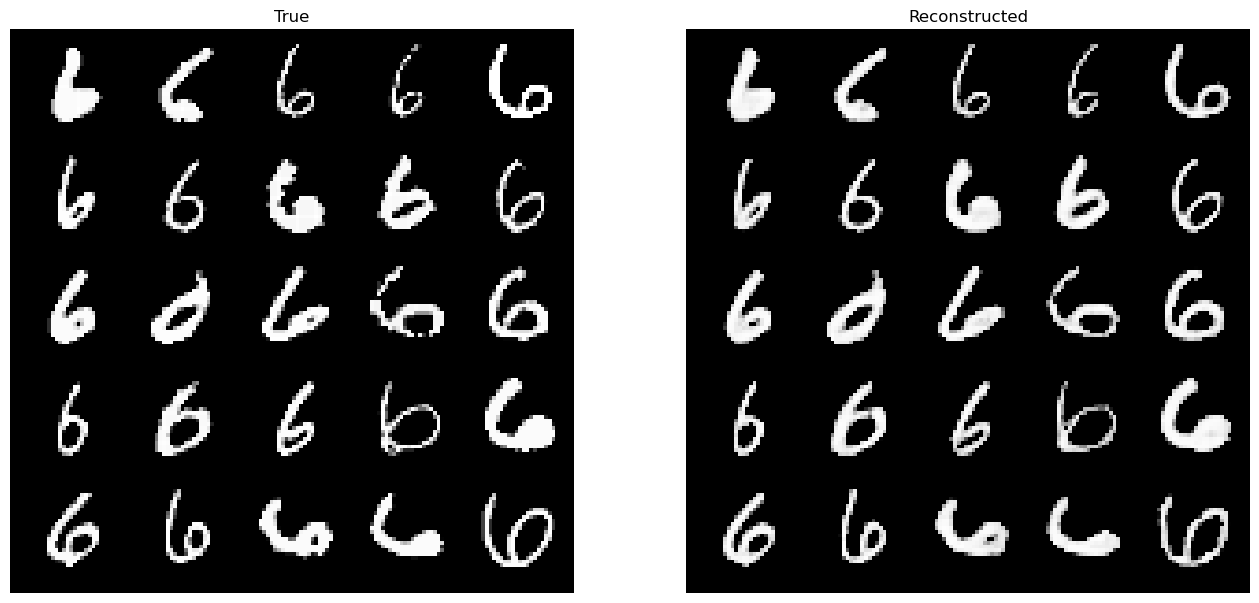

Epoch 7


100%|██████████| 147/147 [00:00<00:00, 174.08it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


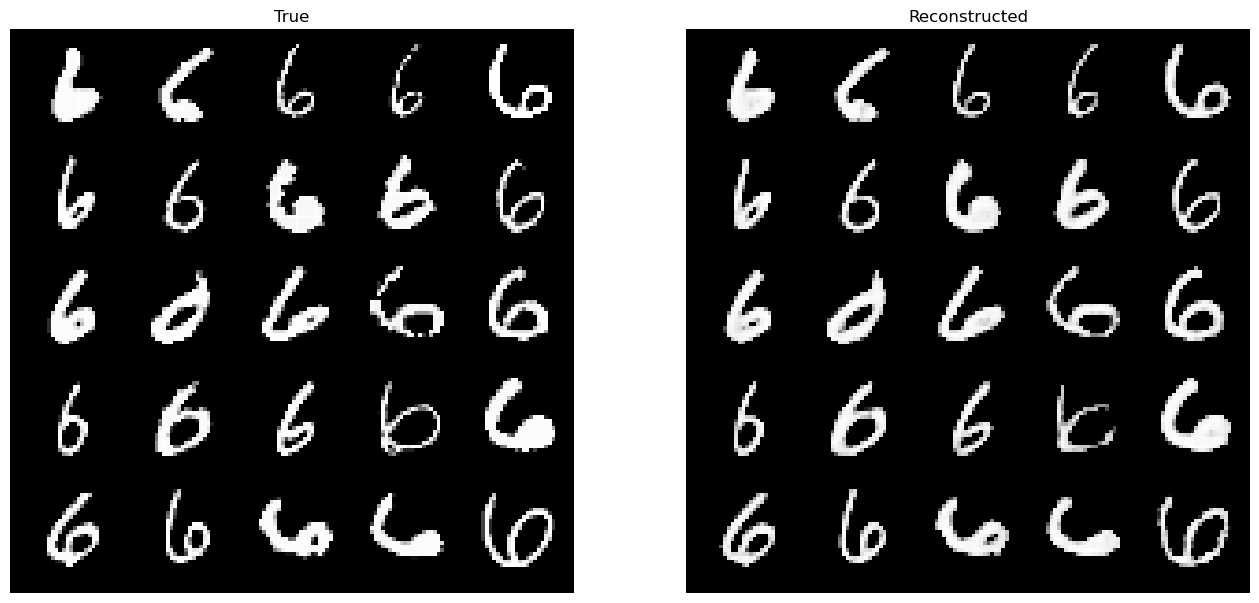

Epoch 8


100%|██████████| 147/147 [00:00<00:00, 174.25it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


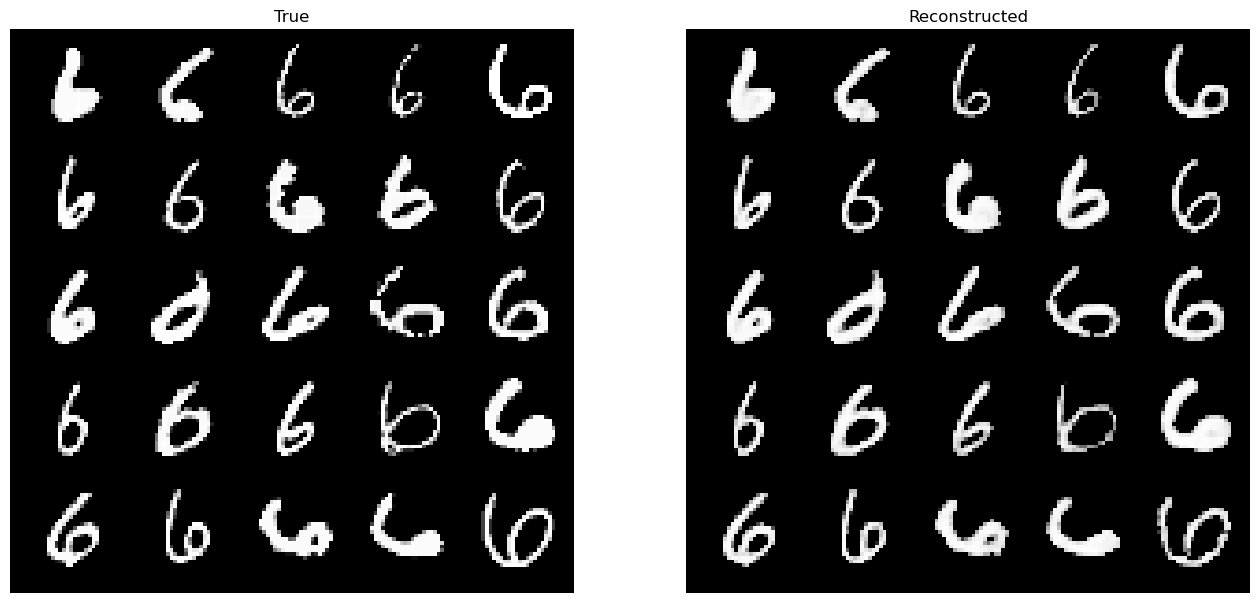

Epoch 9


100%|██████████| 147/147 [00:00<00:00, 172.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


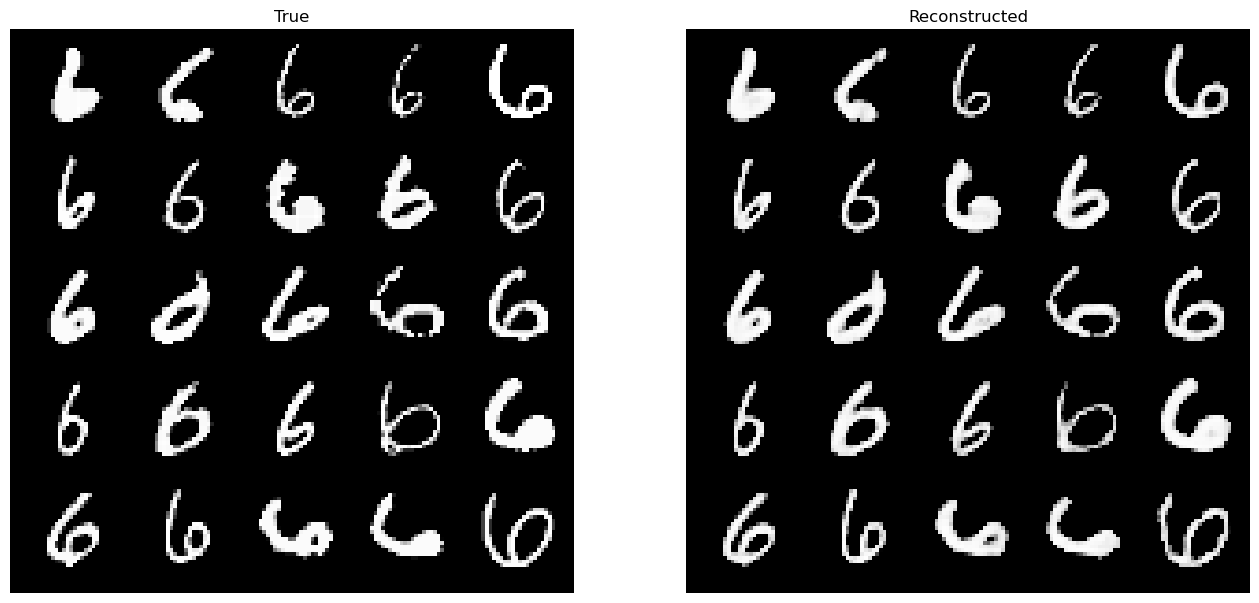

Epoch 0


100%|██████████| 147/147 [00:00<00:00, 173.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


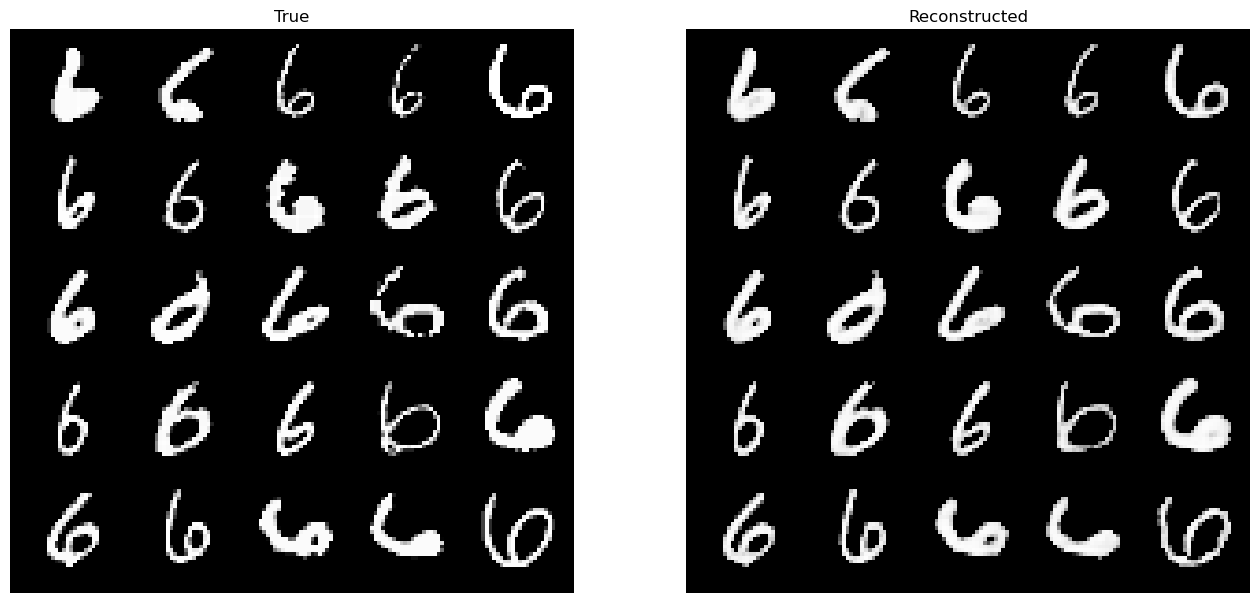

Epoch 1


100%|██████████| 147/147 [00:00<00:00, 173.74it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


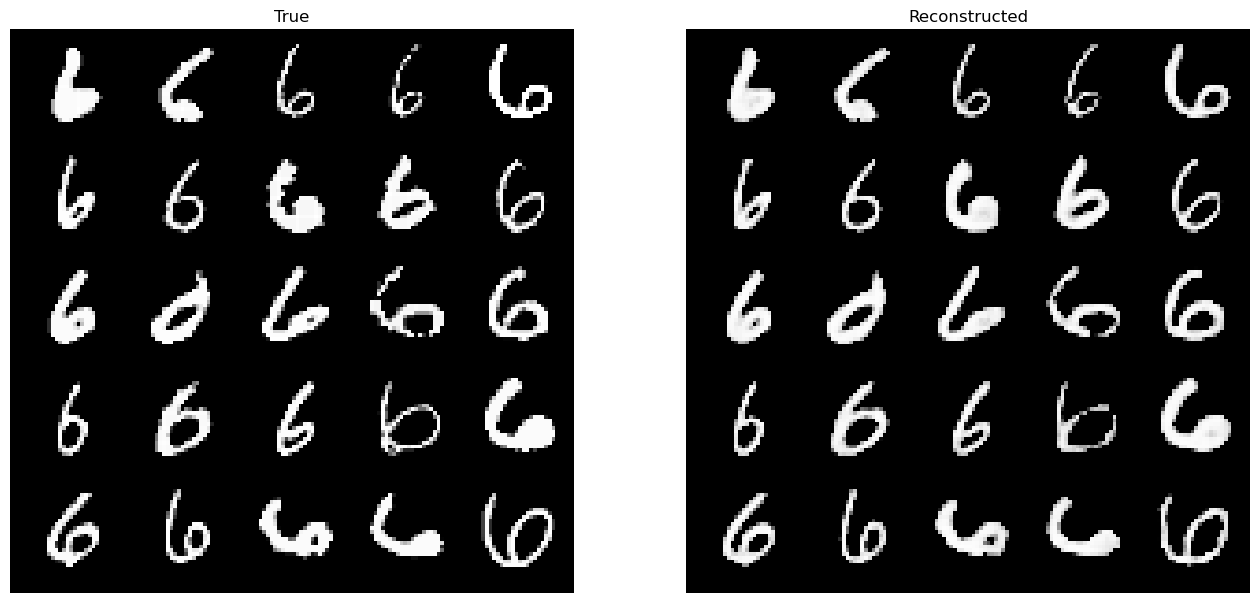

Epoch 2


100%|██████████| 147/147 [00:00<00:00, 173.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


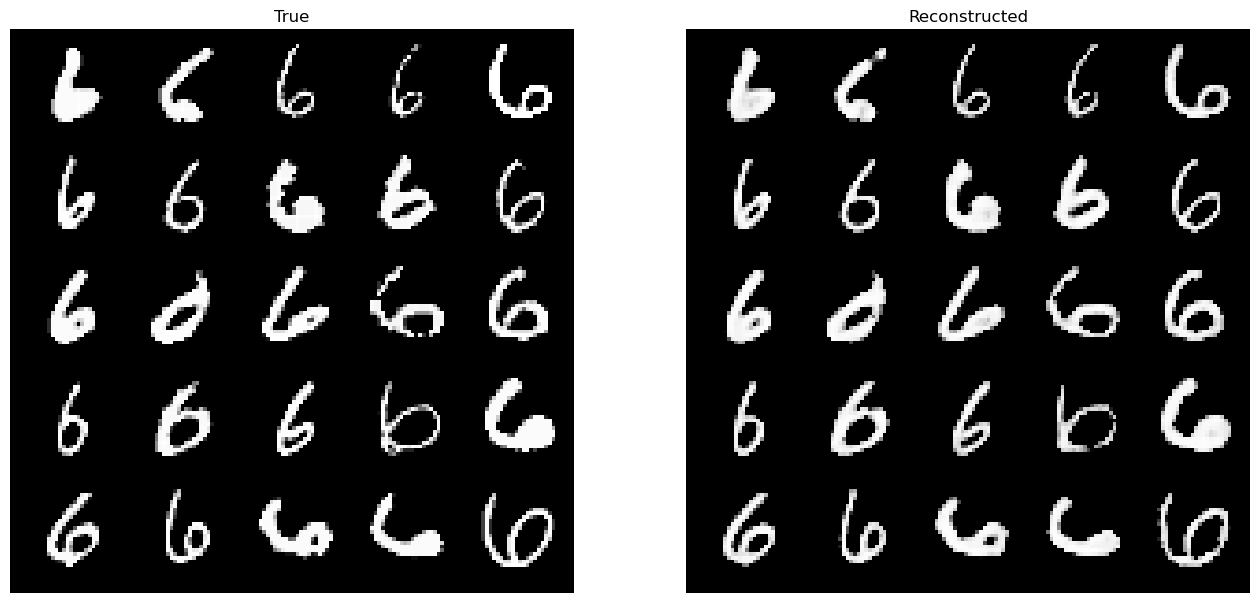

Epoch 3


100%|██████████| 147/147 [00:00<00:00, 175.87it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


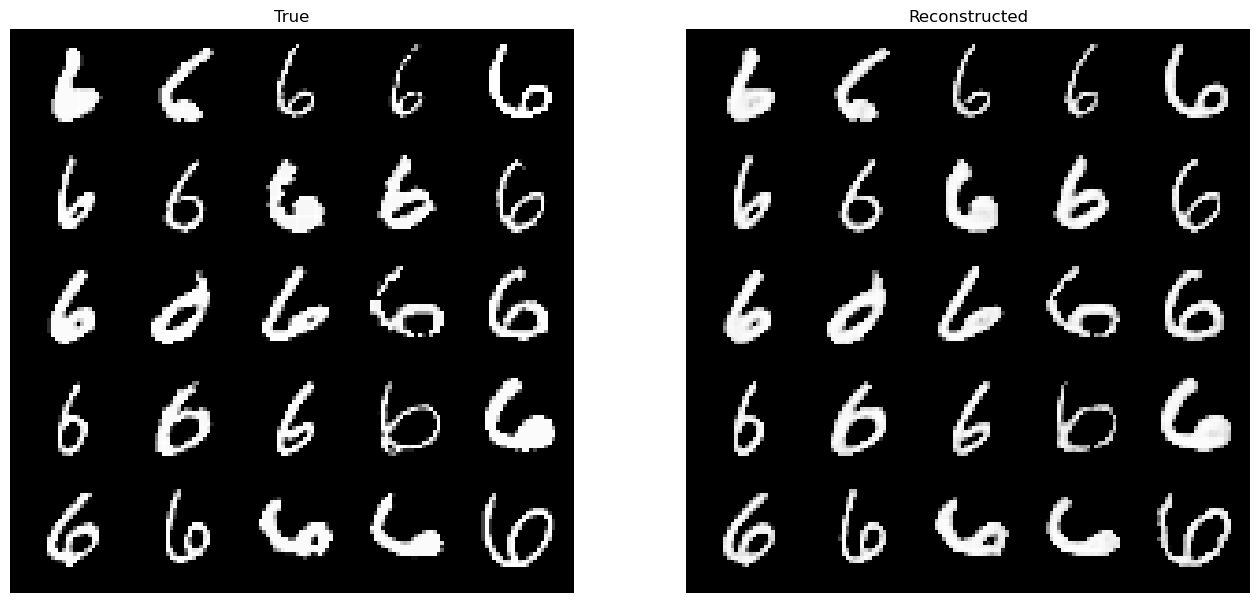

Epoch 4


100%|██████████| 147/147 [00:00<00:00, 176.71it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


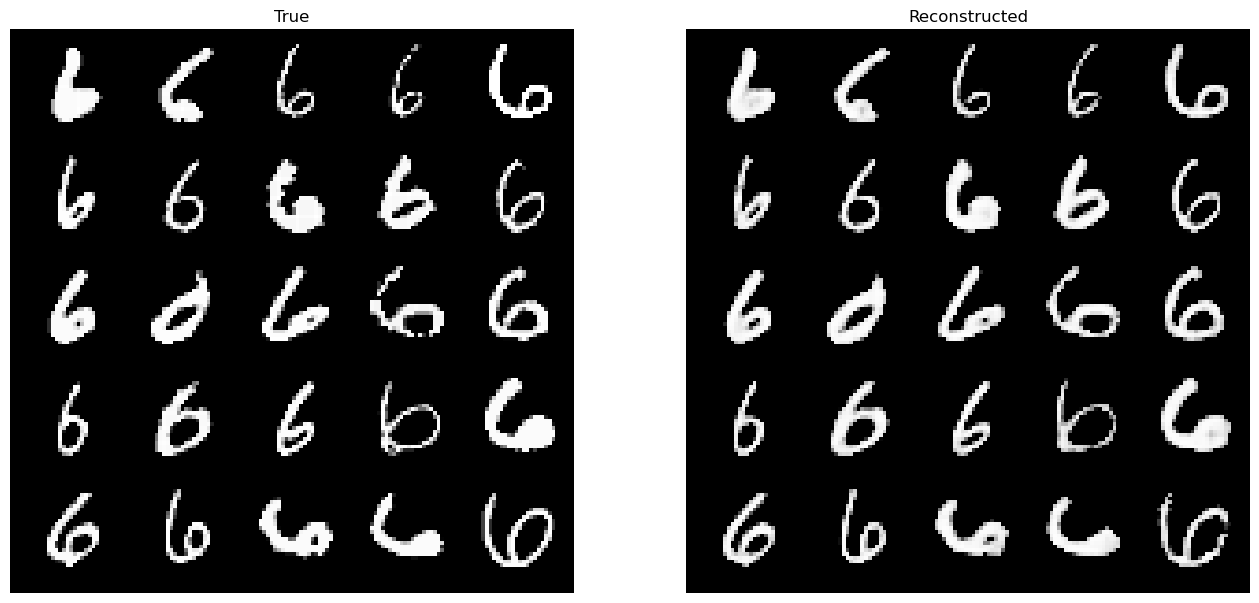

Epoch 5


100%|██████████| 147/147 [00:00<00:00, 167.28it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


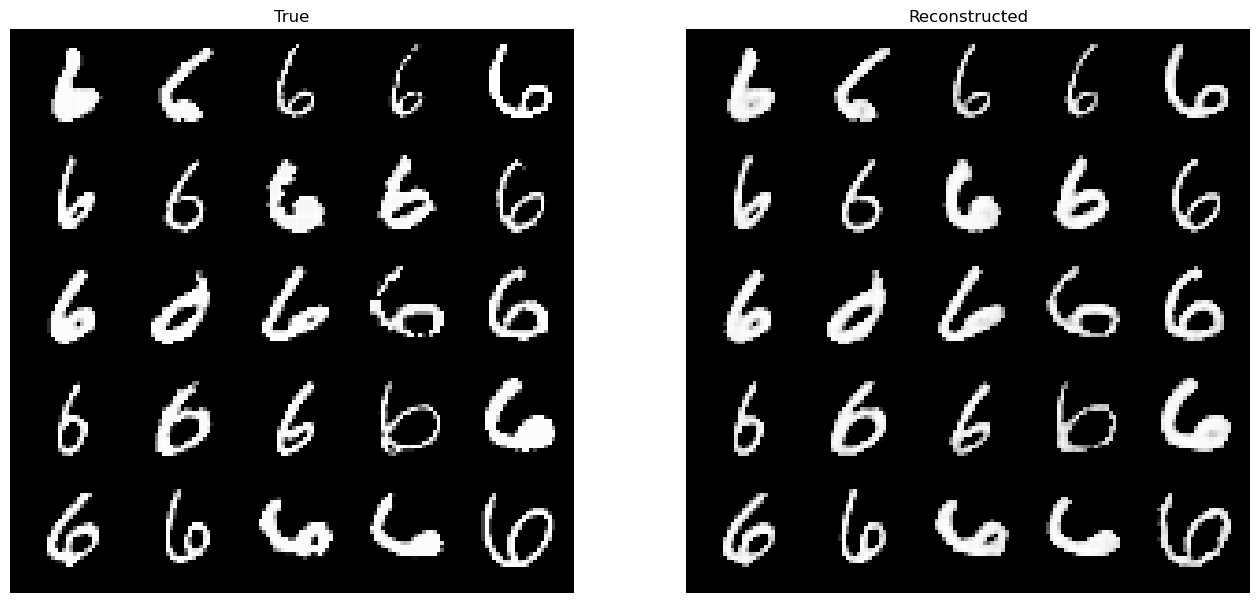

Epoch 6


100%|██████████| 147/147 [00:00<00:00, 175.79it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


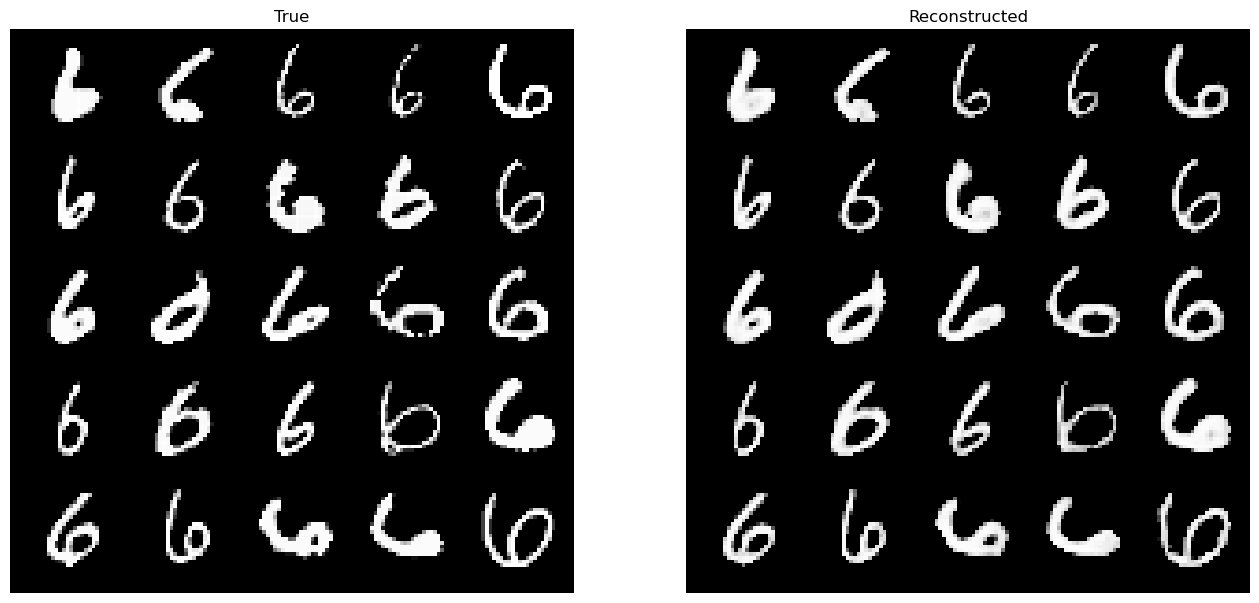

Epoch 7


100%|██████████| 147/147 [00:00<00:00, 176.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


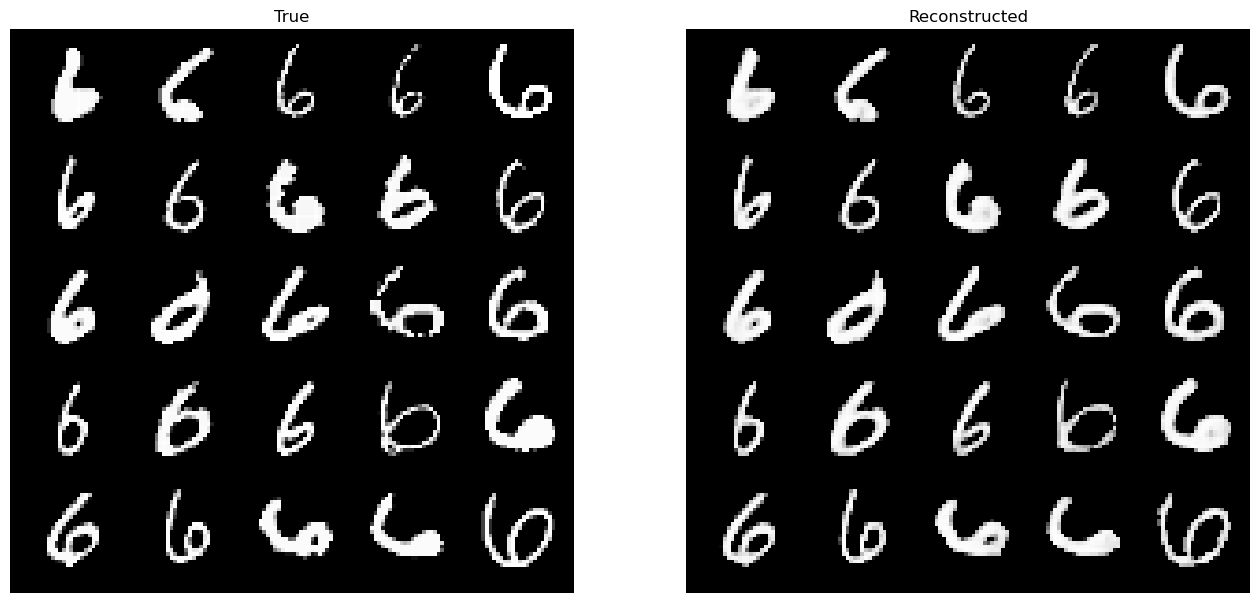

Epoch 8


100%|██████████| 147/147 [00:00<00:00, 175.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


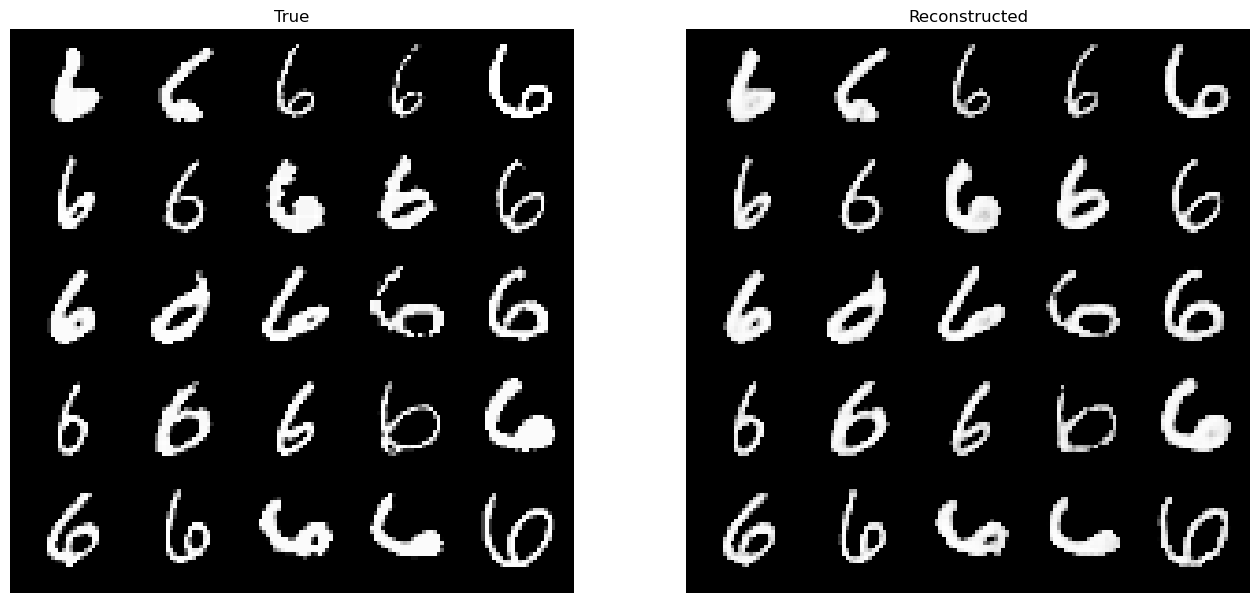

Epoch 9


100%|██████████| 147/147 [00:00<00:00, 174.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


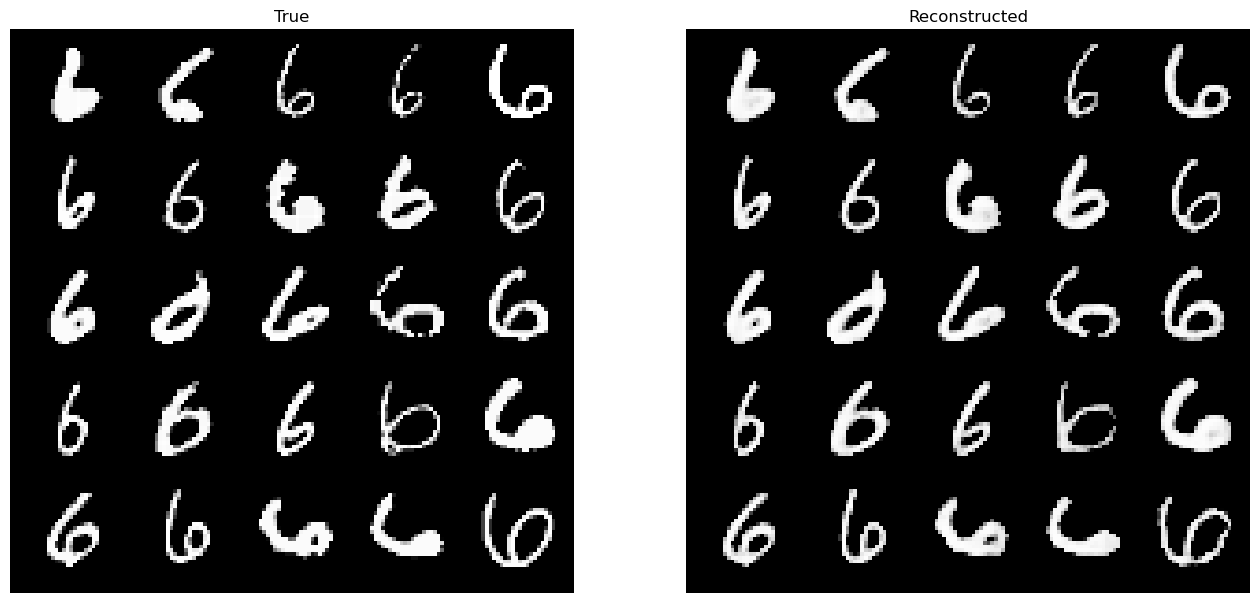

Epoch 0


100%|██████████| 147/147 [00:00<00:00, 162.00it/s]


Epoch 1


100%|██████████| 147/147 [00:00<00:00, 174.97it/s]


Epoch 2


100%|██████████| 147/147 [00:00<00:00, 174.41it/s]


Epoch 3


100%|██████████| 147/147 [00:00<00:00, 153.45it/s]


Epoch 4


100%|██████████| 147/147 [00:00<00:00, 174.39it/s]


Epoch 5


100%|██████████| 147/147 [00:00<00:00, 167.32it/s]


Epoch 6


100%|██████████| 147/147 [00:00<00:00, 172.39it/s]


Epoch 7


100%|██████████| 147/147 [00:00<00:00, 169.13it/s]


Epoch 8


100%|██████████| 147/147 [00:00<00:00, 168.49it/s]


Epoch 9


100%|██████████| 147/147 [00:00<00:00, 175.22it/s]


Epoch 0


100%|██████████| 147/147 [00:00<00:00, 175.17it/s]


Epoch 1


100%|██████████| 147/147 [00:00<00:00, 158.12it/s]


Epoch 2


100%|██████████| 147/147 [00:00<00:00, 149.41it/s]


Epoch 3


100%|██████████| 147/147 [00:00<00:00, 171.81it/s]


Epoch 4


100%|██████████| 147/147 [00:00<00:00, 174.51it/s]


Epoch 5


100%|██████████| 147/147 [00:00<00:00, 173.16it/s]


Epoch 6


100%|██████████| 147/147 [00:00<00:00, 174.79it/s]


Epoch 7


100%|██████████| 147/147 [00:00<00:00, 174.75it/s]


Epoch 8


100%|██████████| 147/147 [00:00<00:00, 174.38it/s]


Epoch 9


100%|██████████| 147/147 [00:00<00:00, 173.53it/s]


Epoch 0


100%|██████████| 147/147 [00:00<00:00, 174.83it/s]


Epoch 1


100%|██████████| 147/147 [00:00<00:00, 175.31it/s]


Epoch 2


100%|██████████| 147/147 [00:00<00:00, 161.70it/s]


Epoch 3


100%|██████████| 147/147 [00:00<00:00, 173.36it/s]


Epoch 4


100%|██████████| 147/147 [00:00<00:00, 173.81it/s]


Epoch 5


100%|██████████| 147/147 [00:00<00:00, 174.93it/s]


Epoch 6


100%|██████████| 147/147 [00:00<00:00, 174.14it/s]


Epoch 7


100%|██████████| 147/147 [00:00<00:00, 174.94it/s]


Epoch 8


100%|██████████| 147/147 [00:00<00:00, 174.91it/s]


Epoch 9


100%|██████████| 147/147 [00:00<00:00, 174.19it/s]


Epoch 0


100%|██████████| 118/118 [00:00<00:00, 172.16it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


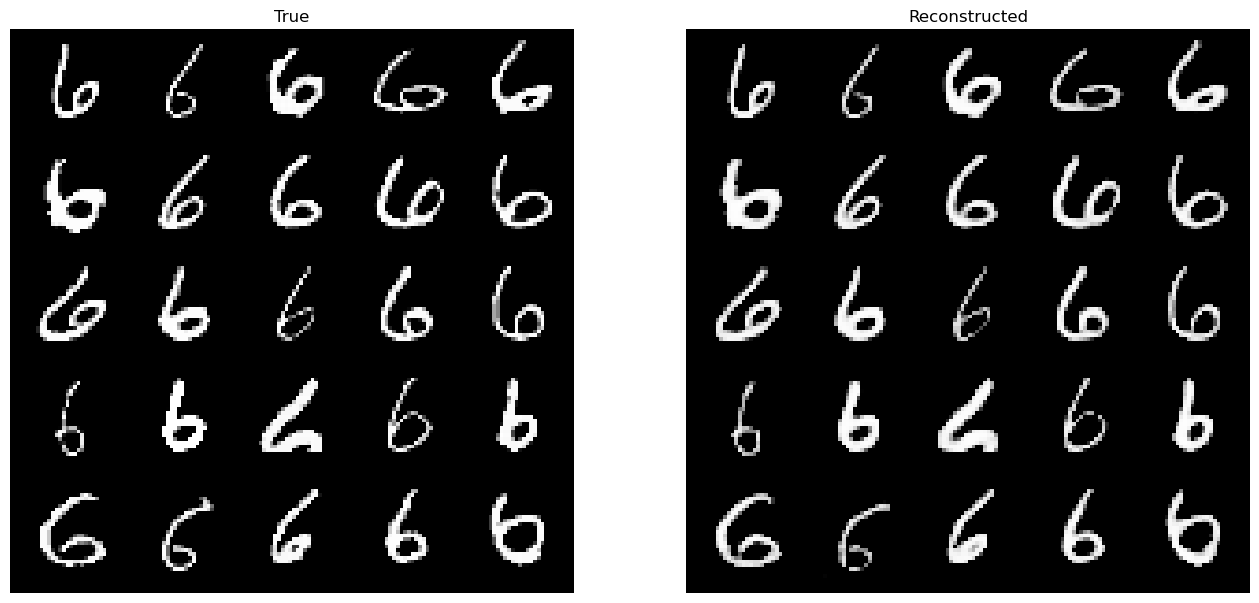

Epoch 1


100%|██████████| 118/118 [00:00<00:00, 172.64it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


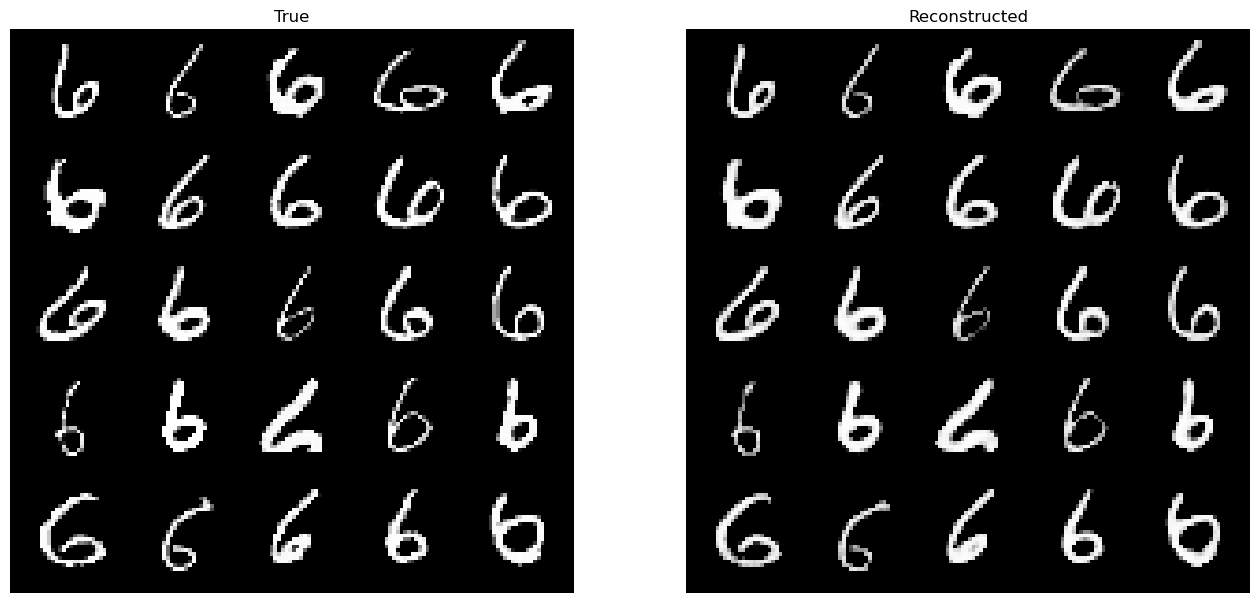

Epoch 2


100%|██████████| 118/118 [00:00<00:00, 173.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


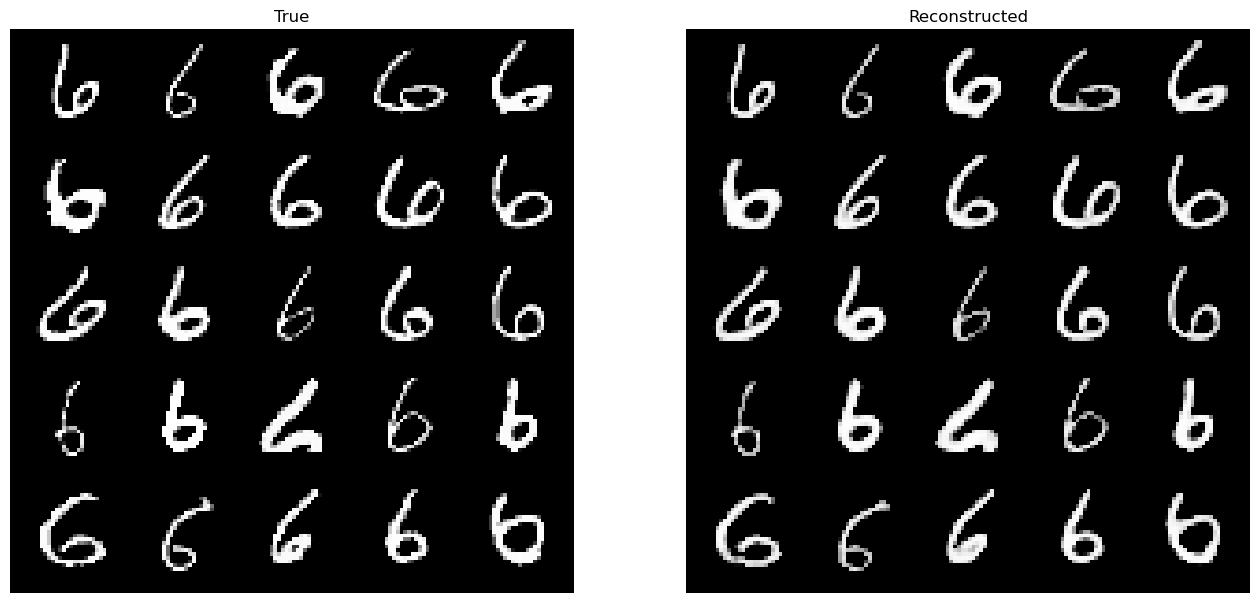

Epoch 3


100%|██████████| 118/118 [00:00<00:00, 158.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


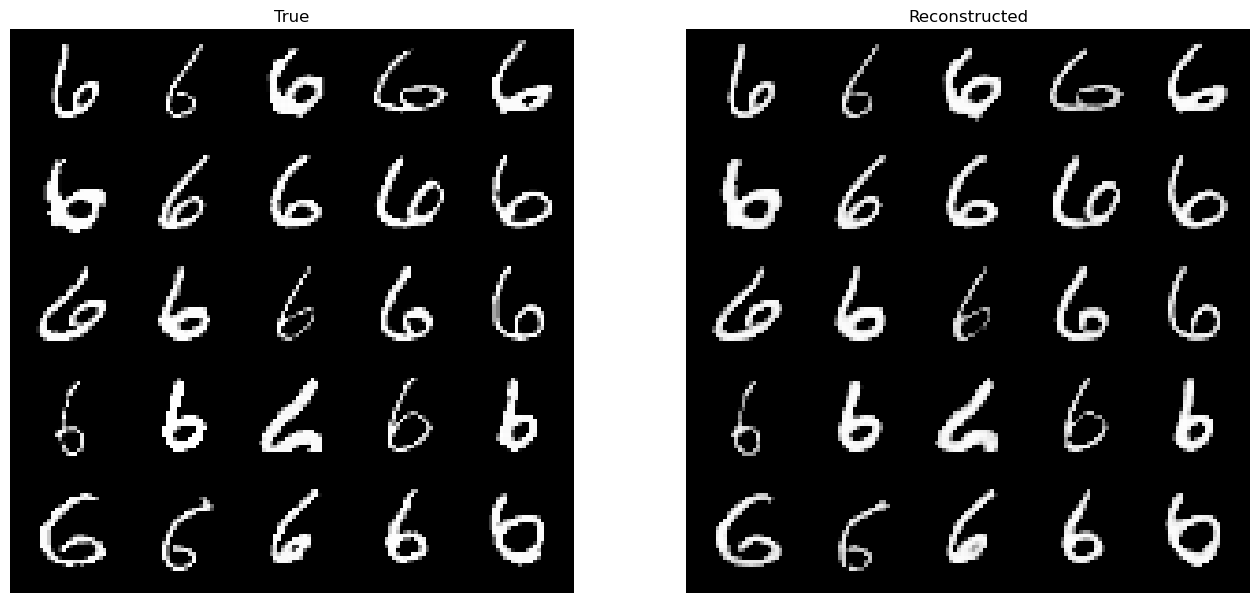

Epoch 4


100%|██████████| 118/118 [00:00<00:00, 157.64it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


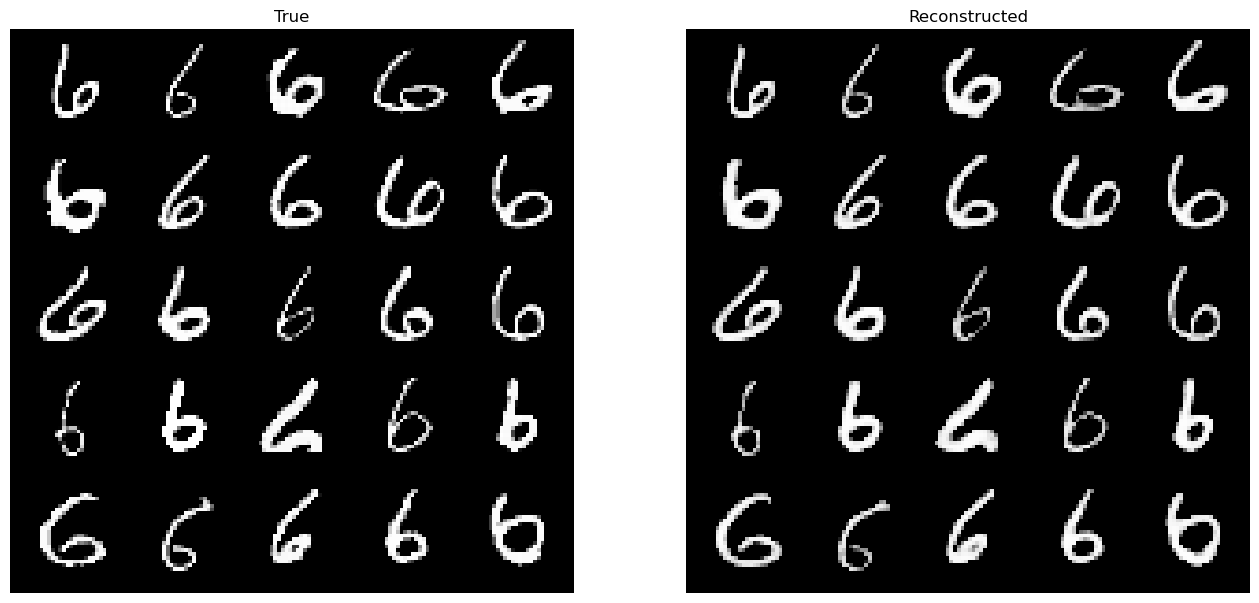

Epoch 5


100%|██████████| 118/118 [00:00<00:00, 168.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


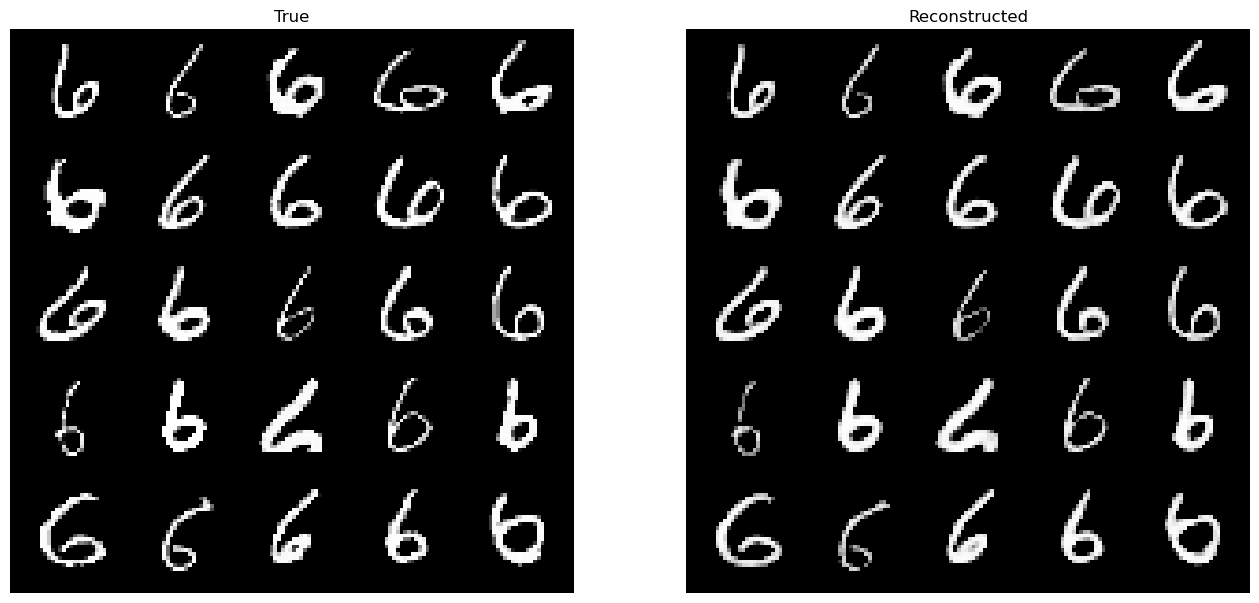

Epoch 6


100%|██████████| 118/118 [00:00<00:00, 173.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


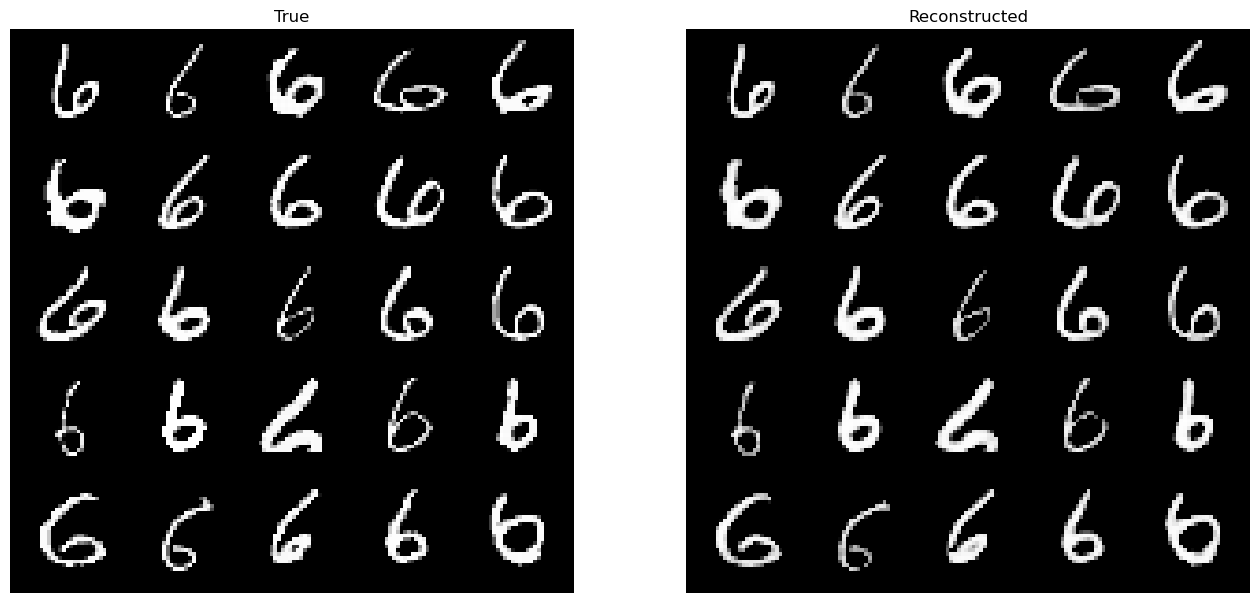

Epoch 7


100%|██████████| 118/118 [00:00<00:00, 172.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


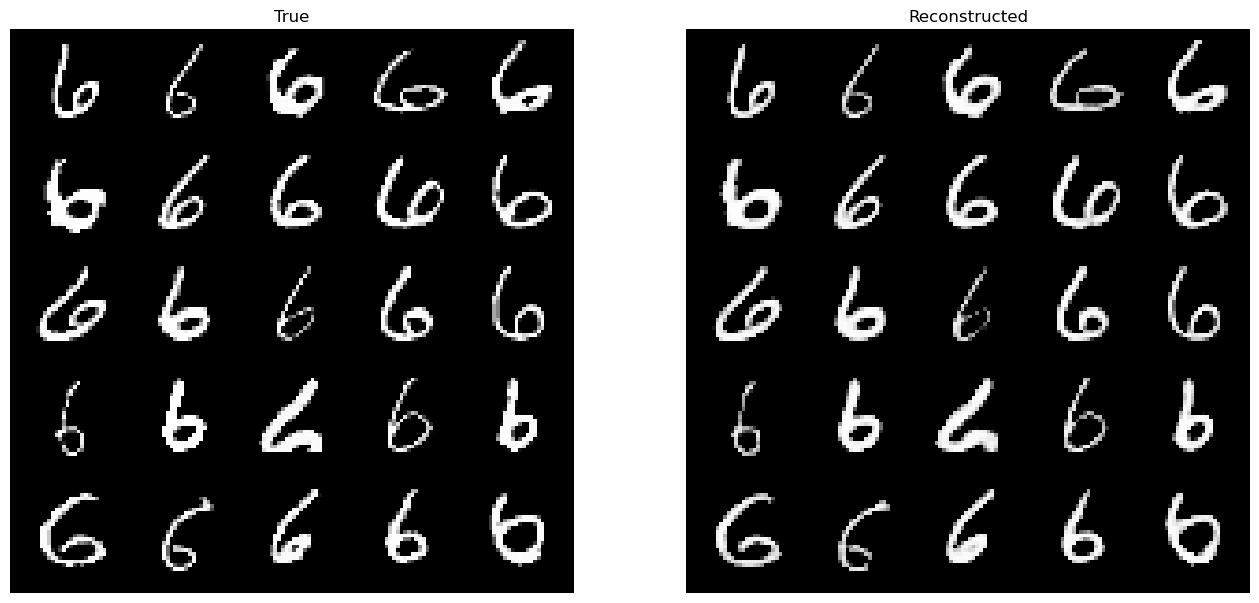

Epoch 8


100%|██████████| 118/118 [00:00<00:00, 174.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


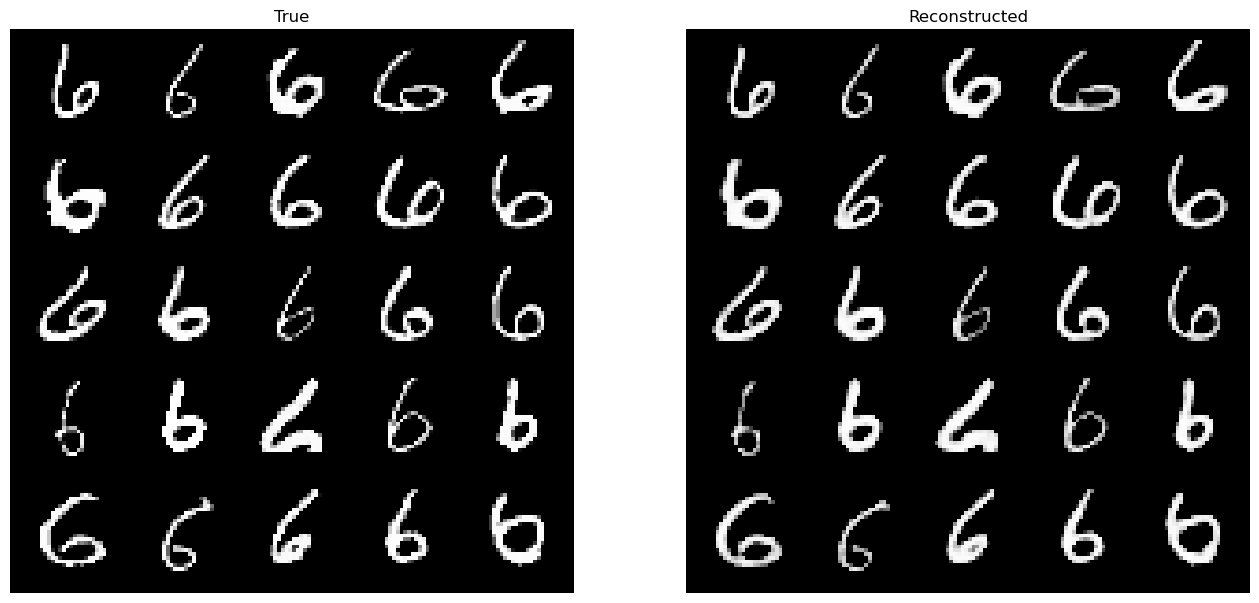

Epoch 9


100%|██████████| 118/118 [00:00<00:00, 174.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


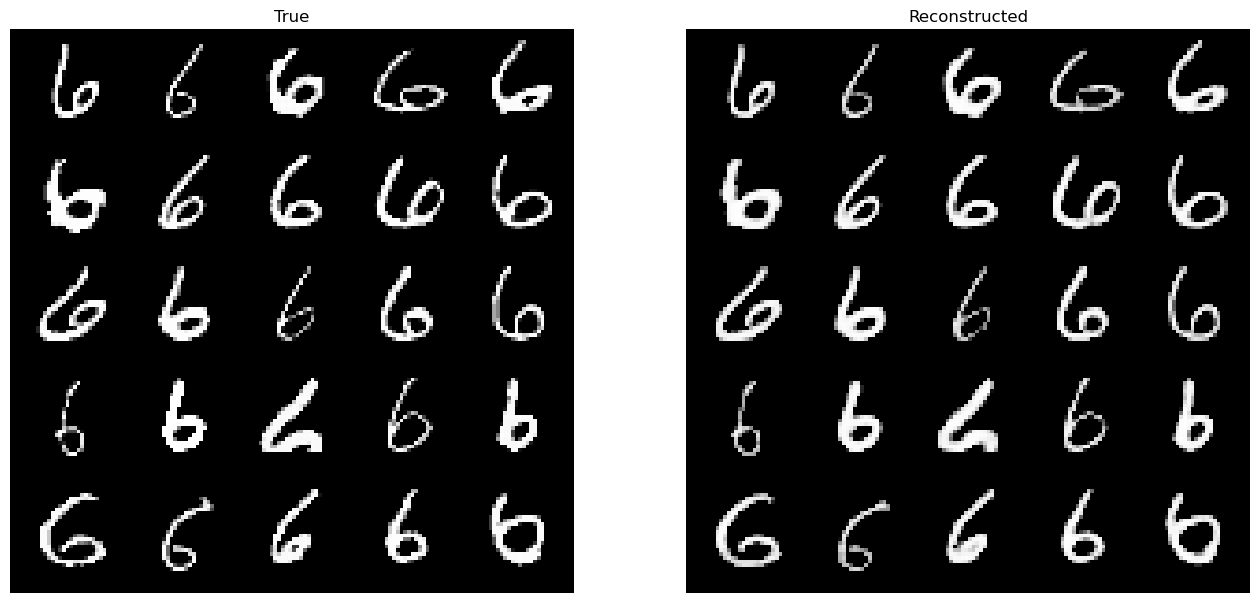

Epoch 0


100%|██████████| 118/118 [00:00<00:00, 174.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


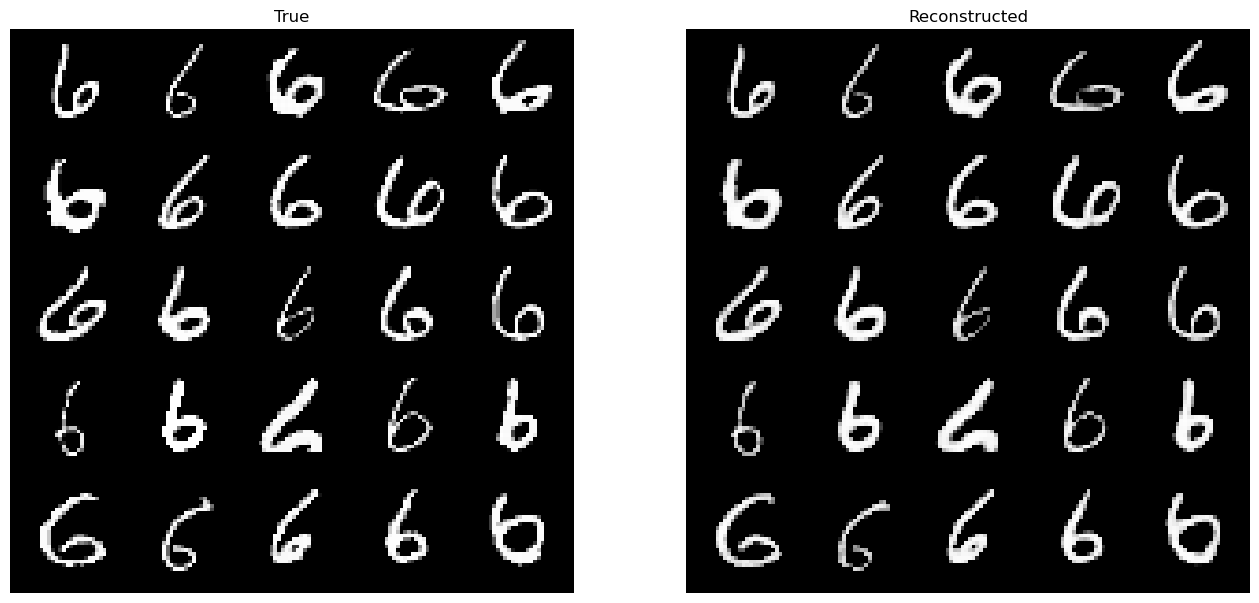

Epoch 1


100%|██████████| 118/118 [00:00<00:00, 173.64it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


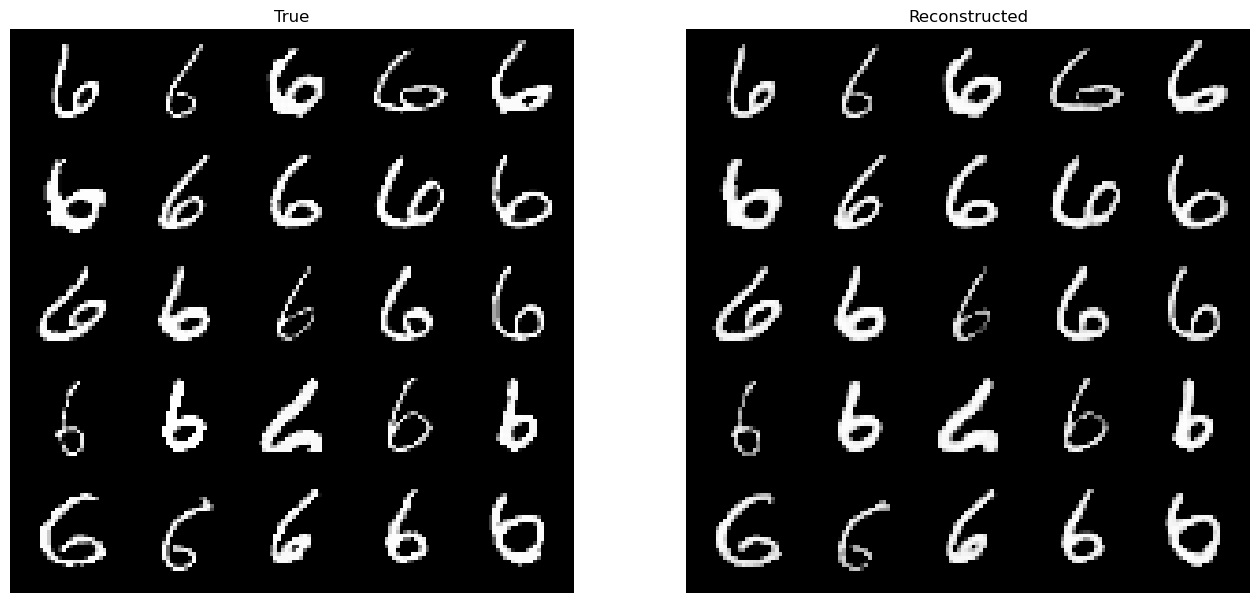

Epoch 2


100%|██████████| 118/118 [00:00<00:00, 173.62it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


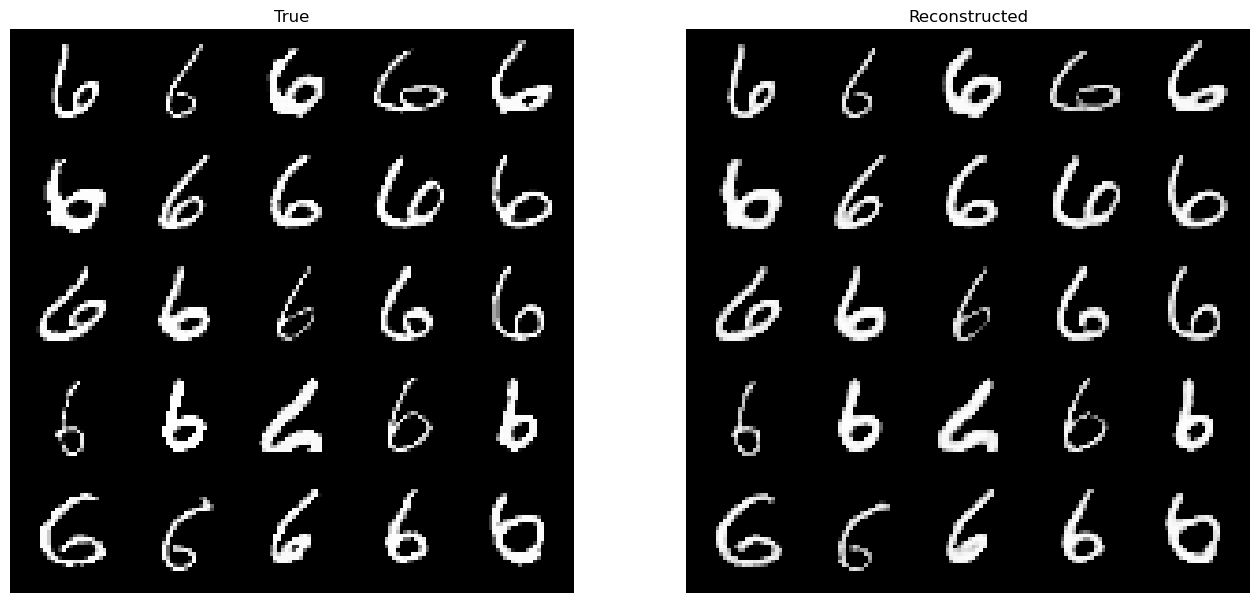

Epoch 3


100%|██████████| 118/118 [00:00<00:00, 173.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


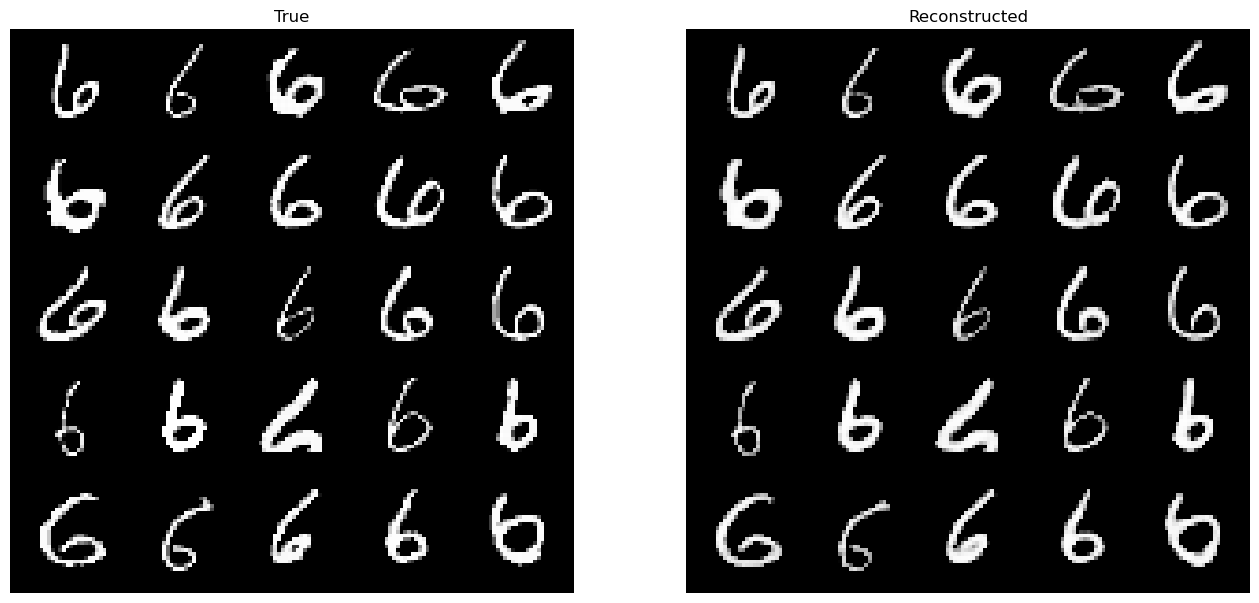

Epoch 4


100%|██████████| 118/118 [00:00<00:00, 172.58it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


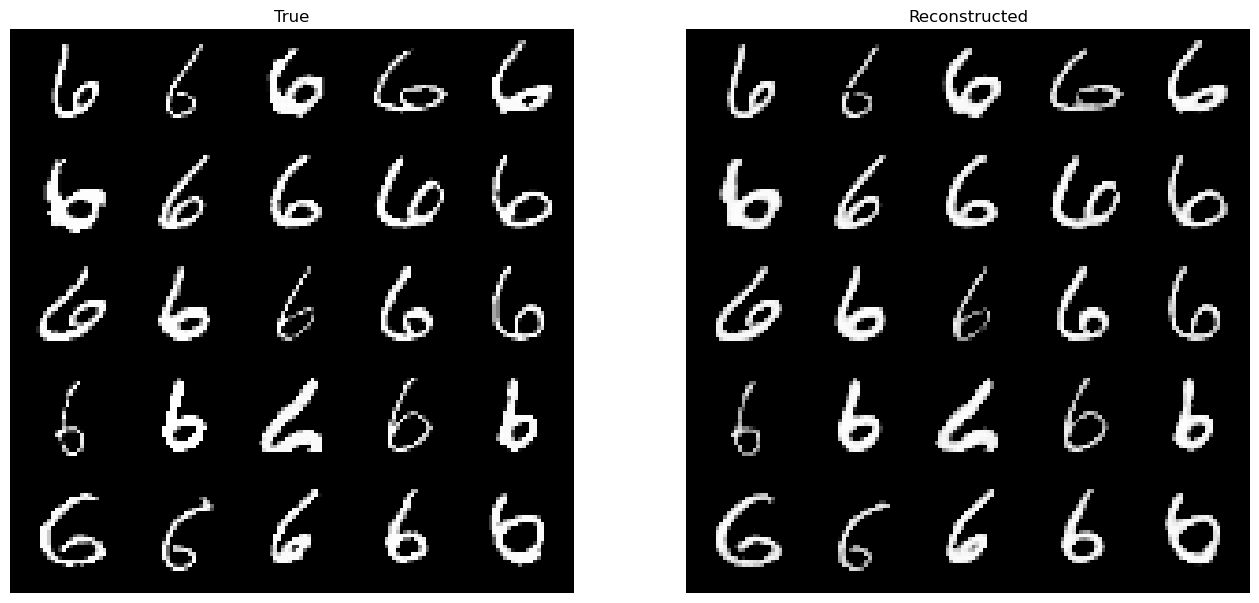

Epoch 5


100%|██████████| 118/118 [00:00<00:00, 166.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


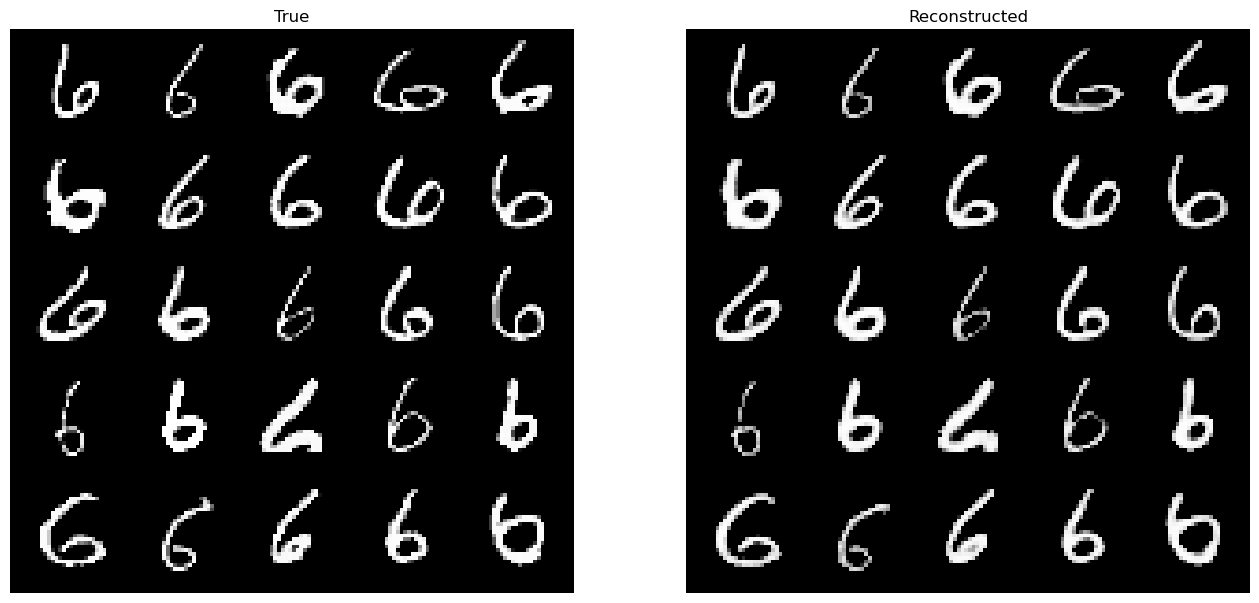

Epoch 6


100%|██████████| 118/118 [00:00<00:00, 173.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


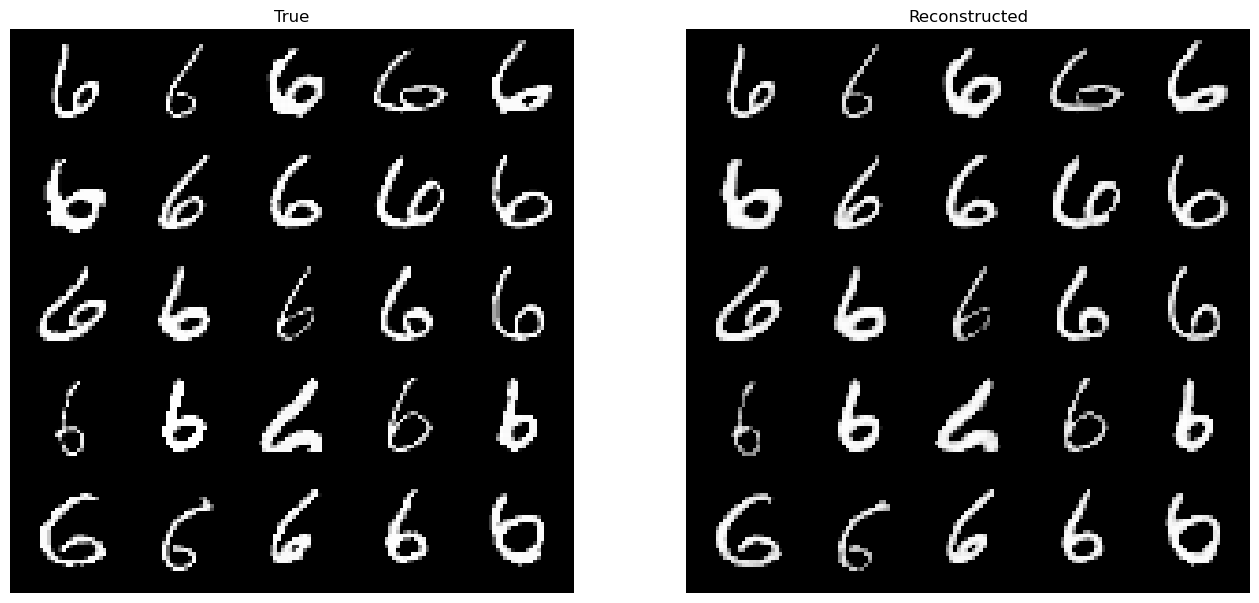

Epoch 7


100%|██████████| 118/118 [00:00<00:00, 153.77it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


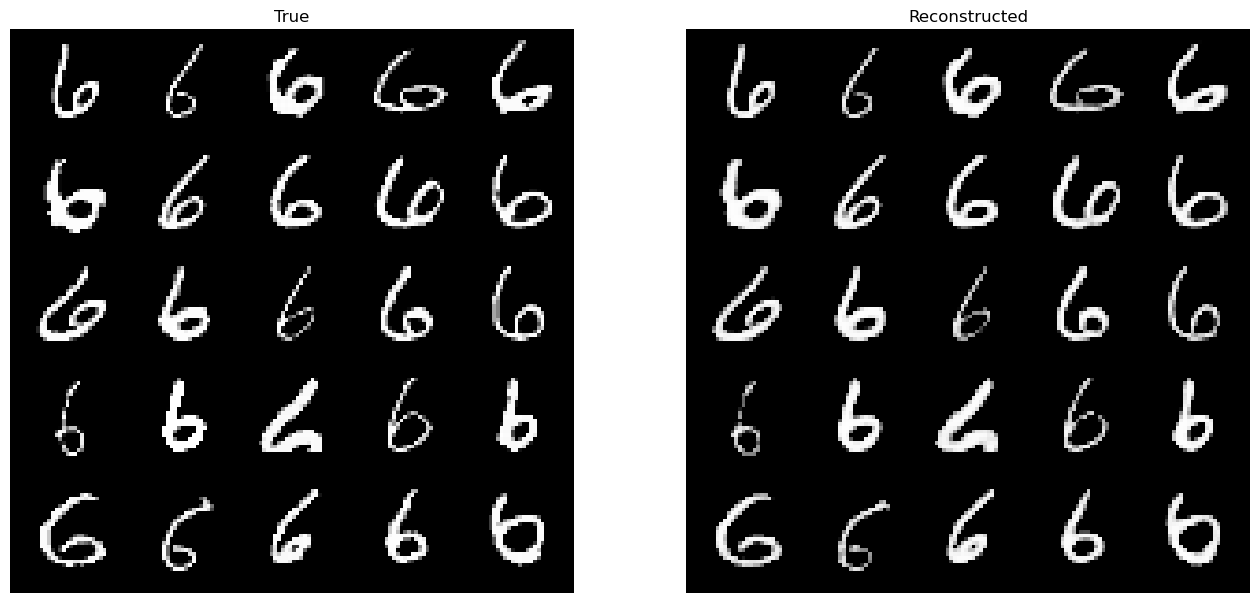

Epoch 8


100%|██████████| 118/118 [00:00<00:00, 176.34it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


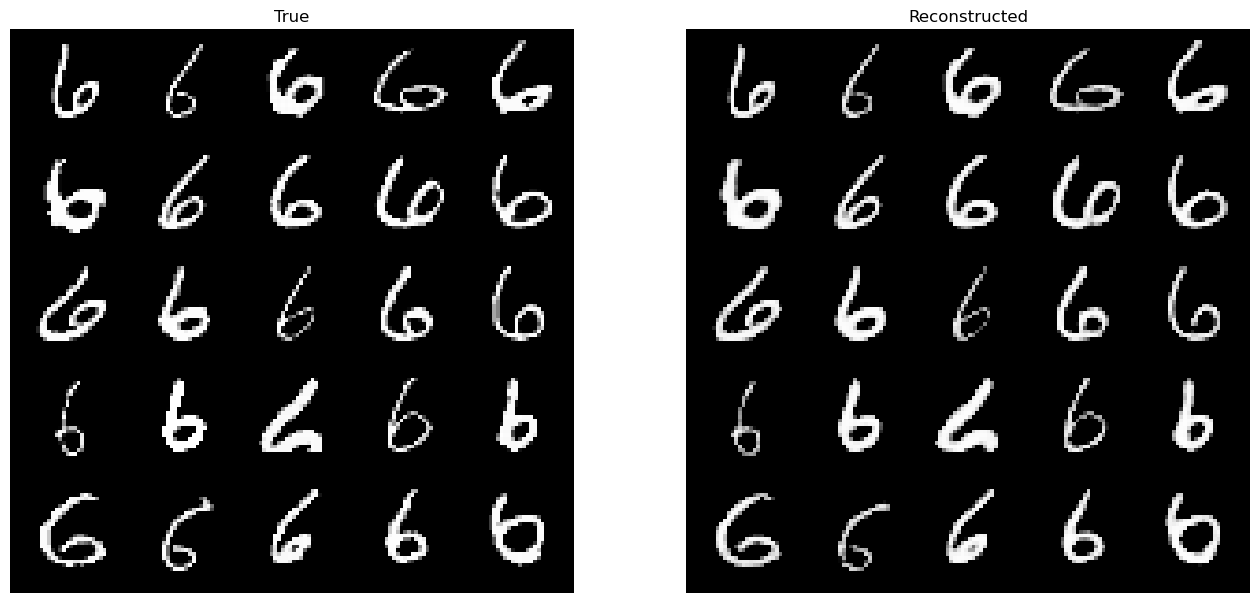

Epoch 9


100%|██████████| 118/118 [00:00<00:00, 173.58it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


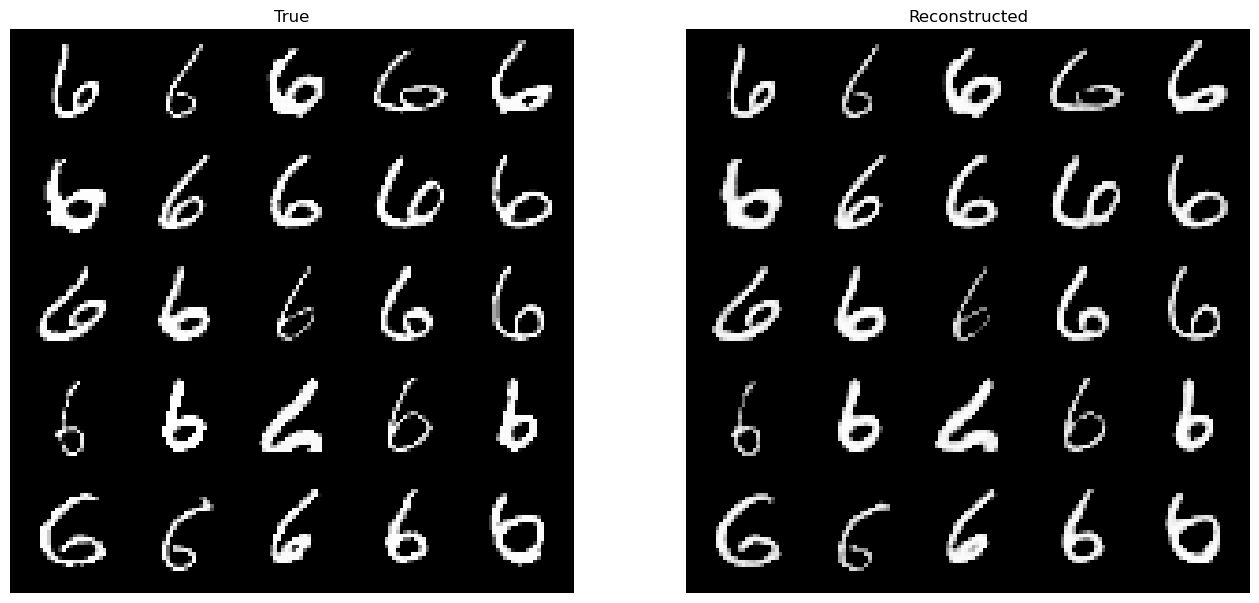

Epoch 0


100%|██████████| 118/118 [00:00<00:00, 176.21it/s]


Epoch 1


100%|██████████| 118/118 [00:00<00:00, 173.65it/s]


Epoch 2


100%|██████████| 118/118 [00:00<00:00, 175.52it/s]


Epoch 3


100%|██████████| 118/118 [00:00<00:00, 175.27it/s]


Epoch 4


100%|██████████| 118/118 [00:00<00:00, 158.15it/s]


Epoch 5


100%|██████████| 118/118 [00:00<00:00, 167.12it/s]


Epoch 6


100%|██████████| 118/118 [00:00<00:00, 174.79it/s]


Epoch 7


100%|██████████| 118/118 [00:00<00:00, 170.34it/s]


Epoch 8


100%|██████████| 118/118 [00:00<00:00, 174.45it/s]


Epoch 9


100%|██████████| 118/118 [00:00<00:00, 174.34it/s]


Epoch 0


100%|██████████| 118/118 [00:00<00:00, 174.37it/s]


Epoch 1


100%|██████████| 118/118 [00:00<00:00, 173.70it/s]


Epoch 2


100%|██████████| 118/118 [00:00<00:00, 171.69it/s]


Epoch 3


100%|██████████| 118/118 [00:00<00:00, 169.12it/s]


Epoch 4


100%|██████████| 118/118 [00:00<00:00, 174.67it/s]


Epoch 5


100%|██████████| 118/118 [00:00<00:00, 165.24it/s]


Epoch 6


100%|██████████| 118/118 [00:00<00:00, 170.92it/s]


Epoch 7


100%|██████████| 118/118 [00:00<00:00, 156.62it/s]


Epoch 8


100%|██████████| 118/118 [00:00<00:00, 172.51it/s]


Epoch 9


100%|██████████| 118/118 [00:00<00:00, 171.87it/s]


Epoch 0


100%|██████████| 118/118 [00:00<00:00, 173.42it/s]


Epoch 1


100%|██████████| 118/118 [00:00<00:00, 152.59it/s]


Epoch 2


100%|██████████| 118/118 [00:00<00:00, 173.16it/s]


Epoch 3


100%|██████████| 118/118 [00:00<00:00, 173.36it/s]


Epoch 4


100%|██████████| 118/118 [00:00<00:00, 173.56it/s]


Epoch 5


100%|██████████| 118/118 [00:00<00:00, 173.19it/s]


Epoch 6


100%|██████████| 118/118 [00:00<00:00, 174.62it/s]


Epoch 7


100%|██████████| 118/118 [00:00<00:00, 173.79it/s]


Epoch 8


100%|██████████| 118/118 [00:00<00:00, 171.91it/s]


Epoch 9


100%|██████████| 118/118 [00:00<00:00, 174.99it/s]


In [40]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)

from torchvision.utils import make_grid
from tqdm import tqdm
import time

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
   
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())

device = 'cuda'
vae = VAE().to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=0.002)

vae1=[]
vae2=[]
vae3=[]

for i in range(5):
    bs_var = 10 + 10*i
    bs_next = int((bs - bs_var)/2)
    dataloader0 = torch.utils.data.DataLoader(dataset=train0, batch_size=bs_var, drop_last=True, shuffle=True)
    dataloader1 =  torch.utils.data.DataLoader(dataset=train1, batch_size=bs_next, drop_last=True, shuffle=True)
    dataloader3 =   torch.utils.data.DataLoader(dataset=train2, batch_size=bs_next, drop_last=True, shuffle=True)
    ds = customdata(dataloader0,dataloader1,dataloader3)
    for i in range(5):

        for epoch in range(10):
            
            print(f"Epoch {epoch}")
            time.sleep(0.5)
            for images in tqdm(ds):
                images = images.to(device)
                vae_opt.zero_grad() # Clear out the gradients
                recon_images, encoding = vae(images)
                loss = reconstruction_loss(recon_images, images) + kl_divergence_loss(encoding).sum()
                loss.backward()
                vae_opt.step()

            if i<2:
                plt.subplot(1,2,1)
                show_tensor_images(images)
                plt.title("True")
                plt.subplot(1,2,2)
                show_tensor_images(recon_images)
                plt.title("Reconstructed")
                plt.show()
        recon_images = recon_images.detach().cpu()
        recon_images = recon_images.reshape(bs,1,28,28)
        cnn.eval()
        with torch.no_grad():
            test_output, last_layer = cnn(recon_images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
        vae_c1 = 0
        vae_c0 =0
        vae_c3 = 0
        for i in pred_y:
            if i == b: 
                vae_c0 += 1 #biased
            if i == a:
                vae_c1 += 1
            if i ==c:
                vae_c3 +=1



        vae1.append(vae_c0) #variable
        vae2.append(vae_c1) 
        vae3.append(vae_c3)


In [41]:
stat = []
mean_stat=[]
std_stat = []
for i in range(len(vae1)):
    stat.append(vae1[i])
    
    if (i+1)%5== 0 and i != 0:
        mean_stat.append(np.mean(stat))
        var = np.var(stat)
        std_stat.append(var ** 0.5)
        stat = []

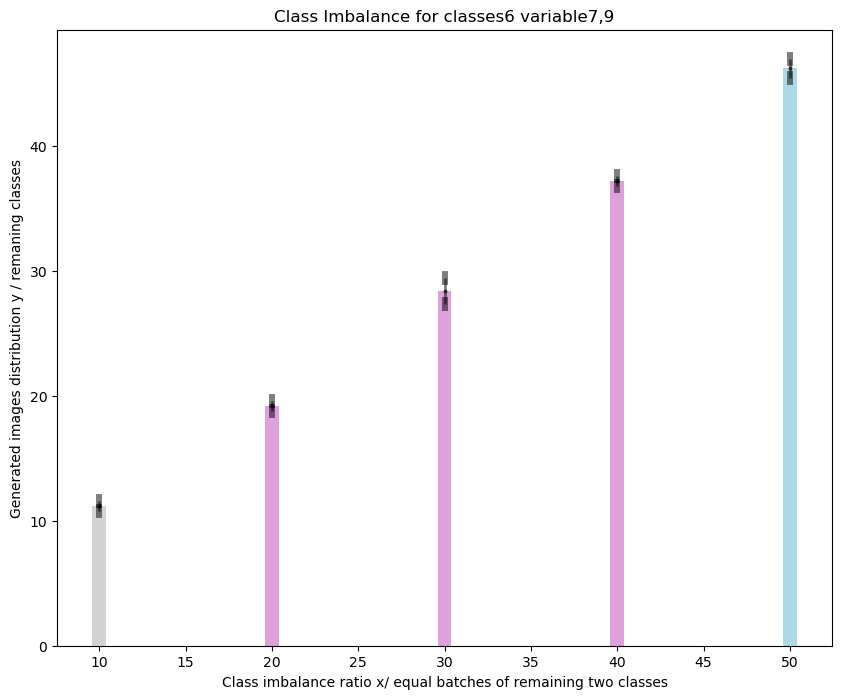

In [42]:
import matplotlib.pyplot as plt
stat = []
mean_stat=[]
std_stat = []
for i in range(len(vae1)):
    stat.append(vae1[i])
    
    if (i+1)%5== 0 and i != 0:
        mean_stat.append(np.mean(stat))
        var = np.var(stat)
        std_stat.append(var ** 0.5)
        stat = []
        
x=[10,20,30,40,50]
y= mean_stat
yerr=std_stat
width = 10
height = 8
plt.figure(figsize=(width, height))
plt.bar(x, y, color=['lightgray','plum','plum','plum','lightblue','lightblue','lightblue','palegreen','palegreen','palegreen', 'khaki', 'khaki', 'khaki'])
plt.title('Class Imbalance for classes'+ str(b) +' variable'+str(a)+','+str(c))
plt.xlabel('Class imbalance ratio x/ equal batches of remaining two classes')
plt.ylabel('Generated images distribution y / remaning classes')
plt.errorbar(x, y, yerr, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
plt.savefig('figure.png', dpi=400, transparent=True)
plt.show()

In [62]:
vae_c1 = 0
vae_c0 =0
vae_c3 = 0
for i in pred_y:
    if i == b: 
        vae_c0 += 1 #biased
    if i == a:
        vae_c1 += 1
    if i ==c:
        vae_c3 +=1
        


vae1.append(vae_c0) #variable
vae2.append(vae_c1) 
vae3.append(vae_c3)
        

In [77]:
if len(vae1) % 5 == 0:
    print('change batch size')

change batch size


In [76]:
vae1.pop()

9

In [ ]:
vae1 = []
vae2 = []
vae3 = []
#run after changing batch size

In [1154]:
stat = []
mean_stat=[]
std_stat = []
for i in range(len(gen1)):
    stat.append(vae1[i])
    
    if (i+1)%5== 0 and i != 0:
        mean_stat.append(np.mean(stat))
        var = np.var(stat)
        std_stat.append(var ** 0.5)
        stat = []

[6, 5, 6, 6, 5]
5


In [ ]:
import matplotlib.pyplot as plt 
x=[10,20,30,40,50,60]
y= mean_stat
yerr=std_stat
width = 10
height = 8
plt.figure(figsize=(width, height))
plt.bar(x, y, color=['lightgray','plum','plum','plum','lightblue','lightblue','lightblue','palegreen','palegreen','palegreen', 'khaki', 'khaki', 'khaki'])
plt.title('Class Imbalance for classes %d,%d,%d', b,a,c)
plt.xlabel('Class imbalance ratio x/ equal batches of remaining two classes')
plt.ylabel('Generated images distribution y / remaning classes')
plt.errorbar(x, y, yerr, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
plt.savefig('figure.png', dpi=400, transparent=True)
plt.show()

In [1097]:
recon_images.shape

torch.Size([120, 1, 28, 28])

In [4]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [5]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [6]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [7]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [8]:
classifer_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, drop_last=True, shuffle=True)

In [9]:
from torch.autograd import Variable
num_epochs = 5
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders)
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            pass
        
        pass
    
    
    pass
train(num_epochs, cnn, classifer_loader)

Epoch [1/5], Step [100/600], Loss: 0.1473
Epoch [1/5], Step [200/600], Loss: 0.1075
Epoch [1/5], Step [300/600], Loss: 0.1621
Epoch [1/5], Step [400/600], Loss: 0.0109
Epoch [1/5], Step [500/600], Loss: 0.0208
Epoch [1/5], Step [600/600], Loss: 0.0768
Epoch [2/5], Step [100/600], Loss: 0.0303
Epoch [2/5], Step [200/600], Loss: 0.0147
Epoch [2/5], Step [300/600], Loss: 0.0530
Epoch [2/5], Step [400/600], Loss: 0.0729
Epoch [2/5], Step [500/600], Loss: 0.0390
Epoch [2/5], Step [600/600], Loss: 0.1036
Epoch [3/5], Step [100/600], Loss: 0.0464
Epoch [3/5], Step [200/600], Loss: 0.0513
Epoch [3/5], Step [300/600], Loss: 0.0551
Epoch [3/5], Step [400/600], Loss: 0.0445
Epoch [3/5], Step [500/600], Loss: 0.0561
Epoch [3/5], Step [600/600], Loss: 0.0492
Epoch [4/5], Step [100/600], Loss: 0.0506
Epoch [4/5], Step [200/600], Loss: 0.0366
Epoch [4/5], Step [300/600], Loss: 0.0538
Epoch [4/5], Step [400/600], Loss: 0.0295
Epoch [4/5], Step [500/600], Loss: 0.1710
Epoch [4/5], Step [600/600], Loss:

In [10]:
torch.save(cnn, 'classifier.pt')

In [ ]:
cnn = torch.load('/home/jovyan/ClassifierMNIST/cnn')

In [ ]:
cnn

In [12]:
classifier = torch.load('classifier.pt')

In [13]:
classifier


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [14]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.98


In [15]:
def test():
    # Test the model
    classifier.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.98


In [ ]:
# plt.plot(d_loss)
# plt.plot(d_g_loss)
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Discriminator', 'Adversarial'], loc='center right')
# plt.show()

In [ ]:
# gen1 = []
# gen2 = []
# gen3 = []
#run this after changing the batches

In [74]:
#start run from here

In [179]:
generated = predictions_gen.reshape(bs,1,28,28)

In [180]:
cnn.eval()
with torch.no_grad():
    test_output, last_layer = cnn(generated)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()

In [181]:
# cnn.eval()
# with torch.no_grad():
    
#     correct = 0
#     total = 0
#     for images in ds:
        
#         test_output, last_layer = cnn(images)
#         pred_y = torch.max(test_output, 1)[1].data.squeeze()
#         # accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
#         pass
# print(pred_y)    
# # print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

In [182]:
pred_y

tensor([0, 0, 3, 1, 1, 1, 0, 5, 0, 5, 3, 0, 1, 0, 0, 3, 3, 1, 0, 3, 3, 0, 0, 1,
        3, 3, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 3, 3, 1, 0, 1, 1, 0, 3, 3, 3, 3,
        3, 3, 0, 1, 1, 0, 1, 0, 0, 3, 0, 3, 0, 1, 0, 0, 0, 3, 3, 3, 0, 1, 1, 0,
        1, 3, 3, 3, 0, 3, 0, 3, 1, 0, 0, 0, 1, 0, 3, 0, 1, 3, 3, 3, 0, 3, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 3, 0, 1, 3, 0, 3, 3, 0, 0, 0, 1, 0, 3, 0])

In [183]:
gen_c1 = 0
gen_c0 =0
gen_c3 = 0
for i in pred_y:
    if i == 0:
        gen_c0 += 1
    if i == 1:
        gen_c1 += 1
    if i ==3:
        gen_c3 +=1
        
list= [gen_c0,gen_c1,gen_c3]

gen1.append(gen_c0)
gen2.append(gen_c1)
gen3.append(gen_c3)
        

In [184]:
gen1

[54, 53, 53, 58, 46, 49, 56]

In [407]:
len(gen2)

30

In [186]:
gen3

[53, 44, 57, 43, 52, 37, 37]

In [775]:
np.mean(gen2) #take mean for 5 values

103.33333333333333

In [776]:
np.var(gen2)

67.55555555555556